In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind 
from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cmocean
import cartopy.feature as cfeature
import seaborn as sns
import datetime
import calendar
import iris
import pandas as pd
from pathlib import Path

In [2]:
ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/umnsaa_pa000.nc')

mask = ds.lmask

In [3]:
START_YEAR = 1981
END_YEAR = 2018

## Alternate runs 

In [43]:
def get_processed_var_xr(xr, var_name):
    if var_name == "ts_0":
        return xr - 273.15
    return xr

In [44]:
def get_alt_year_xr_map(var_name, filepath_format):
    year_xr_map = {}
    for year in range(START_YEAR, END_YEAR+1):
        filename = filepath_format.format(year)
        filepath = Path(filename)
        if not filepath.exists() or not filepath.is_file():
            continue
        ds = xr.open_dataset(filename)
        var_xr = ds[var_name]
        # Special processing for the variables
        var_xr = get_processed_var_xr(var_xr, var_name)
        year_xr_map[year] = var_xr

    return year_xr_map  

In [45]:
alt_year_xr_map = get_alt_year_xr_map(
    "ts_0",
    "/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_{}.nc")  

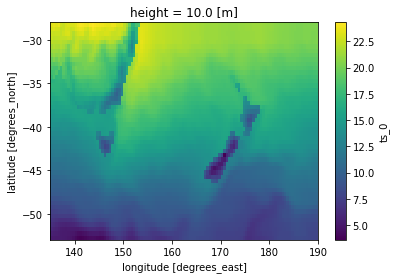

In [58]:
# Access test
alt_year_xr_map.get(1981).mean(dim='time').plot()

## New control runs

In [67]:
bundle_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pvera_*.nc')
bundle_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pvera_*.nc')
#bundle_2019 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-2019/um_pvera_*.nc')

In [69]:
con_bundles = {
    '1980': {
        'xr': bundle_1980,
        'start': 1981,
        'end': 1998,
    },
    '1999': {
        'xr': bundle_1999,
        'start': 2000,
        'end': 2018,
    }
}

In [70]:
def get_year_bundle_xr_map(con_bundle_info):
    year_bundle_xr_map = {}
    for bundle in con_bundle_info:
        val = con_bundle_info[bundle]
        for year in range(val['start'], val['end']+1):
            year_bundle_xr_map[year] = val['xr']
    return year_bundle_xr_map

In [71]:
def get_con_year_xr_map(alt_year_xr_map, con_bundle_info, var_name):
    year_bundle_xr_map = get_year_bundle_xr_map(con_bundle_info)
    years = alt_year_xr_map.keys()
    year_xr_map = {}
    for year in years:
        next_year = year + 1
        var_xr = year_bundle_xr_map[year][var_name]
        # Special processing for the variables
        var_xr = get_processed_var_xr(var_xr, var_name)
        # Slicing
        time_slice = slice(
            "{}-06-01".format(year),
            "{}-06-30".format(next_year),
        )
        var_xr_slice = var_xr.sel(time=time_slice)
        year_xr_map[year] = var_xr_slice
    return year_xr_map

In [72]:
con_year_xr_map = get_con_year_xr_map(alt_year_xr_map, con_bundles, "ts_0")

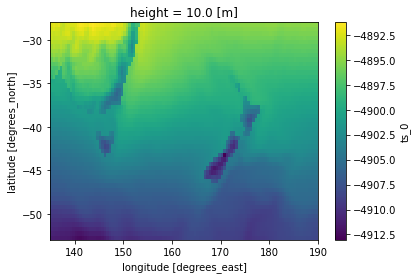

In [64]:
# Data access check
(bundle_1980['ts_0'] - 273.15).sel(time=slice('1981-06-01', '1982-06-30')).mean(dim='time').plot()

## Difference

In [36]:
def get_diff_year_xr_map(alt_year_xr_map, con_year_xr_map):
    years = alt_year_xr_map.keys()
    year_xr_map = {}
    for year in years:
        year_xr = \
            ( \
              alt_year_xr_map[year].resample(time='1M').mean() \
              - con_year_xr_map[year].resample(time='1M').mean() \
            ) \
            .rename({'time': 'event_month'})
        year_xr_map[year] = year_xr
    return year_xr_map

In [73]:
diff_year_xr_map = get_diff_year_xr_map(alt_year_xr_map, con_year_xr_map)

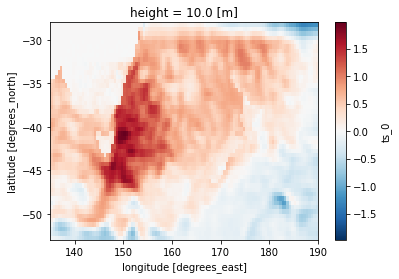

In [74]:
diff_year_xr_map.get(1981).mean(dim='event_month').plot()

In [75]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

year_phases = []
years = alt_year_xr_map.keys()
for year in years:
    diff_year = diff_year_xr_map[year]
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_year.sel(event_month=buildup_slice).mean(dim="event_month")
    peak = diff_year.sel(event_month=peak_slice).mean(dim="event_month")
    diedown = diff_year.sel(event_month=diedown_slice).mean(dim="event_month")
    
    diff_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    year_phases.append(diff_year_phase)
    
year_phases_xr = xr.concat(year_phases, dim="time")
year_phases_xr

<xarray.DataArray 'ts_0' (time: 36, phase: 3, latitude: 50, longitude: 110)>
dask.array<concatenate, shape=(36, 3, 50, 110), dtype=float32, chunksize=(1, 1, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
Dimensions without coordinates: time, phase

In [77]:
r_b = stats.ttest_1samp(year_phases_xr.isel(phase=0), 0, axis=0, nan_policy='omit')

# Convert the p-values into a dataarray:
da_b = xr.DataArray(r_b[1], dims=('latitude', 'longitude'), coords={
    'latitude': year_phases_xr['latitude'],
    'longitude': year_phases_xr['longitude']
})

r_p = stats.ttest_1samp(year_phases_xr.isel(phase=1), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_p = xr.DataArray(r_p[1], dims=('latitude', 'longitude'), coords={
    'latitude': year_phases_xr['latitude'],
    'longitude': year_phases_xr['longitude']
})

r_d = stats.ttest_1samp(year_phases_xr.isel(phase=2), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_d = xr.DataArray(r_d[1], dims=('latitude', 'longitude'), coords={
    'latitude': year_phases_xr['latitude'],
    'longitude': year_phases_xr['longitude']
})

sig_da = xr.concat([da_b, da_p, da_d], dim='phase')
sig_da

<xarray.DataArray (phase: 3, latitude: 50, longitude: 110)>
array([[[3.59612556e-42, 3.65647018e-39, 8.15599624e-44, ...,
         2.69286835e-45, 1.18532905e-41, 1.58636204e-47],
        [4.17631322e-45, 3.94422759e-40, 2.08332359e-42, ...,
         7.27663237e-06, 1.87458004e-21, 3.37570181e-30],
        [6.47613540e-35, 9.48704332e-36, 5.82480604e-40, ...,
         1.45249738e-03, 1.67924808e-14, 5.79651994e-32],
        ...,
        [           nan,            nan,            nan, ...,
         4.51990167e-45, 9.31351060e-44, 1.22999117e-43],
        [           nan,            nan,            nan, ...,
         9.49667239e-50, 5.10970586e-49, 3.13402429e-49],
        [           nan,            nan,            nan, ...,
         1.12636283e-53, 1.96002318e-53, 2.14346489e-53]],

       [[4.83842008e-32, 4.27985779e-34, 1.36704167e-34, ...,
         2.08111584e-51, 3.12576899e-59, 6.06816567e-60],
        [6.47338526e-26, 3.12397904e-25, 5.41104200e-23, ...,
         4.17151150e-39, 9.30985455e-47, 2.19178741e-57],
        [5.99268864e-02, 1.37282458e-22, 8.13580031e-29, ...,
         4.02189463e-15, 5.74796467e-25, 3.92649527e-42],
...
        [           nan,            nan,            nan, ...,
         1.64912078e-22, 4.14460093e-23, 6.85654473e-23],
        [           nan,            nan,            nan, ...,
         1.25870213e-10, 6.80309945e-11, 1.51042965e-10],
        [           nan,            nan,            nan, ...,
         4.63733263e-06, 3.36436910e-05, 6.04923289e-05]],

       [[6.32905784e-19, 1.52734784e-17, 5.74459623e-08, ...,
         8.52631945e-52, 2.41431201e-54, 1.39901262e-55],
        [1.25607402e-28, 8.30639338e-28, 3.55641186e-25, ...,
         1.77999841e-45, 3.08957177e-48, 4.47421750e-52],
        [1.64246891e-36, 3.62392671e-44, 7.16527190e-55, ...,
         1.67521516e-40, 4.61608192e-43, 2.84572470e-47],
        ...,
        [           nan,            nan,            nan, ...,
         1.22388033e-35, 2.50476446e-34, 1.26841094e-33],
        [           nan,            nan,            nan, ...,
         2.17923732e-38, 1.56168154e-37, 8.37478516e-37],
        [           nan,            nan,            nan, ...,
         6.90088109e-41, 3.17954750e-40, 1.90862044e-39]]])
Coordinates:
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
Dimensions without coordinates: phase

## Difference Maps

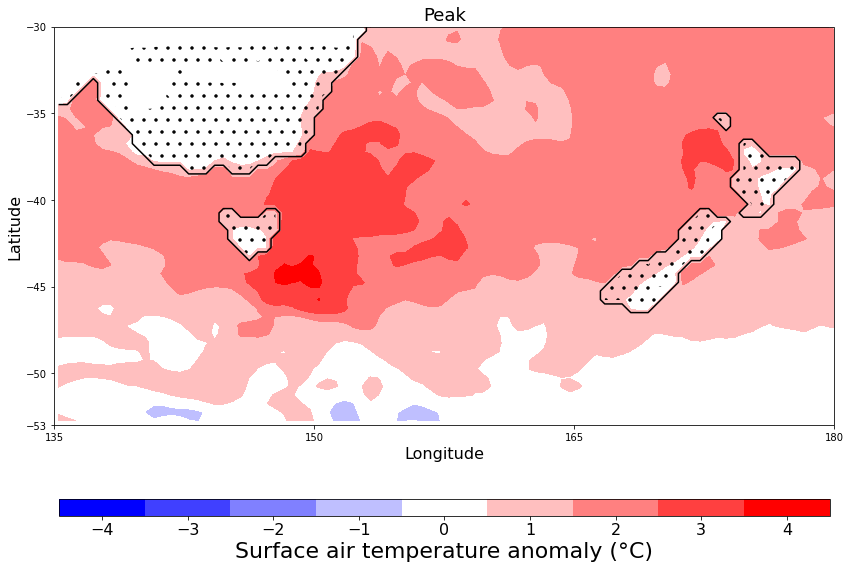

In [78]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=year_phases_xr.isel(phase=1).mean(dim='time').plot.contourf(
            levels=np.arange(-4.5, 5.0, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 9), 
            
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-4,5.0,1),fraction=0.035,aspect=45, extend='both') #,format='%.2f')
cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

# coastline
mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')
# significance testing
da_p.where(mask).mean(dim='time').plot.contourf(levels=[0.00, 0.05, 1.00], hatches=['.', None], colors='none', add_colorbar=False)

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Peak', fontsize=18)

plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_map_ensemble_control_tmean.png')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **

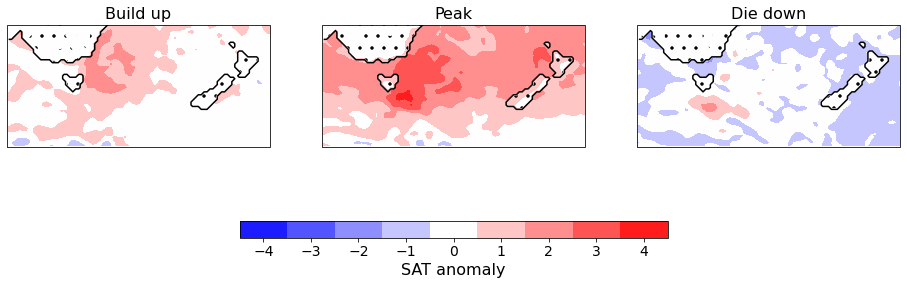

In [79]:
## new diff plot (phases)

def multiple_plots():
    nrow = 1
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = year_phases_xr.mean(dim='time')

    phases = ['Build up', 'Peak', 'Die down']
    contour = None
    mask_mean = mask.mean(dim='time')
    
    for col in range(ncol):
        cur_data = data[col]
        contour = ax[col].contourf(
            cur_data.longitude,
            cur_data.latitude,
            cur_data.values,
            levels=np.arange(-4.5, 5.0, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr'), 
        )
        ax[col].contour(
            mask_mean.longitude, 
            mask_mean.latitude,
            mask_mean.values,
            levels=[0.5], 
            cmap='gray')
        phase_mask_mean = sig_da[col].where(mask).mean(dim='time')
        ax[col].contourf(
            phase_mask_mean.longitude,
            phase_mask_mean.latitude,
            phase_mask_mean.values,
            levels=[0.00, 0.05, 1.00],
            hatches=['.', None],
            colors='none',
            add_colorbar=False,
        )

        ax[col].set_extent([135, 180, -53, -32],crs=ccrs.PlateCarree()) 
        ax[col].set_title(phases[col], fontsize=16)

    cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), orientation="horizontal",ticks=np.arange(-4,5.0,1),fraction=0.035,aspect=25)
    cbar.set_label("SAT anomaly", fontsize=16)  
    cbar.ax.tick_params(labelsize=14)

    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_sat_phases_land.png')
    #0.035

multiple_plots()

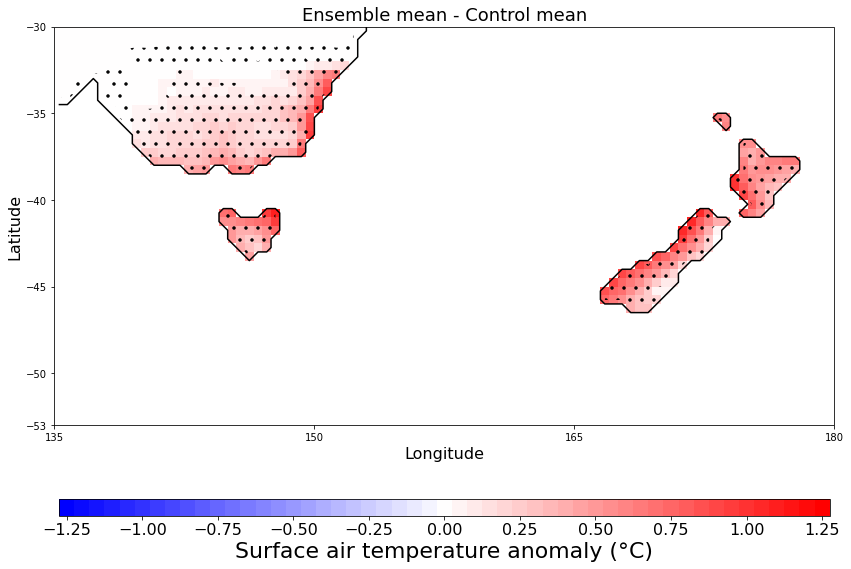

In [27]:
## one sample t test 

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=year_phases_xr.isel(phase=1).mean(dim='time').where(mask).plot(
            levels=np.arange(-1.275, 1.3, 0.05),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr'), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-1.25,1.3,0.25),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)


da_p.where(mask).mean(dim='time').plot.contourf(levels=[0.00, 0.05, 1.00], hatches=['.', None], colors='none', add_colorbar=False)
mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Ensemble mean - Control mean', fontsize=18)

plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_map_ensemble_control_tmean_ttest_land.png')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **

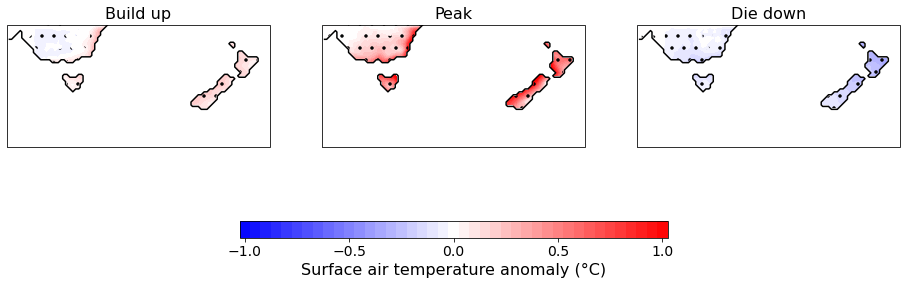

In [80]:
## new diff plot (phases)

def multiple_plots():
    nrow = 1
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = year_phases_xr.mean(dim='time').where(mask).mean(dim='time') 
    phases = ['Build up', 'Peak', 'Die down']
    contour = None    
    mask_mean = mask.mean(dim='time') 
    
    for col in range(ncol):
        cur_data = data[col]
        contour = ax[col].contourf(
            cur_data.longitude,
            cur_data.latitude,
            cur_data.values,
            levels=np.arange(-1.025, 1.05, 0.05),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr'), 
        )
        
        ax[col].contour(
            mask_mean.longitude, 
            mask_mean.latitude,
            mask_mean.values,
            levels=[0.5], 
            cmap='gray')
        
        phase_mask_mean = sig_da[col].where(mask).mean(dim='time')
        
        ax[col].contourf(
            phase_mask_mean.longitude,
            phase_mask_mean.latitude,
            phase_mask_mean.values,
            levels=[0.00, 0.05, 1.00],
            hatches=['.', None],
            colors='none',
            add_colorbar=False,
        )

        ax[col].set_extent([135, 180, -53, -32],crs=ccrs.PlateCarree()) 
        ax[col].set_title(phases[col], fontsize=16)

    cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), orientation="horizontal",ticks=np.arange(-1,1.05,0.5),fraction=0.035,aspect=25)
    cbar.set_label(label=u'Surface air temperature anomaly (\u00B0C)', fontsize=16)  
    cbar.ax.tick_params(labelsize=14)

    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_sat_phases_land.png')
    #0.035

multiple_plots()

## Latent heat flux

In [118]:
# LH

ds_1981 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1981.nc')
lh_1981 = ds_1981.surface_upward_latent_heat_flux

ds_1982= xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1982.nc')
lh_1982 = ds_1982.surface_upward_latent_heat_flux

ds_1983 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1983.nc')
lh_1983 = ds_1983.surface_upward_latent_heat_flux

ds_1984 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1984.nc')
lh_1984 = ds_1984.surface_upward_latent_heat_flux

ds_1985 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1985.nc')
lh_1985 = ds_1985.surface_upward_latent_heat_flux

ds_1986 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1986.nc')
lh_1986 = ds_1986.surface_upward_latent_heat_flux

ds_1987 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1987.nc')
lh_1987 = ds_1987.surface_upward_latent_heat_flux

ds_1988 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1988.nc')
lh_1988 = ds_1988.surface_upward_latent_heat_flux

ds_1989 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1989.nc')
lh_1989 = ds_1989.surface_upward_latent_heat_flux

ds_1990 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1990.nc')
lh_1990 = ds_1990.surface_upward_latent_heat_flux

ds_1991 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1991.nc')
lh_1991 = ds_1991.surface_upward_latent_heat_flux

ds_1992 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1992.nc')
lh_1992 = ds_1992.surface_upward_latent_heat_flux

ds_1993 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1993.nc')
lh_1993 = ds_1993.surface_upward_latent_heat_flux

ds_1994 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1994.nc')
lh_1994 = ds_1994.surface_upward_latent_heat_flux

ds_1996 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1996.nc')
lh_1996 = ds_1996.surface_upward_latent_heat_flux

ds_1997 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1997.nc')
lh_1997 = ds_1997.surface_upward_latent_heat_flux

ds_1998 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1998.nc')
lh_1998 = ds_1998.surface_upward_latent_heat_flux

ds_2000 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2000.nc')
lh_2000 = ds_2000.surface_upward_latent_heat_flux

ds_2001 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2001.nc')
lh_2001 = ds_2001.surface_upward_latent_heat_flux

ds_2002 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2002.nc')
lh_2002 = ds_2002.surface_upward_latent_heat_flux

ds_2003 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2003.nc')
lh_2003 = ds_2003.surface_upward_latent_heat_flux

ds_2004 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2004.nc')
lh_2004 = ds_2004.surface_upward_latent_heat_flux

ds_2005 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2005.nc')
lh_2005 = ds_2005.surface_upward_latent_heat_flux

ds_2006 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2006.nc')
lh_2006 = ds_2006.surface_upward_latent_heat_flux

ds_2007 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2007.nc')
lh_2007 = ds_2007.surface_upward_latent_heat_flux

ds_2008 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2008.nc')
lh_2008 = ds_2008.surface_upward_latent_heat_flux

ds_2009 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2009.nc')
lh_2009 = ds_2009.surface_upward_latent_heat_flux

ds_2010 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2010.nc')
lh_2010 = ds_2010.surface_upward_latent_heat_flux

ds_2011 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2011.nc')
lh_2011 = ds_2011.surface_upward_latent_heat_flux

ds_2012 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2012.nc')
lh_2012 = ds_2012.surface_upward_latent_heat_flux

ds_2013 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2013.nc')
lh_2013 = ds_2013.surface_upward_latent_heat_flux

ds_2014 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2014.nc')
lh_2014 = ds_2014.surface_upward_latent_heat_flux

ds_2015 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2015.nc')
lh_2015 = ds_2015.surface_upward_latent_heat_flux

ds_2016 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2016.nc')
lh_2016 = ds_2016.surface_upward_latent_heat_flux

ds_2017 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2017.nc')
lh_2017 = ds_2017.surface_upward_latent_heat_flux

ds_2018 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2018.nc')
lh_2018 = ds_2018.surface_upward_latent_heat_flux

In [120]:
ds_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pvera_*.nc')
ds_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pvera_*.nc')
ds_2019 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-2019/um_pvera_*.nc')

In [121]:
con_1981 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1981-06-01', '1982-06-30'))
con_1982 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1982-06-01', '1983-06-30')) 
con_1983 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1983-06-01', '1984-06-30')) 
con_1984 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1984-06-01', '1985-06-30')) 
con_1985 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1985-06-01', '1986-06-30')) 
con_1986 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1986-06-01', '1987-06-30')) 
con_1987 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1987-06-01', '1988-06-30')) 
con_1988 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1988-06-01', '1989-06-30')) 
con_1989 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1989-06-01', '1990-06-30')) 
con_1990 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1990-06-01', '1991-06-30')) 
con_1991 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1991-06-01', '1992-06-30')) 
con_1992 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1992-06-01', '1993-06-30')) 
con_1993 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1993-06-01', '1994-06-30')) 
con_1994 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1994-06-01', '1995-06-30')) 
con_1996 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1996-06-01', '1997-06-30')) 
con_1997 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1997-06-01', '1998-06-30')) 
con_1998 = (ds_1980['surface_upward_latent_heat_flux']).sel(time=slice('1998-06-01', '1999-06-30')) 
con_2000 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2000-06-01', '2001-06-30')) 
con_2001 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2001-06-01', '2002-06-30')) 
con_2002 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2002-06-01', '2003-06-30')) 
con_2003 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2003-06-01', '2004-06-30')) 
con_2004 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2004-06-01', '2005-06-30')) 
con_2005 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2005-06-01', '2006-06-30')) 
con_2006 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2006-06-01', '2007-06-30')) 
con_2007 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2007-06-01', '2008-06-30')) 
con_2008 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2008-06-01', '2009-06-30')) 
con_2009 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2009-06-01', '2010-06-30')) 
con_2010 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2010-06-01', '2011-06-30')) 
con_2011 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2011-06-01', '2012-06-30')) 
con_2012 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2012-06-01', '2013-06-30')) 
con_2013 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2013-06-01', '2014-06-30')) 
con_2014 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2014-06-01', '2015-06-30')) 
con_2015 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2015-06-01', '2016-06-30')) 
con_2016 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2016-06-01', '2017-06-30')) 
con_2017 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2017-06-01', '2018-06-30')) 
con_2018 = (ds_1999['surface_upward_latent_heat_flux']).sel(time=slice('2018-06-01', '2019-06-30')) 
con_2019 = (ds_2019['surface_upward_latent_heat_flux']).sel(time=slice('2019-06-01', '2020-06-30')) 

In [122]:
diff_1981 = lh_1981.resample(time='1M').mean() - con_1981.resample(time='1M').mean()
diff_1982 = (lh_1982.resample(time='1M').mean() - con_1982.resample(time='1M').mean())
diff_1983 = (lh_1983.resample(time='1M').mean() - con_1983.resample(time='1M').mean())
diff_1984 = (lh_1984.resample(time='1M').mean() - con_1984.resample(time='1M').mean())
diff_1985 = (lh_1985.resample(time='1M').mean() - con_1985.resample(time='1M').mean())
diff_1986 = (lh_1986.resample(time='1M').mean() - con_1986.resample(time='1M').mean())
diff_1987 = (lh_1987.resample(time='1M').mean() - con_1987.resample(time='1M').mean())
diff_1988 = (lh_1988.resample(time='1M').mean() - con_1988.resample(time='1M').mean())
diff_1989 = (lh_1989.resample(time='1M').mean() - con_1989.resample(time='1M').mean())
diff_1990 = (lh_1990.resample(time='1M').mean() - con_1990.resample(time='1M').mean())
diff_1991 = (lh_1991.resample(time='1M').mean() - con_1991.resample(time='1M').mean())
diff_1992 = (lh_1992.resample(time='1M').mean() - con_1992.resample(time='1M').mean())
diff_1993 = (lh_1993.resample(time='1M').mean() - con_1993.resample(time='1M').mean())
diff_1994 = (lh_1994.resample(time='1M').mean() - con_1994.resample(time='1M').mean())
diff_1996 = (lh_1996.resample(time='1M').mean() - con_1996.resample(time='1M').mean())
diff_1997 = (lh_1997.resample(time='1M').mean() - con_1997.resample(time='1M').mean())
diff_1998 = (lh_1998.resample(time='1M').mean() - con_1998.resample(time='1M').mean())
diff_2000 = (lh_2000.resample(time='1M').mean() - con_2000.resample(time='1M').mean())
diff_2001 = (lh_2001.resample(time='1M').mean() - con_2001.resample(time='1M').mean())
diff_2002 = (lh_2002.resample(time='1M').mean() - con_2002.resample(time='1M').mean())
diff_2003 = (lh_2003.resample(time='1M').mean() - con_2003.resample(time='1M').mean())
diff_2004 = (lh_2004.resample(time='1M').mean() - con_2004.resample(time='1M').mean())
diff_2005 = (lh_2005.resample(time='1M').mean() - con_2005.resample(time='1M').mean())
diff_2006 = (lh_2006.resample(time='1M').mean() - con_2006.resample(time='1M').mean())
diff_2007 = (lh_2007.resample(time='1M').mean() - con_2007.resample(time='1M').mean())
diff_2008 = (lh_2008.resample(time='1M').mean() - con_2008.resample(time='1M').mean())
diff_2009 = (lh_2009.resample(time='1M').mean() - con_2009.resample(time='1M').mean())
diff_2010 = (lh_2010.resample(time='1M').mean() - con_2010.resample(time='1M').mean())
diff_2011 = (lh_2011.resample(time='1M').mean() - con_2011.resample(time='1M').mean())
diff_2012 = (lh_2012.resample(time='1M').mean() - con_2012.resample(time='1M').mean())
diff_2013 = (lh_2013.resample(time='1M').mean() - con_2013.resample(time='1M').mean())
diff_2014 = (lh_2014.resample(time='1M').mean() - con_2014.resample(time='1M').mean())
diff_2015 = (lh_2015.resample(time='1M').mean() - con_2015.resample(time='1M').mean())
diff_2016 = (lh_2016.resample(time='1M').mean() - con_2016.resample(time='1M').mean())
diff_2017 = (lh_2017.resample(time='1M').mean() - con_2017.resample(time='1M').mean())
diff_2018 = (lh_2018.resample(time='1M').mean() - con_2018.resample(time='1M').mean())

In [124]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

year_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_year = globals().get("diff_{}".format(year))
    if diff_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_year.sel(time=buildup_slice).mean(dim="time")
    peak = diff_year.sel(time=peak_slice).mean(dim="time")
    diedown = diff_year.sel(time=diedown_slice).mean(dim="time")
    
    diff_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    year_phases.append(diff_year_phase)
    
lh_year_phases_xr = xr.concat(year_phases, dim="time")

In [130]:
r_b = stats.ttest_1samp(lh_year_phases_xr.isel(phase=0), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_b = xr.DataArray(r_b[1], dims=('latitude', 'longitude'), coords={
    'latitude': lh_year_phases_xr['latitude'],
    'longitude': lh_year_phases_xr['longitude']
})

r_p = stats.ttest_1samp(lh_year_phases_xr.isel(phase=1), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_p = xr.DataArray(r_p[1], dims=('latitude', 'longitude'), coords={
    'latitude': lh_year_phases_xr['latitude'],
    'longitude': lh_year_phases_xr['longitude']
})

r_d = stats.ttest_1samp(lh_year_phases_xr.isel(phase=2), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_d = xr.DataArray(r_d[1], dims=('latitude', 'longitude'), coords={
    'latitude': lh_year_phases_xr['latitude'],
    'longitude': lh_year_phases_xr['longitude']
})

sig_da = xr.concat([da_b, da_p, da_d], dim='phase')
sig_da

<xarray.DataArray (phase: 3, latitude: 50, longitude: 110)>
array([[[1.70917637e-29, 9.09891555e-28, 2.52587104e-29, ...,
         2.66339455e-25, 3.45649150e-28, 2.38738144e-29],
        [4.30226218e-32, 7.78044909e-30, 1.54965503e-31, ...,
         4.38420897e-03, 5.17034266e-15, 2.22444182e-19],
        [2.56198611e-32, 3.31697926e-31, 2.41157448e-32, ...,
         1.07080594e-02, 6.90145317e-11, 8.52645198e-21],
        ...,
        [           nan,            nan,            nan, ...,
         2.12376771e-36, 1.38985944e-35, 7.91564317e-35],
        [           nan,            nan,            nan, ...,
         9.89962328e-40, 1.63368870e-39, 8.01341692e-39],
        [           nan,            nan,            nan, ...,
         4.26755486e-41, 1.02475098e-40, 6.25070574e-40]],

       [[6.29248986e-32, 3.19912137e-33, 2.49292228e-31, ...,
         5.81315108e-15, 9.56906408e-16, 1.47322044e-16],
        [1.31027811e-26, 6.73988991e-25, 1.44632137e-20, ...,
         4.50996039e-16, 6.91441165e-16, 9.22424805e-18],
        [3.70277412e-02, 4.08345903e-21, 1.14192709e-23, ...,
         3.11990201e-07, 2.63648460e-09, 6.59510935e-15],
...
        [           nan,            nan,            nan, ...,
         3.99780090e-18, 1.49385650e-19, 1.24320035e-19],
        [           nan,            nan,            nan, ...,
         9.68918650e-07, 2.00899740e-07, 5.06982086e-08],
        [           nan,            nan,            nan, ...,
         2.57278319e-07, 1.61099917e-06, 2.36375399e-06]],

       [[5.69750296e-16, 5.82345341e-15, 8.06728280e-07, ...,
         1.69435283e-32, 1.13034009e-32, 5.90172495e-33],
        [1.32276688e-25, 1.01451516e-25, 1.52076065e-23, ...,
         3.29835692e-33, 1.74366034e-33, 1.30619538e-33],
        [2.81433766e-30, 1.00308190e-30, 6.68679791e-31, ...,
         6.80606068e-33, 2.85212675e-33, 1.18905166e-33],
        ...,
        [           nan,            nan,            nan, ...,
         2.36614330e-32, 1.12446943e-31, 3.93886815e-31],
        [           nan,            nan,            nan, ...,
         6.08796823e-34, 8.64731974e-34, 2.06383013e-33],
        [           nan,            nan,            nan, ...,
         6.92879471e-35, 7.20005114e-35, 1.03635167e-34]]])
Coordinates:
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
Dimensions without coordinates: phase

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **

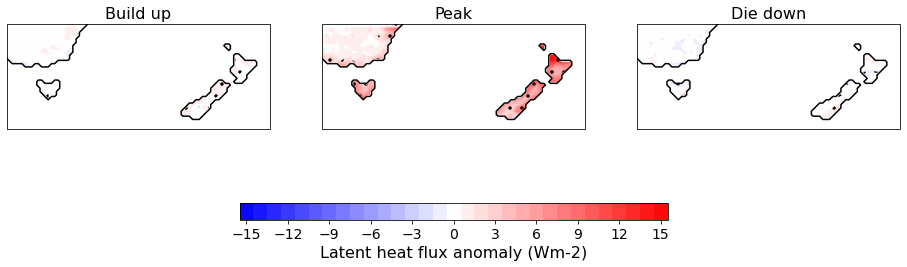

In [138]:
## new diff plot (phases)

def multiple_plots():
    nrow = 1
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = lh_year_phases_xr.mean(dim='time').where(mask).mean(dim='time')

    phases = ['Build up', 'Peak', 'Die down']
    contour = None
    mask_mean = mask.mean(dim='time')
    
    for col in range(ncol):
        cur_data = data[col]
        contour = ax[col].contourf(
            cur_data.longitude,
            cur_data.latitude,
            cur_data.values,
            levels=np.arange(-15.5, 16, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr'), 
        )
        
        ax[col].contour(
            mask_mean.longitude, 
            mask_mean.latitude,
            mask_mean.values,
            levels=[0.5], 
            cmap='gray')
        
        phase_mask_mean = sig_da[col].where(mask).mean(dim='time')
        ax[col].contourf(
            phase_mask_mean.longitude,
            phase_mask_mean.latitude,
            phase_mask_mean.values,
            levels=[0.00, 0.05, 1.00],
            hatches=['.', None],
            colors='none',
            add_colorbar=False,
        )

        ax[col].set_extent([140, 180, -48, -32],crs=ccrs.PlateCarree()) 
        ax[col].set_title(phases[col], fontsize=16)

    cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), orientation="horizontal",ticks=np.arange(-15, 16, 3),fraction=0.035,aspect=25)
    cbar.set_label("Latent heat flux anomaly (Wm-2)", fontsize=16)  
    cbar.ax.tick_params(labelsize=14)

    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_lh_phases_land.png')
    #0.035

multiple_plots()

## Model Evaluation

In [215]:
ds_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pvera_*.nc')
ds_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pvera_*.nc')

In [216]:
control1 = (ds_1980['ts_0']-273.15).sel(time=slice('1983-01-01', '1999-12-31'))
control2 = (ds_1999['ts_0']-273.15).sel(time=slice('2000-01-01', '2012-12-31'))

In [217]:
control = xr.concat([control1, control2], dim='time')
control

<xarray.DataArray 'ts_0' (time: 10958, latitude: 50, longitude: 110)>
dask.array<concatenate, shape=(10958, 50, 110), dtype=float32, chunksize=(31, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01T12:00:00 ... 2012-12-31T12:00:00
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0

In [219]:
ds_skt = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-SKT-MEAN/era5_dailytmean_remap_*.nc')
ds_skt

<xarray.Dataset>
Dimensions:       (time: 10958, longitude: 110, latitude: 50)
Coordinates:
  * time          (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2012-12-31
  * longitude     (longitude) float32 135.2 135.8 136.2 ... 188.8 189.2 189.8
  * latitude      (latitude) float32 -52.75 -52.25 -51.75 ... -28.75 -28.25
Data variables:
    dailysktmean  (time, latitude, longitude) float32 dask.array<chunksize=(365, 50, 110), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Mar 03 10:46:52 2022: cdo -remapbil,ens_grid.txt /g/dat...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [222]:
skt = (ds_skt['dailysktmean']-273.15)
skt

<xarray.DataArray 'dailysktmean' (time: 10958, latitude: 50, longitude: 110)>
dask.array<sub, shape=(10958, 50, 110), dtype=float32, chunksize=(366, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2012-12-31
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25

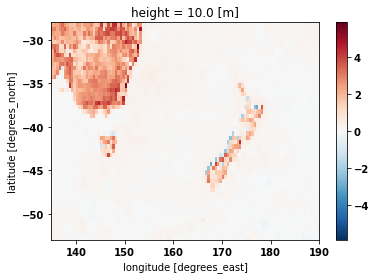

In [223]:
(control.mean(dim='time') - skt.mean(dim='time')).plot()

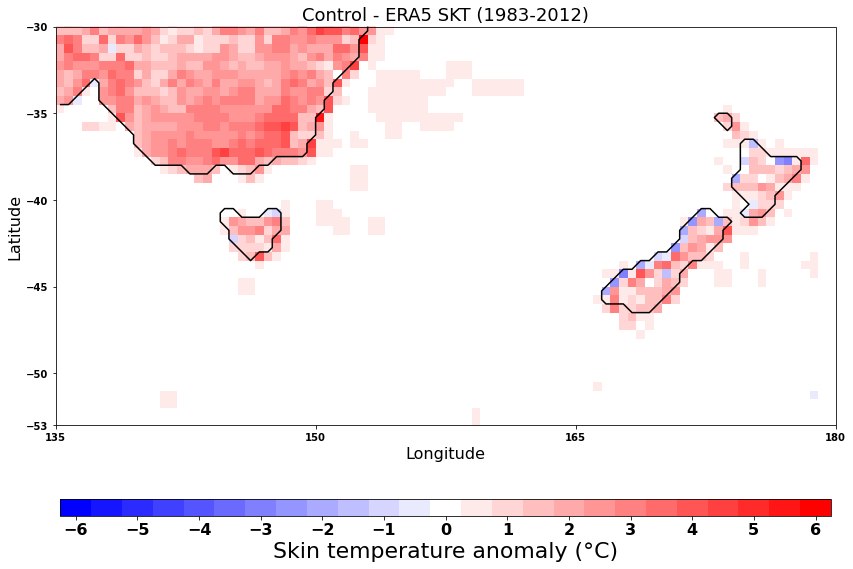

In [224]:
## mean bias (control - ERA5 SKT)

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=(control.mean(dim='time') - skt.mean(dim='time')).plot(
            levels=np.arange(-6.25, 6.5, 0.5),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 25), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-6,7,1),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Skin temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')


plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Control - ERA5 SKT (1983-2012)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/mean-bias-control-skt-19832012.png')

In [206]:
noaa_ds = xr.open_mfdataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/oisst_avhrr_v2-1_*.nc').sel(time=slice('1983', '2012'))

In [150]:
noaa_ds

<xarray.Dataset>
Dimensions:  (time: 10958, lon: 1440, lat: 720, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01T12:00:00 ... 2012-12-31T12:00:00
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(365, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/39)
    CDI:                        Climate Data Interface version 1.9.5 (http://...
    history:                    Final file created using preliminary as first...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    institution:                NOAA/National Centers for Environmental Infor...
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    CDO:                        Climate Data Operators version 1.9.5 (http://...

In [207]:
sst = noaa_ds.sst.sel(lat=slice(-53, -30), lon=slice(135, 180))

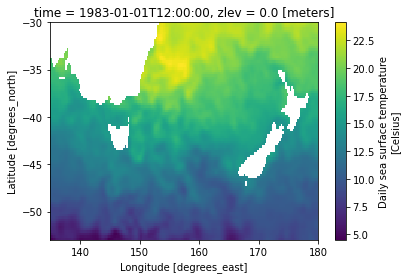

In [153]:
sst.isel(time=0).plot()

In [204]:
control_mean = control.sel(latitude=slice(-53, -30), longitude=slice(135, 180)).mean(dim='time')

In [148]:
control_mean

<xarray.DataArray 'ts_0' (latitude: 46, longitude: 90)>
dask.array<mean_agg-aggregate, shape=(46, 90), dtype=float32, chunksize=(46, 90), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -31.25 -30.75 -30.25
    height     float64 10.0

In [208]:
sst_z = sst.mean(dim='zlev')
sst_z

<xarray.DataArray 'sst' (time: 10958, lat: 92, lon: 180)>
dask.array<mean_agg-aggregate, shape=(10958, 92, 180), dtype=float32, chunksize=(366, 92, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01T12:00:00 ... 2012-12-31T12:00:00
  * lon      (lon) float32 135.1 135.4 135.6 135.9 ... 179.1 179.4 179.6 179.9
  * lat      (lat) float32 -52.88 -52.62 -52.38 -52.12 ... -30.62 -30.38 -30.12

In [211]:
sst_r = sst_z.rename({'lon': 'longitude','lat': 'latitude'}) 
sst_r.mean(dim='time')

<xarray.DataArray 'sst' (latitude: 92, longitude: 180)>
dask.array<mean_agg-aggregate, shape=(92, 180), dtype=float32, chunksize=(92, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.1 135.4 135.6 135.9 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -52.88 -52.62 -52.38 ... -30.62 -30.38 -30.12

In [159]:
model_input_sst = xr.open_dataset('/g/data/e14/cp3790/Charuni/MHW-sev/tasman-clim-extrap.nc')
model_input_sst

<xarray.Dataset>
Dimensions:   (month: 12, lat: 50, lon: 110)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    time      datetime64[ns] ...
  * lon       (lon) float64 135.2 135.8 136.2 136.8 ... 188.2 188.8 189.2 189.8
  * lat       (lat) float64 -52.75 -52.25 -51.75 -51.25 ... -29.25 -28.75 -28.25
Data variables:
    sst-clim  (month, lat, lon) float64 ...
    mask      (lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [165]:
sst_clim = model_input_sst['sst-clim'].sel(lat=slice(-53, -30), lon=slice(135, 180))

In [166]:
sst_clim

<xarray.DataArray 'sst-clim' (month: 12, lat: 46, lon: 90)>
array([[[ 6.45165 ,  6.496811, ...,  9.092827,  9.180397],
        [ 6.806254,  6.849012, ...,  9.324169,  9.41182 ],
        ...,
        [20.90221 , 21.497196, ..., 22.457914, 22.439771],
        [21.34105 , 21.505309, ..., 22.76645 , 22.748598]],

       [[ 6.619329,  6.574153, ...,  9.353619,  9.437847],
        [ 6.977365,  6.928484, ...,  9.626357,  9.692145],
        ...,
        [21.156925, 21.757697, ..., 23.033537, 23.008034],
        [21.623627, 21.76629 , ..., 23.332929, 23.340513]],

       ...,

       [[ 5.157196,  5.115269, ...,  7.122198,  7.197404],
        [ 5.605097,  5.572196, ...,  7.260587,  7.330402],
        ...,
        [18.265443, 18.678981, ..., 19.626119, 19.635543],
        [18.520919, 18.684366, ..., 20.020782, 20.025448]],

       [[ 5.883066,  5.916802, ...,  8.142811,  8.227915],
        [ 6.330149,  6.36352 , ...,  8.325691,  8.399447],
        ...,
        [19.786119, 20.31706 , ..., 21.222313, 21.189589],
        [20.155659, 20.324055, ..., 21.566221, 21.505951]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    time     datetime64[ns] 1981-09-01
  * lon      (lon) float64 135.2 135.8 136.2 136.8 ... 178.2 178.8 179.2 179.8
  * lat      (lat) float64 -52.75 -52.25 -51.75 -51.25 ... -31.25 -30.75 -30.25

In [170]:
(sst_clim.mean(dim='month'))

<xarray.DataArray 'sst-clim' (lat: 46, lon: 90)>
array([[ 5.43504553,  5.40666792,  5.36777092, ...,  7.44880498,
         7.52306745,  7.61854267],
       [ 5.82335481,  5.792381  ,  5.73803203, ...,  7.64330122,
         7.69247168,  7.77085524],
       [ 6.18340675,  6.16478628,  6.10998416, ...,  7.7477884 ,
         7.79649468,  7.86413159],
       ...,
       [17.57993226, 17.79079412, 18.0193508 , ..., 19.93490454,
        19.91880114, 19.91283457],
       [17.60786137, 17.85295477, 18.01893664, ..., 20.2479559 ,
        20.22784238, 20.21384398],
       [17.77543887, 17.85642385, 18.01809539, ..., 20.57984354,
        20.57150915, 20.56494598]])
Coordinates:
    time     datetime64[ns] 1981-09-01
  * lon      (lon) float64 135.2 135.8 136.2 136.8 ... 178.2 178.8 179.2 179.8
  * lat      (lat) float64 -52.75 -52.25 -51.75 -51.25 ... -31.25 -30.75 -30.25

In [174]:
sst_r = sst_z.rename({'longitude': 'lon','latitude': 'lat'}) 

sst_r.mean(dim='time')

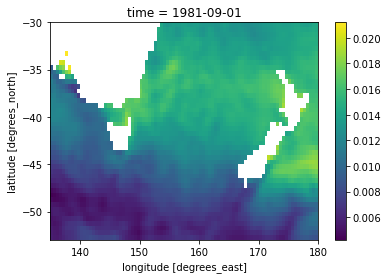

In [177]:
(sst_clim.mean(dim='month') - sst_r.mean(dim='time')).plot()

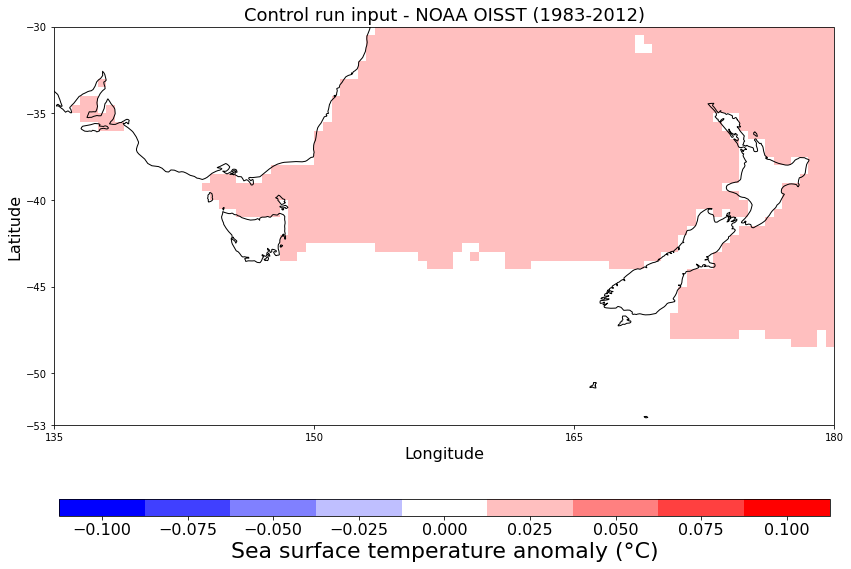

In [189]:
## mean bias (control input - noaa)

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im = (sst_clim.mean(dim='month') - sst_r.mean(dim='time')).plot(
            levels=np.arange(-0.1125, 0.125, 0.025),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 9), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-0.1,0.125,0.025),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Sea surface temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

#mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')
ax.coastlines()

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Control run input - NOAA OISST (1983-2012)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/modelinput-noaa-19832012.png')

In [182]:
## era5 SST 

ds_era5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-SST/era5_sst_1*.nc')
ds2_era5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-SST/era5_sst_2*.nc')
era5 = xr.concat([ds_era5, ds2_era5], dim='time')
era5

<xarray.Dataset>
Dimensions:    (time: 10958, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2012-12-31
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(365, 721, 1440), meta=np.ndarray>

In [186]:
sst = era5.sst.sel(latitude=slice(-30, -53), longitude=slice(135, 180)).mean(dim='time')
sst

<xarray.DataArray 'sst' (latitude: 93, longitude: 180)>
dask.array<mean_agg-aggregate, shape=(93, 180), dtype=float32, chunksize=(93, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -52.5 -52.75 -53.0

In [189]:
ds_era5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M-MEAN/era5_dailytmean_1*.nc')
ds2_era5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M-MEAN/era5_dailytmean_2*.nc')
era5_sat = xr.concat([ds_era5, ds2_era5], dim='time')
era5_sat

<xarray.Dataset>
Dimensions:     (time: 10958, longitude: 1440, latitude: 721)
Coordinates:
  * time        (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2012-12-31
  * longitude   (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude    (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    dailytmean  (time, latitude, longitude) float32 dask.array<chunksize=(365, 721, 1440), meta=np.ndarray>

In [190]:
sat = era5_sat.dailytmean.sel(latitude=slice(-30, -53), longitude=slice(135, 180)).mean(dim='time')
sat

<xarray.DataArray 'dailytmean' (latitude: 93, longitude: 180)>
dask.array<mean_agg-aggregate, shape=(93, 180), dtype=float32, chunksize=(93, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -52.5 -52.75 -53.0

In [192]:
diff = sst - sat
diff

<xarray.DataArray (latitude: 93, longitude: 180)>
dask.array<sub, shape=(93, 180), dtype=float32, chunksize=(93, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.0 135.2 135.5 135.8 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -52.5 -52.75 -53.0

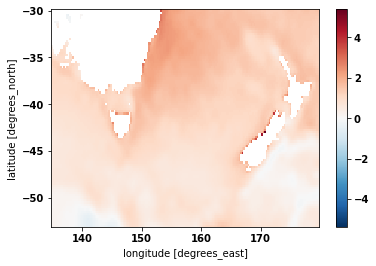

In [193]:
diff.plot()

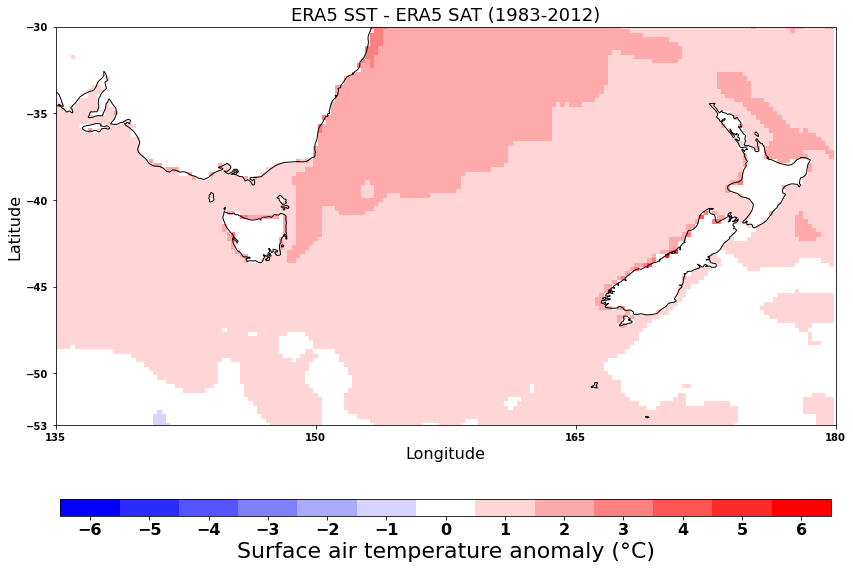

In [199]:
## mean bias (era5 SST - era5 SAT)

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=diff.plot(
            levels=np.arange(-6.5, 7, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 13), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-6, 7, 1),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

#mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')
ax.coastlines()

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('ERA5 SST - ERA5 SAT (1983-2012)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5sst-sat-19832012.png')

In [188]:
ds_era5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-SST/era5_sst_remap_*.nc')

In [199]:
era5_sst = (ds_era5['sst']-273.15).sel(lat=slice(-53, -30), lon=slice(135, 180))

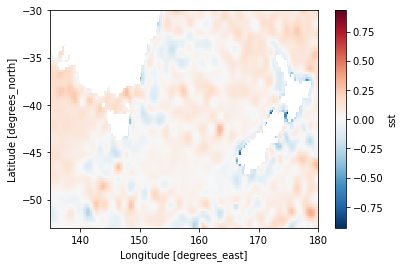

In [200]:
(era5_sst.mean(dim='time') - sst.mean(dim='time')).plot()

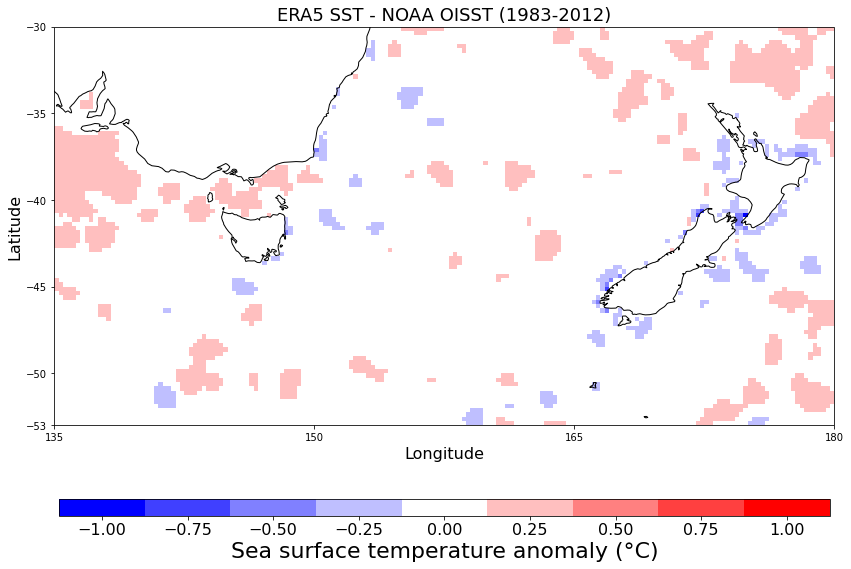

In [203]:
## mean bias (era5-noaa)

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=(era5_sst.mean(dim='time') - sst.mean(dim='time')).plot(
            levels=np.arange(-1.125, 1.25, 0.25),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 9), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-1,1.25,0.25),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Sea surface temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

#mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')
ax.coastlines()

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('ERA5 SST - NOAA OISST (1983-2012)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5-noaa-19832012.png')

In [206]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M-MEAN/era5_dailytmean_remapnoaa_*.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 10958, lon: 360, lat: 240)
Coordinates:
  * time        (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2012-12-31
  * lon         (lon) float32 90.12 90.38 90.62 90.88 ... 179.4 179.6 179.9
  * lat         (lat) float32 -59.88 -59.62 -59.38 ... -0.625 -0.375 -0.125
Data variables:
    dailytmean  (time, lat, lon) float32 dask.array<chunksize=(365, 240, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 14 16:08:22 2022: cdo -remapbil,grid_noaa.txt /g/da...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [207]:
era5_sat = (ds['dailytmean']-273.15).sel(lat=slice(-53, -30), lon=slice(135, 180))

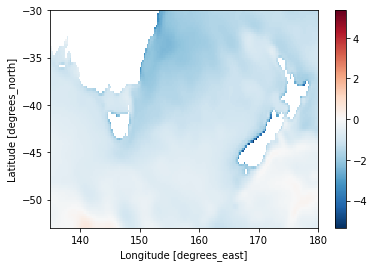

In [208]:
(era5_sat.mean(dim='time') - sst.mean(dim='time')).plot()

In [ ]:
## mean bias (era5 sat-noaa)

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=(era5_sat.mean(dim='time') - sst.mean(dim='time')).plot(
            levels=np.arange(-1.125, 1.25, 0.25),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 9), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-1,1.25,0.25),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Sea surface temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

#mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')
ax.coastlines()

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('ERA5 SST - NOAA OISST (1983-2012)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5-noaa-19832012.png')

In [120]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M-MEAN/era5_dailytmean_remap_*.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 14244, longitude: 110, latitude: 50)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
  * longitude   (longitude) float32 135.2 135.8 136.2 ... 188.8 189.2 189.8
  * latitude    (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
Data variables:
    dailytmean  (time, latitude, longitude) float32 dask.array<chunksize=(365, 50, 110), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Feb 09 17:30:10 2022: cdo -remapbil,ens_grid.txt /g/dat...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

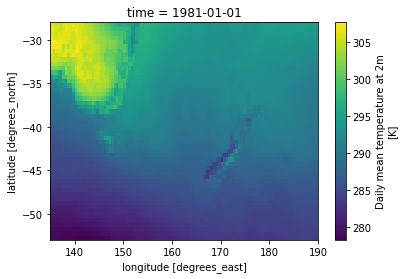

In [181]:
era5.isel(time=0).plot()

In [ ]:
con_1981 = (ds_1980['ts_0']-273.15).sel(time=slice('1981-06-01', '1982-06-30'))

In [129]:
era5_1981 = (ds['dailytmean']-273.15).sel(time=slice('1981-06-01', '1982-06-30')).resample(time='MS').mean()
era5_1982 = (ds['dailytmean']-273.15).sel(time=slice('1982-06-01', '1983-06-30')).resample(time='MS').mean() 
era5_1983 = (ds['dailytmean']-273.15).sel(time=slice('1983-06-01', '1984-06-30')).resample(time='MS').mean() 
era5_1984 = (ds['dailytmean']-273.15).sel(time=slice('1984-06-01', '1985-06-30')).resample(time='MS').mean() 
era5_1985 = (ds['dailytmean']-273.15).sel(time=slice('1985-06-01', '1986-06-30')).resample(time='MS').mean() 
era5_1986 = (ds['dailytmean']-273.15).sel(time=slice('1986-06-01', '1987-06-30')).resample(time='MS').mean() 
era5_1987 = (ds['dailytmean']-273.15).sel(time=slice('1987-06-01', '1988-06-30')).resample(time='MS').mean() 
era5_1988 = (ds['dailytmean']-273.15).sel(time=slice('1988-06-01', '1989-06-30')).resample(time='MS').mean() 
era5_1989 = (ds['dailytmean']-273.15).sel(time=slice('1989-06-01', '1990-06-30')).resample(time='MS').mean() 
era5_1990 = (ds['dailytmean']-273.15).sel(time=slice('1990-06-01', '1991-06-30')).resample(time='MS').mean() 
era5_1991 = (ds['dailytmean']-273.15).sel(time=slice('1991-06-01', '1992-06-30')).resample(time='MS').mean() 
era5_1992 = (ds['dailytmean']-273.15).sel(time=slice('1992-06-01', '1993-06-30')).resample(time='MS').mean() 
era5_1993 = (ds['dailytmean']-273.15).sel(time=slice('1993-06-01', '1994-06-30')).resample(time='MS').mean() 
era5_1994 = (ds['dailytmean']-273.15).sel(time=slice('1994-06-01', '1995-06-30')).resample(time='MS').mean() 
era5_1996 = (ds['dailytmean']-273.15).sel(time=slice('1996-06-01', '1997-06-30')).resample(time='MS').mean() 
era5_1997 = (ds['dailytmean']-273.15).sel(time=slice('1997-06-01', '1998-06-30')).resample(time='MS').mean() 
era5_1998 = (ds['dailytmean']-273.15).sel(time=slice('1998-06-01', '1999-06-30')).resample(time='MS').mean() 
era5_2000 = (ds['dailytmean']-273.15).sel(time=slice('2000-06-01', '2001-06-30')).resample(time='MS').mean() 
era5_2001 = (ds['dailytmean']-273.15).sel(time=slice('2001-06-01', '2002-06-30')).resample(time='MS').mean() 
era5_2002 = (ds['dailytmean']-273.15).sel(time=slice('2002-06-01', '2003-06-30')).resample(time='MS').mean() 
era5_2003 = (ds['dailytmean']-273.15).sel(time=slice('2003-06-01', '2004-06-30')).resample(time='MS').mean() 
era5_2004 = (ds['dailytmean']-273.15).sel(time=slice('2004-06-01', '2005-06-30')).resample(time='MS').mean() 
era5_2005 = (ds['dailytmean']-273.15).sel(time=slice('2005-06-01', '2006-06-30')).resample(time='MS').mean() 
era5_2006 = (ds['dailytmean']-273.15).sel(time=slice('2006-06-01', '2007-06-30')).resample(time='MS').mean() 
era5_2007 = (ds['dailytmean']-273.15).sel(time=slice('2007-06-01', '2008-06-30')).resample(time='MS').mean() 
era5_2008 = (ds['dailytmean']-273.15).sel(time=slice('2008-06-01', '2009-06-30')).resample(time='MS').mean() 
era5_2009 = (ds['dailytmean']-273.15).sel(time=slice('2009-06-01', '2010-06-30')).resample(time='MS').mean() 
era5_2010 = (ds['dailytmean']-273.15).sel(time=slice('2010-06-01', '2011-06-30')).resample(time='MS').mean() 
era5_2011 = (ds['dailytmean']-273.15).sel(time=slice('2011-06-01', '2012-06-30')).resample(time='MS').mean() 
era5_2012 = (ds['dailytmean']-273.15).sel(time=slice('2012-06-01', '2013-06-30')).resample(time='MS').mean() 
era5_2013 = (ds['dailytmean']-273.15).sel(time=slice('2013-06-01', '2014-06-30')).resample(time='MS').mean() 
era5_2014 = (ds['dailytmean']-273.15).sel(time=slice('2014-06-01', '2015-06-30')).resample(time='MS').mean() 
era5_2015 = (ds['dailytmean']-273.15).sel(time=slice('2015-06-01', '2016-06-30')).resample(time='MS').mean() 
era5_2016 = (ds['dailytmean']-273.15).sel(time=slice('2016-06-01', '2017-06-30')).resample(time='MS').mean() 
era5_2017 = (ds['dailytmean']-273.15).sel(time=slice('2017-06-01', '2018-06-30')).resample(time='MS').mean() 
era5_2018 = (ds['dailytmean']-273.15).sel(time=slice('2018-06-01', '2019-06-30')).resample(time='MS').mean() 

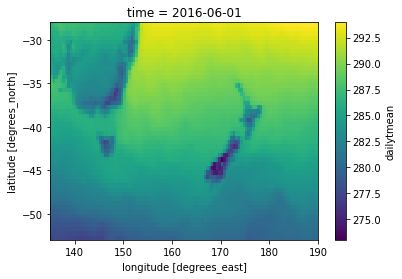

In [197]:
era5_mon.isel(time=12).plot()

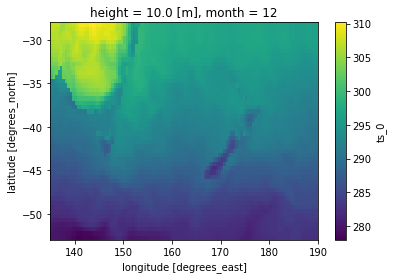

In [282]:
ts_2015.groupby('time.month').mean().isel(month=11).plot()

In [274]:
# diff1 = ensemble 1 - obs

eval_2015 = ts_2015.groupby("time.month").mean() - dailytmean_mon.groupby("time.month").mean()

In [272]:
eval_1981

<xarray.DataArray (month: 12, latitude: 50, longitude: 110)>
dask.array<subtract, shape=(12, 50, 110), dtype=float32, chunksize=(1, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

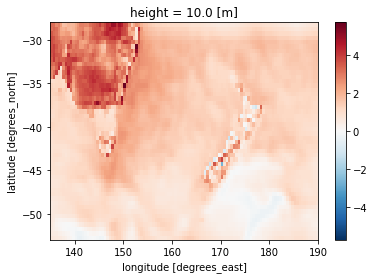

In [275]:
eval_2015.mean(dim='month').plot()

In [ ]:
dailytmean_mon.groupby("time.month").mean()

In [198]:
eval_1981 = con_1981.groupby("time.month").mean() - era5_1981.groupby("time.month").mean()

In [130]:
eval_1981 = con_1981.groupby("time.month").mean() - era5_1981.groupby("time.month").mean()
eval_1982 = (con_1982.groupby("time.month").mean() - era5_1982.groupby("time.month").mean())
eval_1983 = (con_1983.groupby("time.month").mean() - era5_1983.groupby("time.month").mean())
eval_1984 = (con_1984.groupby("time.month").mean() - era5_1984.groupby("time.month").mean())
eval_1985 = (con_1985.groupby("time.month").mean() - era5_1985.groupby("time.month").mean())
eval_1986 = (con_1986.groupby("time.month").mean() - era5_1986.groupby("time.month").mean())
eval_1987 = (con_1987.groupby("time.month").mean() - era5_1987.groupby("time.month").mean())
eval_1988 = (con_1988.groupby("time.month").mean() - era5_1988.groupby("time.month").mean())
eval_1989 = (con_1989.groupby("time.month").mean() - era5_1989.groupby("time.month").mean())
eval_1990 = (con_1990.groupby("time.month").mean() - era5_1990.groupby("time.month").mean())
eval_1991 = (con_1991.groupby("time.month").mean() - era5_1991.groupby("time.month").mean())
eval_1992 = (con_1992.groupby("time.month").mean() - era5_1992.groupby("time.month").mean())
eval_1993 = (con_1993.groupby("time.month").mean() - era5_1993.groupby("time.month").mean())
eval_1994 = (con_1994.groupby("time.month").mean() - era5_1994.groupby("time.month").mean())
eval_1996 = (con_1996.groupby("time.month").mean() - era5_1996.groupby("time.month").mean())
eval_1997 = (con_1997.groupby("time.month").mean() - era5_1997.groupby("time.month").mean())
eval_1998 = (con_1998.groupby("time.month").mean() - era5_1998.groupby("time.month").mean())
eval_2000 = (con_2000.groupby("time.month").mean() - era5_2000.groupby("time.month").mean())
eval_2001 = (con_2001.groupby("time.month").mean() - era5_2001.groupby("time.month").mean())
eval_2002 = (con_2002.groupby("time.month").mean() - era5_2002.groupby("time.month").mean())
eval_2003 = (con_2003.groupby("time.month").mean() - era5_2003.groupby("time.month").mean())
eval_2004 = (con_2004.groupby("time.month").mean() - era5_2004.groupby("time.month").mean())
eval_2005 = (con_2005.groupby("time.month").mean() - era5_2005.groupby("time.month").mean())
eval_2006 = (con_2006.groupby("time.month").mean() - era5_2006.groupby("time.month").mean())
eval_2007 = (con_2007.groupby("time.month").mean() - era5_2007.groupby("time.month").mean())
eval_2008 = (con_2008.groupby("time.month").mean() - era5_2008.groupby("time.month").mean())
eval_2009 = (con_2009.groupby("time.month").mean() - era5_2009.groupby("time.month").mean())
eval_2010 = (con_2010.groupby("time.month").mean() - era5_2010.groupby("time.month").mean())
eval_2011 = (con_2011.groupby("time.month").mean() - era5_2011.groupby("time.month").mean())
eval_2012 = (con_2012.groupby("time.month").mean() - era5_2012.groupby("time.month").mean())
eval_2013 = (con_2013.groupby("time.month").mean() - era5_2013.groupby("time.month").mean())
eval_2014 = (con_2014.groupby("time.month").mean() - era5_2014.groupby("time.month").mean())
eval_2015 = (con_2015.groupby("time.month").mean() - era5_2015.groupby("time.month").mean())
eval_2016 = (con_2016.groupby("time.month").mean() - era5_2016.groupby("time.month").mean())
eval_2017 = (con_2017.groupby("time.month").mean() - era5_2017.groupby("time.month").mean())
eval_2018 = (con_2018.groupby("time.month").mean() - era5_2018.groupby("time.month").mean())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [131]:
eval_ts_mean = xr.concat([eval_2018, eval_2017, eval_2016, eval_2015, eval_2014, eval_2013, eval_2012, eval_2011, eval_2010, 
                 eval_2009, eval_2008, eval_2007, eval_2006, eval_2005, eval_2004, eval_2003, eval_2002, eval_2001,
                 eval_2000, eval_1998, eval_1997, eval_1996, eval_1994, eval_1993, eval_1992, eval_1991, eval_1990,
                 eval_1989, eval_1988, eval_1987, eval_1986, eval_1985, eval_1984, eval_1983, eval_1982, eval_1981], dim='time').mean(dim='month')

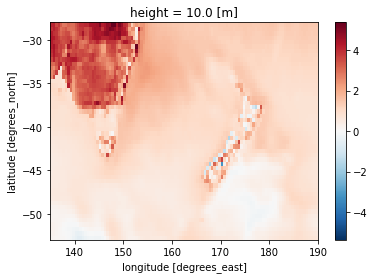

In [132]:
eval_ts_mean.mean(dim='time').plot()

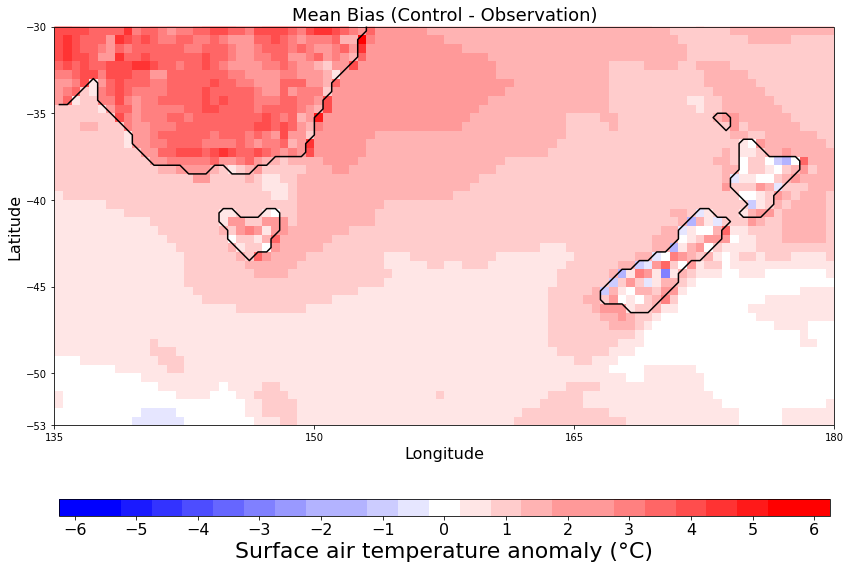

In [135]:
## mean bias


fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

im=eval_ts_mean.mean(dim='time').plot(
            levels=np.arange(-6.25, 6.5, 0.5),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 21), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-6,6.5,1),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')


plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Mean Bias (Control - Observation)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/mean-bias-control.png')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


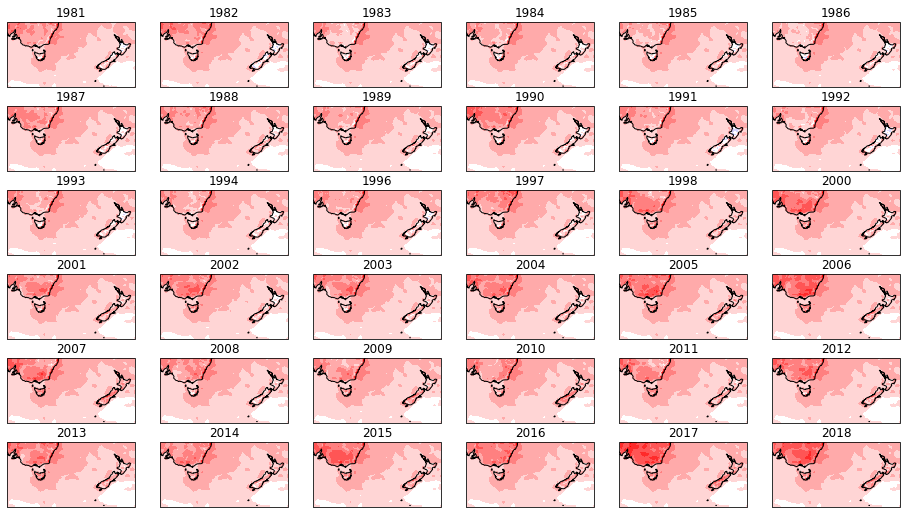

In [293]:
## new eval plot (monthly groupby)

def multiple_plots():
    nrow = 6
    ncol = 6
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data_years_descending = [eval_2018, eval_2017, eval_2016, eval_2015, eval_2014, eval_2013, eval_2012, eval_2011, eval_2010, 
                 eval_2009, eval_2008, eval_2007, eval_2006, eval_2005, eval_2004, eval_2003, eval_2002, eval_2001,
                 eval_2000, eval_1998, eval_1997, eval_1996, eval_1994, eval_1993, eval_1992, eval_1991, eval_1990,
                 eval_1989, eval_1988, eval_1987, eval_1986, eval_1985, eval_1984, eval_1983, eval_1982, eval_1981]
    data_years = data_years_descending[::-1]
    
    data_idx = 0
    year = 1981
    for row in range(nrow):
        for col in range(ncol):
            cur_data = data_years[data_idx]
            mean_data = cur_data.mean(dim='month')
            ax[row, col].contourf(
                mean_data.longitude,
                mean_data.latitude,
                mean_data.values,
                levels=np.arange(-6.5, 7, 1),
                add_colorbar=False,
                cmap=plt.cm.get_cmap('bwr', 13), 
            )
            ax[row, col].coastlines()
            ax[row, col].set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(year)
            #ax[row, col].set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
            #ax[row, col].set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree()) 
            
            data_idx += 1
            year += 1
            if year in [1995, 1999]:
                year += 1
            

#     cb = fig.colorbar(
#         im,
#         ax=ax.ravel().tolist(),
#         orientation="horizontal",
#         ticks=np.arange(-2.5,3.0,0.5),
#         fraction=0.035,
#         aspect=45
#     )
#     cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
#     cb.ax.tick_params(labelsize=16)
    # fig.add_subplot(8,1,8)
    #im = data_years[0].mean(dim="month")
    #fig.subplots_adjust(bottom=0.3)
    #cbar_ax = fig.add_axes([0.15, 0.85, 0.7, 0.05])
    #cb = fig.colorbar(im, cax=cbar_ax, orientation="horizontal",ticks=np.arange(-2.5,3.0,0.5),fraction=0.035,aspect=45)
    #cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-2.5,3.0,0.5),fraction=0.035,aspect=45) #,format='%.2f')
    

    #plt.xlabel('Longitude',fontsize=16)
    #plt.ylabel('Latitude', fontsize=16)

    #plt.show()
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/eval_maps.png')
    
multiple_plots()

In [294]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [296]:
ts_mean = xr.concat([ts_2018, ts_2017, ts_2016, ts_2015, ts_2014, ts_2013, ts_2012, ts_2011, ts_2010, 
                 ts_2009, ts_2008, ts_2007, ts_2006, ts_2005, ts_2004, ts_2003, ts_2002, ts_2001,
                 ts_2000, ts_1998, ts_1997, ts_1996, ts_1994, ts_1993, ts_1992, ts_1991, ts_1990,
                 ts_1989, ts_1988, ts_1987, ts_1986, ts_1985, ts_1984, ts_1983, ts_1982, ts_1981], dim='time').mean(dim='time')

In [297]:
ts_mean

<xarray.DataArray 'ts_0' (latitude: 50, longitude: 110)>
array([[278.37823, 278.37515, 278.33902, ..., 281.04062, 280.94232,
        280.82983],
       [278.6566 , 278.6274 , 278.57303, ..., 281.1113 , 281.05228,
        280.9718 ],
       [279.08023, 278.98508, 278.83734, ..., 281.2292 , 281.15738,
        281.09564],
       ...,
       [296.22318, 296.0693 , 296.1465 , ..., 293.43777, 293.43225,
        293.4438 ],
       [296.53815, 296.69055, 296.4335 , ..., 293.47568, 293.44113,
        293.4382 ],
       [296.95627, 297.04984, 296.82773, ..., 293.4776 , 293.46457,
        293.44217]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0

In [301]:
dailytmean_mon.groupby("time.month").mean().mean(dim='month')

<xarray.DataArray 'dailytmean' (latitude: 50, longitude: 110)>
dask.array<mean_agg-aggregate, shape=(50, 110), dtype=float32, chunksize=(50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25

In [302]:
rms = sqrt(mean_squared_error(dailytmean_mon.groupby("time.month").mean().mean(dim='month'), ts_mean))

In [303]:
rms

0.9833960736728355

In [309]:
import xskillscore as xs
from xskillscore import rmse
a = xr.DataArray(np.random.rand(5, 3, 3), dims=['time', 'x', 'y'])
b = xr.DataArray(np.random.rand(5, 3, 3), dims=['time', 'x', 'y'])
xs.rmse(a, b, dim='time')

ModuleNotFoundError: No module named 'xskillscore'

In [307]:
import xskillscore as xs
from xskillscore import rmse
xs.rmse(dailytmean_mon.groupby("time.month").mean().mean(dim='month'), ts_mean), dim='time')

SyntaxError: cannot assign to function call (717546972.py, line 3)

## Difference PDFs

In [8]:
# mean

mean_diff_1981 = diff_1981.mean(dim='time')
mean_diff_1982 = diff_1982.mean(dim='time')
mean_diff_1983 = diff_1983.mean(dim='time')
mean_diff_1984 = diff_1984.mean(dim='time')
mean_diff_1985 = diff_1985.mean(dim='time')
mean_diff_1986 = diff_1986.mean(dim='time')
mean_diff_1987 = diff_1987.mean(dim='time')
mean_diff_1988 = diff_1988.mean(dim='time')
mean_diff_1989 = diff_1989.mean(dim='time')
mean_diff_1990 = diff_1990.mean(dim='time')
mean_diff_1991 = diff_1991.mean(dim='time')
mean_diff_1992 = diff_1992.mean(dim='time')
mean_diff_1993 = diff_1993.mean(dim='time')
mean_diff_1994 = diff_1994.mean(dim='time')
mean_diff_1996 = diff_1996.mean(dim='time')
mean_diff_1997 = diff_1997.mean(dim='time')
mean_diff_1998 = diff_1998.mean(dim='time')
mean_diff_2000 = diff_2000.mean(dim='time')
mean_diff_2001 = diff_2001.mean(dim='time')
mean_diff_2002 = diff_2002.mean(dim='time')
mean_diff_2003 = diff_2003.mean(dim='time')
mean_diff_2004 = diff_2004.mean(dim='time')
mean_diff_2005 = diff_2005.mean(dim='time')
mean_diff_2006 = diff_2006.mean(dim='time')
mean_diff_2007 = diff_2007.mean(dim='time')
mean_diff_2008 = diff_2008.mean(dim='time')
mean_diff_2009 = diff_2009.mean(dim='time')
mean_diff_2010 = diff_2010.mean(dim='time')
mean_diff_2011 = diff_2011.mean(dim='time')
mean_diff_2012 = diff_2012.mean(dim='time')
mean_diff_2013 = diff_2013.mean(dim='time')
mean_diff_2014 = diff_2014.mean(dim='time')
mean_diff_2015 = diff_2015.mean(dim='time')
mean_diff_2016 = diff_2016.mean(dim='time')
mean_diff_2017 = diff_2017.mean(dim='time')
mean_diff_2018 = diff_2018.mean(dim='time')

In [9]:
ensemble_mean_diff = xr.concat([mean_diff_1981, mean_diff_1982, mean_diff_1983, mean_diff_1984, mean_diff_1985, mean_diff_1986, 
                           mean_diff_1987, mean_diff_1988, mean_diff_1989, mean_diff_1990, mean_diff_1991, mean_diff_1992,
                          mean_diff_1993, mean_diff_1994, mean_diff_1996, mean_diff_1997, mean_diff_1998, mean_diff_2000,
                          mean_diff_2001, mean_diff_2002, mean_diff_2003, mean_diff_2004, mean_diff_2005, mean_diff_2006,
                          mean_diff_2007, mean_diff_2008, mean_diff_2009, mean_diff_2010, mean_diff_2011, mean_diff_2012,
                          mean_diff_2013, mean_diff_2014, mean_diff_2015, mean_diff_2016, mean_diff_2017, mean_diff_2018], dim='time')

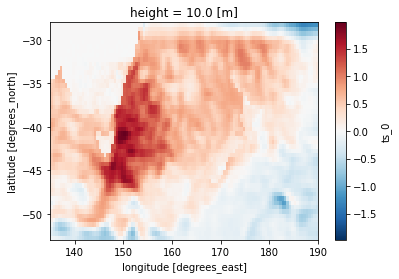

In [42]:
ensemble_mean_diff.isel(time=0).plot()

In [50]:
ensemble_mean_diff

<xarray.DataArray 'ts_0' (time: 36, latitude: 50, longitude: 110)>
dask.array<concatenate, shape=(36, 50, 110), dtype=float32, chunksize=(1, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
Dimensions without coordinates: time

In [93]:
pos = ensemble_mean_diff.where(ensemble_mean_diff>0.05)

In [94]:
pos

<xarray.DataArray 'ts_0' (time: 36, latitude: 50, longitude: 110)>
dask.array<where, shape=(36, 50, 110), dtype=float32, chunksize=(1, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
Dimensions without coordinates: time

In [95]:
count = pos.count(dim='time')

In [96]:
count

<xarray.DataArray 'ts_0' (latitude: 50, longitude: 110)>
dask.array<sum-aggregate, shape=(50, 110), dtype=int64, chunksize=(50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0

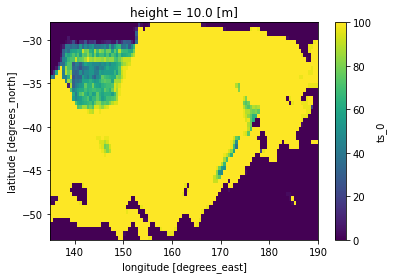

In [75]:
((count/36)*100).plot()

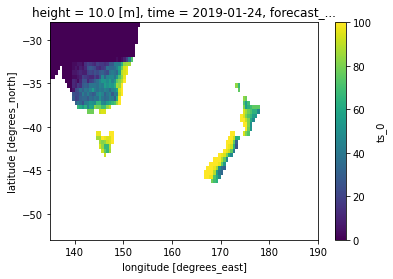

In [97]:
((count/36)*100).where(mask).plot()

In [82]:
((count/36)*100).where(mask)

<xarray.DataArray 'ts_0' (latitude: 50, longitude: 110, time: 1)>
dask.array<where, shape=(50, 110, 1), dtype=float64, chunksize=(50, 110, 1), chunktype=numpy.ndarray>
Coordinates:
  * longitude                (longitude) float32 135.2 135.8 ... 189.2 189.8
  * latitude                 (latitude) float32 -52.75 -52.25 ... -28.75 -28.25
    height                   float64 10.0
  * time                     (time) datetime64[ns] 2019-01-24
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...

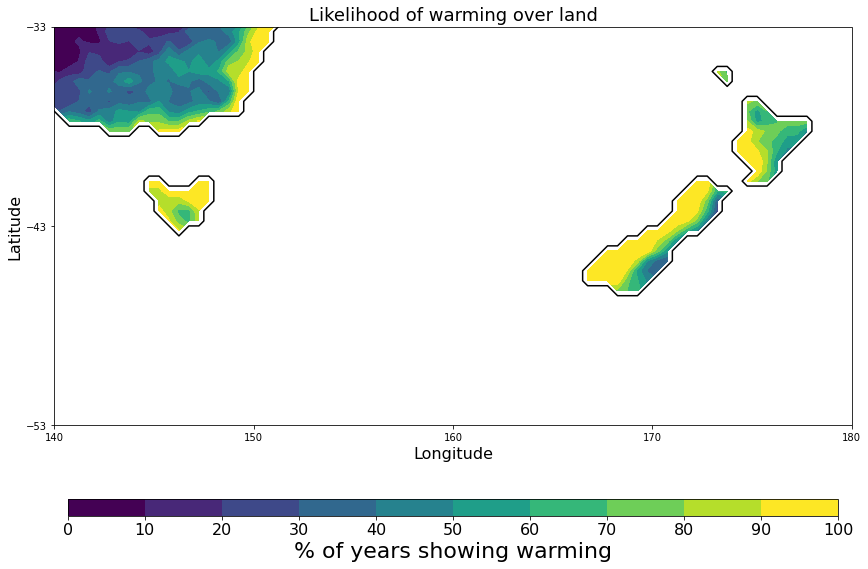

In [98]:
## one sample t test 

fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([140, 180, -53, -33],crs=ccrs.PlateCarree())    

ax.set_xticks([140, 150, 160, 170, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -43, -33], crs=ccrs.PlateCarree())

im=((count/36)*100).where(mask).mean(dim='time').plot.contourf(
            levels=np.arange(0, 110, 10),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('viridis', 10), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(0,110,10),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'% of years showing warming', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Likelihood of warming over land', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/likelihood2.png')

In [62]:
ds = ensemble_mean_diff.to_dataset(dim='time')

In [65]:
ds.map(lambda x: print(x))

<xarray.DataArray 0 (latitude: 50, longitude: 110)>
dask.array<getitem, shape=(50, 110), dtype=float32, chunksize=(50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
<xarray.DataArray 1 (latitude: 50, longitude: 110)>
dask.array<getitem, shape=(50, 110), dtype=float32, chunksize=(50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
    height     float64 10.0
<xarray.DataArray 2 (latitude: 50, longitude: 110)>
dask.array<getitem, shape=(50, 110), dtype=float32, chunksize=(50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.

<xarray.Dataset>
Dimensions:  ()
Data variables: (12/36)
    0        object None
    1        object None
    2        object None
    3        object None
    4        object None
    5        object None
    ...       ...
    30       object None
    31       object None
    32       object None
    33       object None
    34       object None
    35       object None

In [46]:
# select a certain lat, lon

grid_diff_1981 = diff_1981.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1982 = diff_1982.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1983 = diff_1983.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1984 = diff_1984.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1985 = diff_1985.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1986 = diff_1986.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1987 = diff_1987.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1988 = diff_1988.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1989 = diff_1989.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1990 = diff_1990.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1991 = diff_1991.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1992 = diff_1992.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1993 = diff_1993.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1994 = diff_1994.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1996 = diff_1996.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1997 = diff_1997.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_1998 = diff_1998.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2000 = diff_2000.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2001 = diff_2001.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2002 = diff_2002.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2003 = diff_2003.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2004 = diff_2004.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2005 = diff_2005.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2006 = diff_2006.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2007 = diff_2007.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2008 = diff_2008.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2009 = diff_2009.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2010 = diff_2010.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2011 = diff_2011.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2012 = diff_2012.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2013 = diff_2013.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2014 = diff_2014.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2015 = diff_2015.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2016 = diff_2016.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2017 = diff_2017.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')
grid_diff_2018 = diff_2018.sel(latitude=-42.8, longitude=147.4, method='nearest').mean(dim='time')

In [47]:
# single grid point 

ensemble_grid_diff = xr.concat([grid_diff_1981, grid_diff_1982, grid_diff_1983, grid_diff_1984, grid_diff_1985, grid_diff_1986, 
                           grid_diff_1987, grid_diff_1988, grid_diff_1989, grid_diff_1990, grid_diff_1991, grid_diff_1992,
                          grid_diff_1993, grid_diff_1994, grid_diff_1996, grid_diff_1997, grid_diff_1998, grid_diff_2000,
                          grid_diff_2001, grid_diff_2002, grid_diff_2003, grid_diff_2004, grid_diff_2005, grid_diff_2006,
                          grid_diff_2007, grid_diff_2008, grid_diff_2009, grid_diff_2010, grid_diff_2011, grid_diff_2012,
                          grid_diff_2013, grid_diff_2014, grid_diff_2015, grid_diff_2016, grid_diff_2017, grid_diff_2018], dim='time')

In [48]:
ensemble_grid_diff

<xarray.DataArray 'ts_0' (time: 36)>
dask.array<concatenate, shape=(36,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    longitude  float32 147.2
    latitude   float32 -42.75
    height     float64 10.0
Dimensions without coordinates: time

In [59]:
ensemble_grid_diff.values

array([ 0.10513874,  0.05367837,  0.17953931,  0.17245358,  0.29694924,
        0.13013932,  0.22646618,  0.16633084,  0.11436716,  0.14906065,
        0.20126674,  0.1593442 ,  0.07939173,  0.18470433,  0.09788275,
        0.2175286 ,  0.10469605,  0.05160779,  0.16704544,  0.12490185,
        0.26974168,  0.10247355,  0.07786923, -0.03544631,  0.07072724,
        0.22428949, -0.05249262,  0.10382179, -0.12894846,  0.18308078,
        0.21918719, -0.01785297,  0.24811062,  0.10047003,  0.04471856,
        0.1492007 ], dtype=float32)

In [62]:
ensemble_grid_diff.values>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True])

(array([1., 1., 2., 0., 6., 8., 6., 5., 5., 2.]),
 array([-0.12894846, -0.0863587 , -0.04376892, -0.00117915,  0.04141062,
         0.08400039,  0.12659016,  0.16917993,  0.2117697 ,  0.25435945,
         0.29694924], dtype=float32),
 <BarContainer object of 10 artists>)

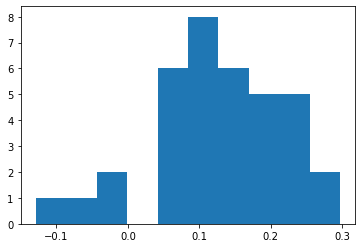

In [49]:
plt.hist(ensemble_grid_diff)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 

plt.hist(ensemble_grid_diff.mean(dim='rnd'))

plt.ylabel('Frequency', fontsize=16)
fig.suptitle('Distribution of difference between ensemble and control mean \nat lat=-42.75, lon=147.2', fontsize=18)
plt.xticks(np.arange(-0.3, 0.4, 0.1))
plt.xlabel('Difference', fontsize=16)
ax.tick_params(labelsize='x-large')

plt.ylim(ymin=0)
plt.xlim(-0.3, 0.4)

plt.axvline(ensemble_grid_diff.mean(dim='rnd').mean(dim='time'), color='purple')

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/ensemble-control-diff-landgrid-hob-pdf.png')

#plt.show()

<AxesSubplot:ylabel='Count'>

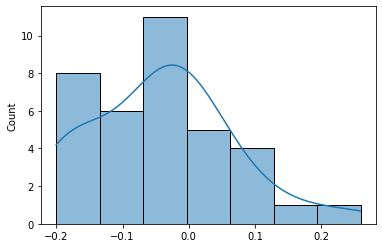

In [45]:
sns.histplot(data=ensemble_diff, kde=True)

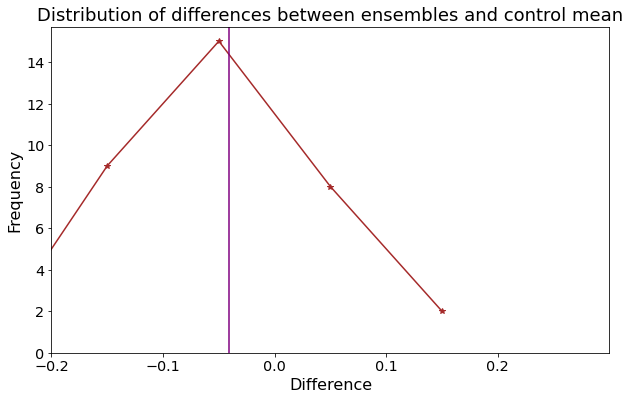

In [49]:
fig, ax = plt.subplots(figsize=(10,6)) 

bins_n=np.arange(-0.3, 0.3, 0.1)

y1,edges1 = np.histogram(ensemble_diff, bins_n)

centers1 = 0.5*(edges1[1:]+ edges1[:-1])

plt.plot(centers1,y1,'-*', color='brown')

#plt.legend(fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of differences between ensembles and control mean', fontsize=18)
plt.xticks(np.arange(-0.2, 0.3, 0.1))
plt.xlabel('Difference', fontsize=16)
ax.tick_params(labelsize='x-large')

plt.ylim(ymin=0)
plt.xlim(-0.2, 0.3)

plt.axvline(ensemble_diff_mean, color='purple')

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/ensemble-control-diff-pdf.png')

#plt.show()

## MSLP

In [36]:
# MSLP

ds_1981 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1981.nc')
mslp_1981 = ds_1981.air_pressure_at_sea_level/100

ds_1982= xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1982.nc')
mslp_1982 = ds_1982.air_pressure_at_sea_level/100

ds_1983 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1983.nc')
mslp_1983 = ds_1983.air_pressure_at_sea_level/100

ds_1984 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1984.nc')
mslp_1984 = ds_1984.air_pressure_at_sea_level/100

ds_1985 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1985.nc')
mslp_1985 = ds_1985.air_pressure_at_sea_level/100

ds_1986 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1986.nc')
mslp_1986 = ds_1986.air_pressure_at_sea_level/100

ds_1987 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1987.nc')
mslp_1987 = ds_1987.air_pressure_at_sea_level/100

ds_1988 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1988.nc')
mslp_1988 = ds_1988.air_pressure_at_sea_level/100

ds_1989 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1989.nc')
mslp_1989 = ds_1989.air_pressure_at_sea_level/100

ds_1990 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1990.nc')
mslp_1990 = ds_1990.air_pressure_at_sea_level/100

ds_1991 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1991.nc')
mslp_1991 = ds_1991.air_pressure_at_sea_level/100

ds_1992 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1992.nc')
mslp_1992 = ds_1992.air_pressure_at_sea_level/100

ds_1993 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1993.nc')
mslp_1993 = ds_1993.air_pressure_at_sea_level/100

ds_1994 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1994.nc')
mslp_1994 = ds_1994.air_pressure_at_sea_level/100

ds_1996 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1996.nc')
mslp_1996 = ds_1996.air_pressure_at_sea_level/100

ds_1997 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1997.nc')
mslp_1997 = ds_1997.air_pressure_at_sea_level/100

ds_1998 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1998.nc')
mslp_1998 = ds_1998.air_pressure_at_sea_level/100

ds_2000 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2000.nc')
mslp_2000 = ds_2000.air_pressure_at_sea_level/100

ds_2001 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2001.nc')
mslp_2001 = ds_2001.air_pressure_at_sea_level/100

ds_2002 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2002.nc')
mslp_2002 = ds_2002.air_pressure_at_sea_level/100

ds_2003 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2003.nc')
mslp_2003 = ds_2003.air_pressure_at_sea_level/100

ds_2004 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2004.nc')
mslp_2004 = ds_2004.air_pressure_at_sea_level/100

ds_2005 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2005.nc')
mslp_2005 = ds_2005.air_pressure_at_sea_level/100

ds_2006 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2006.nc')
mslp_2006 = ds_2006.air_pressure_at_sea_level/100

ds_2007 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2007.nc')
mslp_2007 = ds_2007.air_pressure_at_sea_level/100

ds_2008 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2008.nc')
mslp_2008 = ds_2008.air_pressure_at_sea_level/100

ds_2009 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2009.nc')
mslp_2009 = ds_2009.air_pressure_at_sea_level/100

ds_2010 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2010.nc')
mslp_2010 = ds_2010.air_pressure_at_sea_level/100

ds_2011 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2011.nc')
mslp_2011 = ds_2011.air_pressure_at_sea_level/100

ds_2012 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2012.nc')
mslp_2012 = ds_2012.air_pressure_at_sea_level/100

ds_2013 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2013.nc')
mslp_2013 = ds_2013.air_pressure_at_sea_level/100

ds_2014 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2014.nc')
mslp_2014 = ds_2014.air_pressure_at_sea_level/100

ds_2015 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2015.nc')
mslp_2015 = ds_2015.air_pressure_at_sea_level/100

ds_2016 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2016.nc')
mslp_2016 = ds_2016.air_pressure_at_sea_level/100

ds_2017 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2017.nc')
mslp_2017 = ds_2017.air_pressure_at_sea_level/100

ds_2018 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2018.nc')
mslp_2018 = ds_2018.air_pressure_at_sea_level/100

In [37]:
ds_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pverb_*.nc')
ds_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pverb_*.nc')
ds_2019 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-2019/um_pverb_*.nc')

In [38]:
con_mslp_1981 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1981-06-01', '1982-06-30'))
con_mslp_1982 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1982-06-01', '1983-06-30')) 
con_mslp_1983 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1983-06-01', '1984-06-30')) 
con_mslp_1984 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1984-06-01', '1985-06-30')) 
con_mslp_1985 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1985-06-01', '1986-06-30')) 
con_mslp_1986 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1986-06-01', '1987-06-30')) 
con_mslp_1987 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1987-06-01', '1988-06-30')) 
con_mslp_1988 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1988-06-01', '1989-06-30')) 
con_mslp_1989 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1989-06-01', '1990-06-30')) 
con_mslp_1990 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1990-06-01', '1991-06-30')) 
con_mslp_1991 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1991-06-01', '1992-06-30')) 
con_mslp_1992 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1992-06-01', '1993-06-30')) 
con_mslp_1993 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1993-06-01', '1994-06-30')) 
con_mslp_1994 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1994-06-01', '1995-06-30')) 
con_mslp_1996 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1996-06-01', '1997-06-30')) 
con_mslp_1997 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1997-06-01', '1998-06-30')) 
con_mslp_1998 = (ds_1980['air_pressure_at_sea_level']/100).sel(time=slice('1998-06-01', '1999-06-30')) 
con_mslp_2000 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2000-06-01', '2001-06-30')) 
con_mslp_2001 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2001-06-01', '2002-06-30')) 
con_mslp_2002 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2002-06-01', '2003-06-30')) 
con_mslp_2003 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2003-06-01', '2004-06-30')) 
con_mslp_2004 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2004-06-01', '2005-06-30')) 
con_mslp_2005 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2005-06-01', '2006-06-30')) 
con_mslp_2006 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2006-06-01', '2007-06-30')) 
con_mslp_2007 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2007-06-01', '2008-06-30')) 
con_mslp_2008 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2008-06-01', '2009-06-30')) 
con_mslp_2009 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2009-06-01', '2010-06-30')) 
con_mslp_2010 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2010-06-01', '2011-06-30')) 
con_mslp_2011 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2011-06-01', '2012-06-30')) 
con_mslp_2012 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2012-06-01', '2013-06-30')) 
con_mslp_2013 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2013-06-01', '2014-06-30')) 
con_mslp_2014 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2014-06-01', '2015-06-30')) 
con_mslp_2015 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2015-06-01', '2016-06-30')) 
con_mslp_2016 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2016-06-01', '2017-06-30')) 
con_mslp_2017 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2017-06-01', '2018-06-30')) 
con_mslp_2018 = (ds_1999['air_pressure_at_sea_level']/100).sel(time=slice('2018-06-01', '2019-06-30')) 
con_mslp_2019 = (ds_2019['air_pressure_at_sea_level']/100).sel(time=slice('2019-06-01', '2020-06-30')) 

In [39]:
diff_mslp_1981 = mslp_1981.resample(time='1M').mean() - con_mslp_1981.resample(time='1M').mean()
diff_mslp_1982 = (mslp_1982.resample(time='1M').mean() - con_mslp_1982.resample(time='1M').mean())
diff_mslp_1983 = (mslp_1983.resample(time='1M').mean() - con_mslp_1983.resample(time='1M').mean())
diff_mslp_1984 = (mslp_1984.resample(time='1M').mean() - con_mslp_1984.resample(time='1M').mean())
diff_mslp_1985 = (mslp_1985.resample(time='1M').mean() - con_mslp_1985.resample(time='1M').mean())
diff_mslp_1986 = (mslp_1986.resample(time='1M').mean() - con_mslp_1986.resample(time='1M').mean())
diff_mslp_1987 = (mslp_1987.resample(time='1M').mean() - con_mslp_1987.resample(time='1M').mean())
diff_mslp_1988 = (mslp_1988.resample(time='1M').mean() - con_mslp_1988.resample(time='1M').mean())
diff_mslp_1989 = (mslp_1989.resample(time='1M').mean() - con_mslp_1989.resample(time='1M').mean())
diff_mslp_1990 = (mslp_1990.resample(time='1M').mean() - con_mslp_1990.resample(time='1M').mean())
diff_mslp_1991 = (mslp_1991.resample(time='1M').mean() - con_mslp_1991.resample(time='1M').mean())
diff_mslp_1992 = (mslp_1992.resample(time='1M').mean() - con_mslp_1992.resample(time='1M').mean())
diff_mslp_1993 = (mslp_1993.resample(time='1M').mean() - con_mslp_1993.resample(time='1M').mean())
diff_mslp_1994 = (mslp_1994.resample(time='1M').mean() - con_mslp_1994.resample(time='1M').mean())
diff_mslp_1996 = (mslp_1996.resample(time='1M').mean() - con_mslp_1996.resample(time='1M').mean())
diff_mslp_1997 = (mslp_1997.resample(time='1M').mean() - con_mslp_1997.resample(time='1M').mean())
diff_mslp_1998 = (mslp_1998.resample(time='1M').mean() - con_mslp_1998.resample(time='1M').mean())
diff_mslp_2000 = (mslp_2000.resample(time='1M').mean() - con_mslp_2000.resample(time='1M').mean())
diff_mslp_2001 = (mslp_2001.resample(time='1M').mean() - con_mslp_2001.resample(time='1M').mean())
diff_mslp_2002 = (mslp_2002.resample(time='1M').mean() - con_mslp_2002.resample(time='1M').mean())
diff_mslp_2003 = (mslp_2003.resample(time='1M').mean() - con_mslp_2003.resample(time='1M').mean())
diff_mslp_2004 = (mslp_2004.resample(time='1M').mean() - con_mslp_2004.resample(time='1M').mean())
diff_mslp_2005 = (mslp_2005.resample(time='1M').mean() - con_mslp_2005.resample(time='1M').mean())
diff_mslp_2006 = (mslp_2006.resample(time='1M').mean() - con_mslp_2006.resample(time='1M').mean())
diff_mslp_2007 = (mslp_2007.resample(time='1M').mean() - con_mslp_2007.resample(time='1M').mean())
diff_mslp_2008 = (mslp_2008.resample(time='1M').mean() - con_mslp_2008.resample(time='1M').mean())
diff_mslp_2009 = (mslp_2009.resample(time='1M').mean() - con_mslp_2009.resample(time='1M').mean())
diff_mslp_2010 = (mslp_2010.resample(time='1M').mean() - con_mslp_2010.resample(time='1M').mean())
diff_mslp_2011 = (mslp_2011.resample(time='1M').mean() - con_mslp_2011.resample(time='1M').mean())
diff_mslp_2012 = (mslp_2012.resample(time='1M').mean() - con_mslp_2012.resample(time='1M').mean())
diff_mslp_2013 = (mslp_2013.resample(time='1M').mean() - con_mslp_2013.resample(time='1M').mean())
diff_mslp_2014 = (mslp_2014.resample(time='1M').mean() - con_mslp_2014.resample(time='1M').mean())
diff_mslp_2015 = (mslp_2015.resample(time='1M').mean() - con_mslp_2015.resample(time='1M').mean())
diff_mslp_2016 = (mslp_2016.resample(time='1M').mean() - con_mslp_2016.resample(time='1M').mean())
diff_mslp_2017 = (mslp_2017.resample(time='1M').mean() - con_mslp_2017.resample(time='1M').mean())
diff_mslp_2018 = (mslp_2018.resample(time='1M').mean() - con_mslp_2018.resample(time='1M').mean())

In [40]:
diff_mslp_1981 = diff_mslp_1981.rename({'time': 'event_month'})
diff_mslp_1982 = diff_mslp_1982.rename({'time': 'event_month'})
diff_mslp_1983 = diff_mslp_1983.rename({'time': 'event_month'})
diff_mslp_1984 = diff_mslp_1984.rename({'time': 'event_month'})
diff_mslp_1985 = diff_mslp_1985.rename({'time': 'event_month'})
diff_mslp_1986 = diff_mslp_1986.rename({'time': 'event_month'})
diff_mslp_1987 = diff_mslp_1987.rename({'time': 'event_month'})
diff_mslp_1988 = diff_mslp_1988.rename({'time': 'event_month'})
diff_mslp_1989 = diff_mslp_1989.rename({'time': 'event_month'})
diff_mslp_1990 = diff_mslp_1990.rename({'time': 'event_month'})
diff_mslp_1991 = diff_mslp_1991.rename({'time': 'event_month'})
diff_mslp_1992 = diff_mslp_1992.rename({'time': 'event_month'})
diff_mslp_1993 = diff_mslp_1993.rename({'time': 'event_month'})
diff_mslp_1994 = diff_mslp_1994.rename({'time': 'event_month'})
diff_mslp_1996 = diff_mslp_1996.rename({'time': 'event_month'})
diff_mslp_1997 = diff_mslp_1997.rename({'time': 'event_month'})
diff_mslp_1998 = diff_mslp_1998.rename({'time': 'event_month'})
diff_mslp_2000 = diff_mslp_2000.rename({'time': 'event_month'})
diff_mslp_2001 = diff_mslp_2001.rename({'time': 'event_month'})
diff_mslp_2002 = diff_mslp_2002.rename({'time': 'event_month'})
diff_mslp_2003 = diff_mslp_2003.rename({'time': 'event_month'})
diff_mslp_2004 = diff_mslp_2004.rename({'time': 'event_month'})
diff_mslp_2005 = diff_mslp_2005.rename({'time': 'event_month'})
diff_mslp_2006 = diff_mslp_2006.rename({'time': 'event_month'})
diff_mslp_2007 = diff_mslp_2007.rename({'time': 'event_month'})
diff_mslp_2008 = diff_mslp_2008.rename({'time': 'event_month'})
diff_mslp_2009 = diff_mslp_2009.rename({'time': 'event_month'})
diff_mslp_2010 = diff_mslp_2010.rename({'time': 'event_month'})
diff_mslp_2011 = diff_mslp_2011.rename({'time': 'event_month'})
diff_mslp_2012 = diff_mslp_2012.rename({'time': 'event_month'})
diff_mslp_2013 = diff_mslp_2013.rename({'time': 'event_month'})
diff_mslp_2014 = diff_mslp_2014.rename({'time': 'event_month'})
diff_mslp_2015 = diff_mslp_2015.rename({'time': 'event_month'})
diff_mslp_2016 = diff_mslp_2016.rename({'time': 'event_month'})
diff_mslp_2017 = diff_mslp_2017.rename({'time': 'event_month'})
diff_mslp_2018 = diff_mslp_2018.rename({'time': 'event_month'})

In [41]:
diff_mslp_mean = xr.concat([diff_mslp_2018, diff_mslp_2017, diff_mslp_2016, diff_mslp_2015, diff_mslp_2014, diff_mslp_2013, diff_mslp_2012, diff_mslp_2011, diff_mslp_2010, 
                 diff_mslp_2009, diff_mslp_2008, diff_mslp_2007, diff_mslp_2006, diff_mslp_2005, diff_mslp_2004, diff_mslp_2003, diff_mslp_2002, diff_mslp_2001,
                 diff_mslp_2000, diff_mslp_1998, diff_mslp_1997, diff_mslp_1996, diff_mslp_1994, diff_mslp_1993, diff_mslp_1992, diff_mslp_1991, diff_mslp_1990,
                 diff_mslp_1989, diff_mslp_1988, diff_mslp_1987, diff_mslp_1986, diff_mslp_1985, diff_mslp_1984, diff_mslp_1983, diff_mslp_1982, diff_mslp_1981], dim='event_month')

In [57]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

year_mslp_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_mslp_year = globals().get("diff_mslp_{}".format(year))
    if diff_mslp_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_mslp_year.sel(event_month=buildup_slice).mean(dim="event_month")
    peak = diff_mslp_year.sel(event_month=peak_slice).mean(dim="event_month")
    diedown = diff_mslp_year.sel(event_month=diedown_slice).mean(dim="event_month")
    
    diff_mslp_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    year_mslp_phases.append(diff_mslp_year_phase)
    
mslp_year_phases_xr = xr.concat(year_mslp_phases, dim="time")

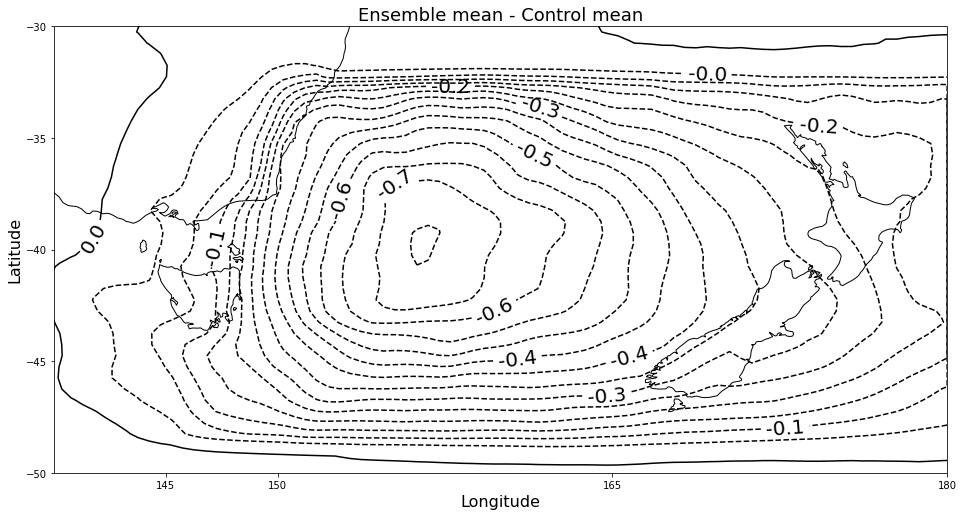

In [46]:
## new diff plot (monthly groupby)


fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([140, 180, -49, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([145, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

ploteo2=year_mslp_phases_xr.isel(phase=0).mean(dim='time').plot.contour(
            colors='k',
            levels=30
        )

ax.clabel(ploteo2, inline=True, fontsize=20, fmt='%1.1f')
ax.coastlines()


plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Ensemble mean - Control mean', fontsize=18)

plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_map_ensemble_control_mslp.png')

## MSLP obs

In [24]:
ds_mslp = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-MSL/msl_anom.nc')

In [25]:
mslp_anom = ds_mslp['msl_anomaly']

In [26]:
mslp_anom_1516 = mslp_anom.sel(time=slice('2015-06-01', '2016-06-30'))
mslp_anom_1516

<xarray.DataArray 'msl_anomaly' (time: 396, latitude: 241, longitude: 360)>
[34356960 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2015-06-01 2015-06-02 ... 2016-06-30
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -59.5 -59.75 -60.0
    dayofyear  (time) int64 ...

In [27]:
mslp_anom_1516_mon = mslp_anom_1516.resample(time='MS').mean()
mslp_anom_1516_mon

<xarray.DataArray 'msl_anomaly' (time: 13, latitude: 241, longitude: 360)>
array([[[ 2.7854207e-01,  2.8935751e-01,  2.9940796e-01, ...,
         -4.9194947e-01, -4.7219035e-01, -4.6061403e-01],
        [ 2.8814495e-01,  2.9856771e-01,  3.1055501e-01, ...,
         -4.9288940e-01, -4.7964886e-01, -4.5730591e-01],
        [ 3.0229086e-01,  3.0950725e-01,  3.2250977e-01, ...,
         -5.0071412e-01, -4.8124185e-01, -4.6740314e-01],
        ...,
        [-4.6097250e+00, -4.6080995e+00, -4.6063213e+00, ...,
         -8.7202778e+00, -8.7646036e+00, -8.8028564e+00],
        [-4.7241087e+00, -4.7268553e+00, -4.7323017e+00, ...,
         -8.7318201e+00, -8.7734432e+00, -8.8159542e+00],
        [-4.8604145e+00, -4.8691344e+00, -4.8768535e+00, ...,
         -8.7468424e+00, -8.7911882e+00, -8.8372946e+00]],

       [[ 8.1120253e-01,  7.9347867e-01,  7.6267368e-01, ...,
          7.9552239e-01,  7.9728454e-01,  7.9492581e-01],
        [ 8.1921977e-01,  7.9664660e-01,  7.7737528e-01, ...,
          8.0216342e-01,  8.0289191e-01,  7.8808200e-01],
        [ 8.2102329e-01,  8.0134827e-01,  7.9219890e-01, ...,
          8.0084032e-01,  7.9470527e-01,  7.8087789e-01],
...
        [-4.0561466e+00, -4.0455008e+00, -4.0402575e+00, ...,
          2.0480680e+00,  2.0793338e+00,  2.1079593e+00],
        [-4.0288815e+00, -4.0114117e+00, -4.0013881e+00, ...,
          2.1995673e+00,  2.2200494e+00,  2.2341211e+00],
        [-4.0046287e+00, -3.9862473e+00, -3.9723492e+00, ...,
          2.3424900e+00,  2.3512514e+00,  2.3563135e+00]],

       [[ 6.2884927e-01,  6.4335126e-01,  6.6588950e-01, ...,
          6.8139851e-01,  6.8916827e-01,  6.9940794e-01],
        [ 6.1195272e-01,  6.1990762e-01,  6.3246053e-01, ...,
          6.7423302e-01,  6.7547810e-01,  6.7943114e-01],
        [ 5.9487915e-01,  5.9711915e-01,  6.0406494e-01, ...,
          6.6119182e-01,  6.6167605e-01,  6.6203815e-01],
        ...,
        [-3.0872865e+00, -3.1008077e+00, -3.1183980e+00, ...,
         -3.2016845e+00, -3.1839254e+00, -3.1542480e+00],
        [-3.2251220e+00, -3.2311118e+00, -3.2426636e+00, ...,
         -3.1840963e+00, -3.1609945e+00, -3.1207254e+00],
        [-3.3446147e+00, -3.3513103e+00, -3.3559163e+00, ...,
         -3.1469278e+00, -3.1088014e+00, -3.0664999e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-06-01 2015-07-01 ... 2016-06-01
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -59.5 -59.75 -60.0

In [30]:
mslp_anom_1516_mon['time'] = pd.to_datetime(mslp_anom_1516_mon['time'])
mslp_anom_1516_mon['Mon_Year'] = mslp_anom_1516_mon['time'].dt.strftime('%b-%Y')
mslp_anom_1516_mon['time'][4].dt.strftime('%b-%Y')

<xarray.DataArray 'strftime' ()>
array('Oct-2015', dtype=object)
Coordinates:
    time      datetime64[ns] 2015-10-01
    Mon_Year  object 'Oct-2015'

In [31]:
mslp_anom_1516_mon

<xarray.DataArray 'msl_anomaly' (time: 13, latitude: 241, longitude: 360)>
array([[[ 2.7854207e-01,  2.8935751e-01,  2.9940796e-01, ...,
         -4.9194947e-01, -4.7219035e-01, -4.6061403e-01],
        [ 2.8814495e-01,  2.9856771e-01,  3.1055501e-01, ...,
         -4.9288940e-01, -4.7964886e-01, -4.5730591e-01],
        [ 3.0229086e-01,  3.0950725e-01,  3.2250977e-01, ...,
         -5.0071412e-01, -4.8124185e-01, -4.6740314e-01],
        ...,
        [-4.6097250e+00, -4.6080995e+00, -4.6063213e+00, ...,
         -8.7202778e+00, -8.7646036e+00, -8.8028564e+00],
        [-4.7241087e+00, -4.7268553e+00, -4.7323017e+00, ...,
         -8.7318201e+00, -8.7734432e+00, -8.8159542e+00],
        [-4.8604145e+00, -4.8691344e+00, -4.8768535e+00, ...,
         -8.7468424e+00, -8.7911882e+00, -8.8372946e+00]],

       [[ 8.1120253e-01,  7.9347867e-01,  7.6267368e-01, ...,
          7.9552239e-01,  7.9728454e-01,  7.9492581e-01],
        [ 8.1921977e-01,  7.9664660e-01,  7.7737528e-01, ...,
          8.0216342e-01,  8.0289191e-01,  7.8808200e-01],
        [ 8.2102329e-01,  8.0134827e-01,  7.9219890e-01, ...,
          8.0084032e-01,  7.9470527e-01,  7.8087789e-01],
...
        [-4.0561466e+00, -4.0455008e+00, -4.0402575e+00, ...,
          2.0480680e+00,  2.0793338e+00,  2.1079593e+00],
        [-4.0288815e+00, -4.0114117e+00, -4.0013881e+00, ...,
          2.1995673e+00,  2.2200494e+00,  2.2341211e+00],
        [-4.0046287e+00, -3.9862473e+00, -3.9723492e+00, ...,
          2.3424900e+00,  2.3512514e+00,  2.3563135e+00]],

       [[ 6.2884927e-01,  6.4335126e-01,  6.6588950e-01, ...,
          6.8139851e-01,  6.8916827e-01,  6.9940794e-01],
        [ 6.1195272e-01,  6.1990762e-01,  6.3246053e-01, ...,
          6.7423302e-01,  6.7547810e-01,  6.7943114e-01],
        [ 5.9487915e-01,  5.9711915e-01,  6.0406494e-01, ...,
          6.6119182e-01,  6.6167605e-01,  6.6203815e-01],
        ...,
        [-3.0872865e+00, -3.1008077e+00, -3.1183980e+00, ...,
         -3.2016845e+00, -3.1839254e+00, -3.1542480e+00],
        [-3.2251220e+00, -3.2311118e+00, -3.2426636e+00, ...,
         -3.1840963e+00, -3.1609945e+00, -3.1207254e+00],
        [-3.3446147e+00, -3.3513103e+00, -3.3559163e+00, ...,
         -3.1469278e+00, -3.1088014e+00, -3.0664999e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-06-01 2015-07-01 ... 2016-06-01
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -59.5 -59.75 -60.0
    Mon_Year   (time) object 'Jun-2015' 'Jul-2015' ... 'May-2016' 'Jun-2016'

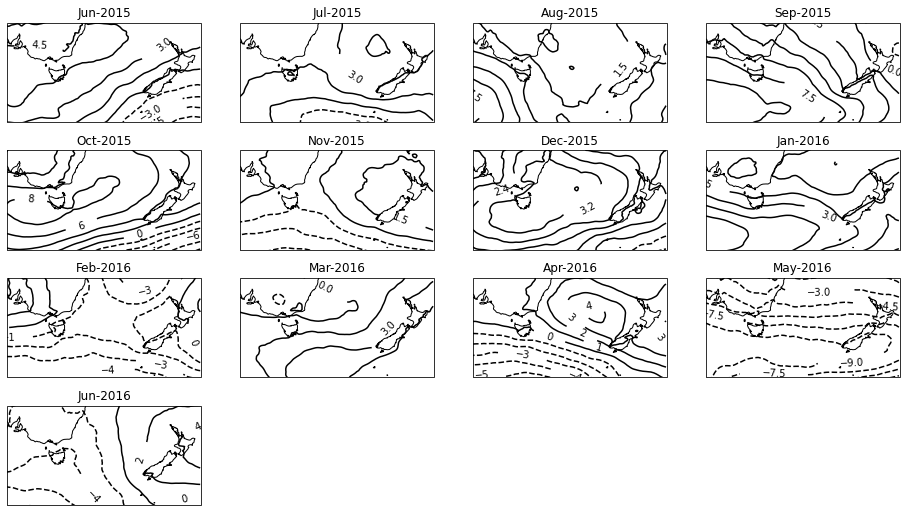

In [33]:
## era5 June 2015-June 2016 

def multiple_plots():
    nrow = 4
    ncol = 4
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    #data = diff_ts_mon_mean
    data2 = mslp_anom_1516_mon
    
    data_idx = 0
    stop_plotting = False
    for row in range(nrow):
        for col in range(ncol):
            #cur_data = data[data_idx]
            #ax[row, col].contourf(
                #cur_data.longitude,
                #cur_data.latitude,
                #cur_data.values,
                #levels=np.arange(-5.25, 5.0, 0.5),
                #add_colorbar=False,
                #cmap=plt.cm.get_cmap('bwr', 11), 
            #)
            cur_data2 = data2[data_idx]
            CS=ax[row, col].contour(
                cur_data2.longitude,
                cur_data2.latitude,
                cur_data2.values,
                levels=10,
                colors='k'
            )
            ax[row, col].clabel(CS, CS.levels, inline=True, fontsize=10)
            ax[row, col].coastlines()
            ax[row, col].set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(cur_data2['Mon_Year'].values.item())
            
            data_idx += 1
            if data_idx > 12:
                stop_plotting = True
                break
        if stop_plotting:
            break

            
    # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise           
    ax_flat = ax.flatten(order='C')
    
                
    # Delete any unused axes from the figure, so that they don't show
    # blank x- and y-axis lines
    for _, axis in enumerate(ax_flat[13:]):
        fig.delaxes(axis) 
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5_mslp_1516_monthly_panels.png')
    

multiple_plots()

In [118]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

mslp_anom_mon['month_name'] = ('month', months)
mslp_anom_mon.swap_dims({'month': 'month_name'})


<xarray.DataArray 'msl_anomaly' (month_name: 12, latitude: 241, longitude: 360)>
array([[[ 0.04768362,  0.04597288,  0.045555  , ..., -0.03924635,
         -0.04009398, -0.04105921],
        [ 0.04941432,  0.04834059,  0.04740777, ..., -0.03974309,
         -0.04036095, -0.04126322],
        [ 0.05148526,  0.05036395,  0.04934024, ..., -0.03911289,
         -0.03970728, -0.03988512],
        ...,
        [-0.30092683, -0.30053252, -0.30036858, ..., -0.59959024,
         -0.5948789 , -0.59060407],
        [-0.29227427, -0.29210925, -0.29256374, ..., -0.5953017 ,
         -0.59078234, -0.5867642 ],
        [-0.2852189 , -0.28544983, -0.2858849 , ..., -0.59163135,
         -0.58767134, -0.5839643 ]],

       [[ 0.03740818,  0.03529134,  0.03321586, ...,  0.00972556,
          0.00873077,  0.00886674],
        [ 0.03739364,  0.03558134,  0.03307072, ...,  0.0100027 ,
          0.00896504,  0.00833098],
        [ 0.0367177 ,  0.03497472,  0.03266321, ...,  0.01037837,
          0.00872137,  0.00792528],
...
        [-0.04720641, -0.05193795, -0.05684633, ..., -0.65402895,
         -0.6557665 , -0.65609694],
        [-0.03707187, -0.04173881, -0.04647277, ..., -0.6400071 ,
         -0.6405927 , -0.64055413],
        [-0.02977817, -0.03471531, -0.0386881 , ..., -0.6274783 ,
         -0.6269742 , -0.6266164 ]],

       [[ 0.00580212,  0.00486275,  0.0046913 , ..., -0.07234646,
         -0.07461545, -0.07656027],
        [ 0.00504203,  0.00452283,  0.00472929, ..., -0.07169045,
         -0.07425999, -0.07600489],
        [ 0.00465299,  0.00478559,  0.00504511, ..., -0.07043882,
         -0.07239078, -0.07488492],
        ...,
        [-0.24304801, -0.24550256, -0.24830778, ...,  0.34384936,
          0.3493529 ,  0.35532996],
        [-0.22989596, -0.23351428, -0.23662484, ...,  0.3481822 ,
          0.35369602,  0.35869285],
        [-0.21756974, -0.2208342 , -0.22474363, ...,  0.3520031 ,
          0.35745215,  0.36240894]]], dtype=float32)
Coordinates:
  * longitude   (longitude) float32 90.0 90.25 90.5 90.75 ... 179.2 179.5 179.8
  * latitude    (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -59.5 -59.75 -60.0
    month       (month_name) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * month_name  (month_name) <U3 'Jan' 'Feb' 'Mar' 'Apr' ... 'Oct' 'Nov' 'Dec'

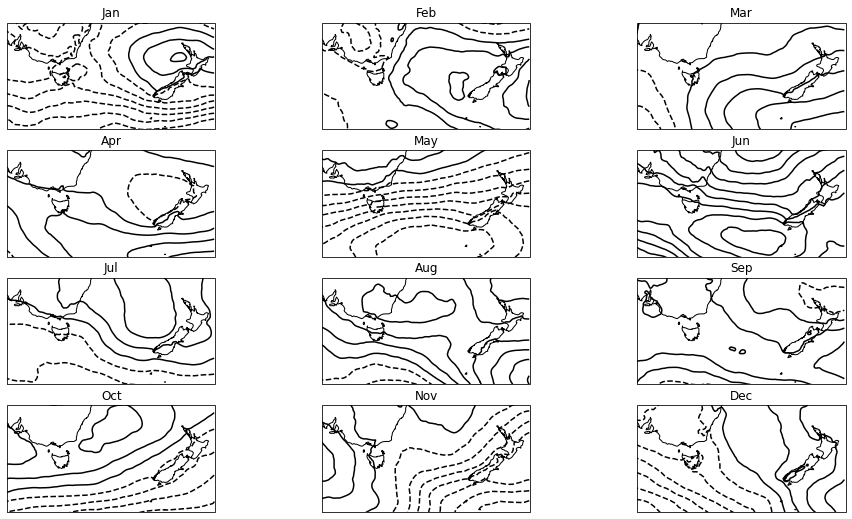

In [119]:
## new diff plot (monthly groupby)

def multiple_plots():
    nrow = 4
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = diff_ts_mon_mean
    data2 = mslp_anom_mon
    
    data_idx = 0
    stop_plotting = False
    for row in range(nrow):
        for col in range(ncol):
            #cur_data = data[data_idx]
            #ax[row, col].contourf(
                #cur_data.longitude,
                #cur_data.latitude,
                #cur_data.values,
                #levels=np.arange(-5.25, 5.0, 0.5),
                #add_colorbar=False,
                #cmap=plt.cm.get_cmap('bwr', 11), 
            #)
            cur_data2 = data2[data_idx]
            ax[row, col].contour(
                cur_data2.longitude,
                cur_data2.latitude,
                cur_data2.values,
                levels=10,
                colors='k'
            )
            ax[row, col].coastlines()
            ax[row, col].set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(cur_data2['month_name'].values.item())
            
            data_idx += 1
            if data_idx > 12:
                stop_plotting = True
                break
        if stop_plotting:
            break

            
    # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise           
    ax_flat = ax.flatten(order='C')
    
                
    # Delete any unused axes from the figure, so that they don't show
    # blank x- and y-axis lines
    for _, axis in enumerate(ax_flat[13:]):
        fig.delaxes(axis) 
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5_mslp_anom_monthly_panels.png')
    

multiple_plots()

In [6]:
# mean field of MSLP

ds_msl = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-MSL/era5_dailymsl_*.nc')

In [7]:
msl = (ds_msl['dailymsl']/100).sel(latitude=slice(-30, -53), longitude=slice(135, 180))

In [8]:
mean_msl = msl.mean(dim='time')

In [ ]:
mean_msl.plot()

KeyboardInterrupt: 

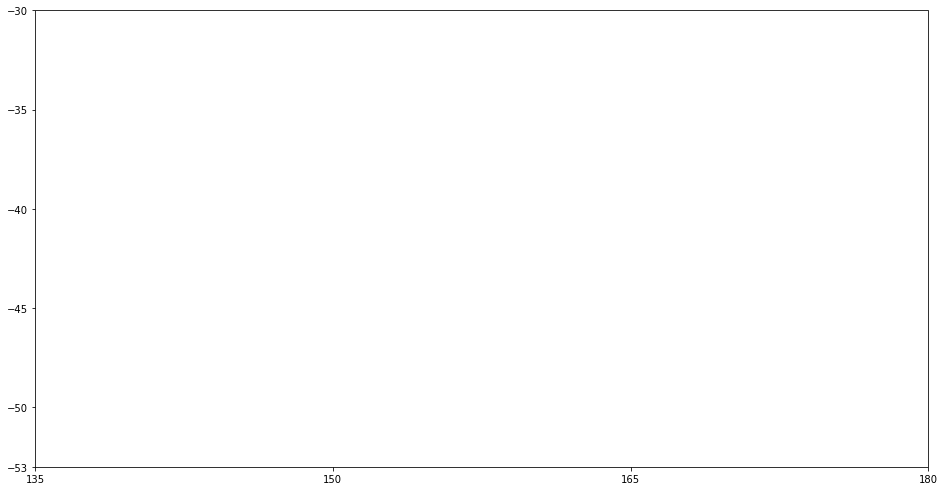

In [9]:
## new diff plot (monthly groupby)


fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([135, 180, -53, -30],crs=ccrs.PlateCarree())    

ax.set_xticks([135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

ploteo2=mean_msl.plot.contour(
            colors='k',
            levels=20
        )

ax.clabel(ploteo2, inline=True, fontsize=20, fmt='%1.1f')
ax.coastlines()


plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('ERA5 mean sea level pressure (1982-2018)', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/era5_mean_msl.png')

## Surface wind vectors

In [86]:
# uas and vas

ds_1981 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1981.nc')
uas_1981 = ds_1981.uas
vas_1981 = ds_1981.vas

ds_1982= xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1982.nc')
uas_1982 = ds_1982.uas
vas_1982 = ds_1982.vas

ds_1983 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1983.nc')
uas_1983 = ds_1983.uas
vas_1983 = ds_1983.vas

ds_1984 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1984.nc')
uas_1984 = ds_1984.uas
vas_1984 = ds_1984.vas

ds_1985 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1985.nc')
uas_1985 = ds_1985.uas
vas_1985 = ds_1985.vas

ds_1986 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1986.nc')
uas_1986 = ds_1986.uas
vas_1986 = ds_1986.vas

ds_1987 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1987.nc')
uas_1987 = ds_1987.uas
vas_1987 = ds_1987.vas

ds_1988 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1988.nc')
uas_1988 = ds_1988.uas
vas_1988 = ds_1988.vas

ds_1989 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1989.nc')
uas_1989 = ds_1989.uas
vas_1989 = ds_1989.vas

ds_1990 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1990.nc')
uas_1990 = ds_1990.uas
vas_1990 = ds_1990.vas

ds_1991 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1991.nc')
uas_1991 = ds_1991.uas
vas_1991 = ds_1991.vas

ds_1992 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1992.nc')
uas_1992 = ds_1992.uas
vas_1992 = ds_1992.vas

ds_1993 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1993.nc')
uas_1993 = ds_1993.uas
vas_1993 = ds_1993.vas

ds_1994 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1994.nc')
uas_1994 = ds_1994.uas
vas_1994 = ds_1994.vas

ds_1996 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1996.nc')
uas_1996 = ds_1996.uas
vas_1996 = ds_1996.vas

ds_1997 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1997.nc')
uas_1997 = ds_1997.uas
vas_1997 = ds_1997.vas

ds_1998 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_1998.nc')
uas_1998 = ds_1998.uas
vas_1998 = ds_1998.vas

ds_2000 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2000.nc')
uas_2000 = ds_2000.uas
vas_2000 = ds_2000.vas

ds_2001 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2001.nc')
uas_2001 = ds_2001.uas
vas_2001 = ds_2001.vas

ds_2002 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2002.nc')
uas_2002 = ds_2002.uas
vas_2002 = ds_2002.vas

ds_2003 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2003.nc')
uas_2003 = ds_2003.uas
vas_2003 = ds_2003.vas

ds_2004 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2004.nc')
uas_2004 = ds_2004.uas
vas_2004 = ds_2004.vas

ds_2005 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2005.nc')
uas_2005 = ds_2005.uas
vas_2005 = ds_2005.vas

ds_2006 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2006.nc')
uas_2006 = ds_2006.uas
vas_2006 = ds_2006.vas

ds_2007 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2007.nc')
uas_2007 = ds_2007.uas
vas_2007 = ds_2007.vas

ds_2008 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2008.nc')
uas_2008 = ds_2008.uas
vas_2008 = ds_2008.vas

ds_2009 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2009.nc')
uas_2009 = ds_2009.uas
vas_2009 = ds_2009.vas

ds_2010 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2010.nc')
uas_2010 = ds_2010.uas
vas_2010 = ds_2010.vas

ds_2011 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2011.nc')
uas_2011 = ds_2011.uas
vas_2011 = ds_2011.vas

ds_2012 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2012.nc')
uas_2012 = ds_2012.uas
vas_2012 = ds_2012.vas

ds_2013 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2013.nc')
uas_2013 = ds_2013.uas
vas_2013 = ds_2013.vas

ds_2014 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2014.nc')
uas_2014 = ds_2014.uas
vas_2014 = ds_2014.vas

ds_2015 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2015.nc')
uas_2015 = ds_2015.uas
vas_2015 = ds_2015.vas

ds_2016 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2016.nc')
uas_2016 = ds_2016.uas
vas_2016 = ds_2016.vas

ds_2017 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2017.nc')
uas_2017 = ds_2017.uas
vas_2017 = ds_2017.vas

ds_2018 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pvera_2018.nc')
uas_2018 = ds_2018.uas
vas_2018 = ds_2018.vas

In [87]:
ds_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pvera_*.nc')
ds_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pvera_*.nc')
ds_2019 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-2019/um_pvera_*.nc')

In [88]:
con_uas_1981 = ds_1980.uas.sel(time=slice('1981-06-01', '1982-06-30'))
con_uas_1982 = ds_1980.uas.sel(time=slice('1982-06-01', '1983-06-30')) 
con_uas_1983 = ds_1980.uas.sel(time=slice('1983-06-01', '1984-06-30')) 
con_uas_1984 = ds_1980.uas.sel(time=slice('1984-06-01', '1985-06-30')) 
con_uas_1985 = ds_1980.uas.sel(time=slice('1985-06-01', '1986-06-30')) 
con_uas_1986 = ds_1980.uas.sel(time=slice('1986-06-01', '1987-06-30')) 
con_uas_1987 = ds_1980.uas.sel(time=slice('1987-06-01', '1988-06-30')) 
con_uas_1988 = ds_1980.uas.sel(time=slice('1988-06-01', '1989-06-30')) 
con_uas_1989 = ds_1980.uas.sel(time=slice('1989-06-01', '1990-06-30')) 
con_uas_1990 = ds_1980.uas.sel(time=slice('1990-06-01', '1991-06-30')) 
con_uas_1991 = ds_1980.uas.sel(time=slice('1991-06-01', '1992-06-30')) 
con_uas_1992 = ds_1980.uas.sel(time=slice('1992-06-01', '1993-06-30')) 
con_uas_1993 = ds_1980.uas.sel(time=slice('1993-06-01', '1994-06-30')) 
con_uas_1994 = ds_1980.uas.sel(time=slice('1994-06-01', '1995-06-30')) 
con_uas_1996 = ds_1980.uas.sel(time=slice('1996-06-01', '1997-06-30')) 
con_uas_1997 = ds_1980.uas.sel(time=slice('1997-06-01', '1998-06-30')) 
con_uas_1998 = ds_1980.uas.sel(time=slice('1998-06-01', '1999-06-30')) 
con_uas_2000 = ds_1999.uas.sel(time=slice('2000-06-01', '2001-06-30')) 
con_uas_2001 = ds_1999.uas.sel(time=slice('2001-06-01', '2002-06-30')) 
con_uas_2002 = ds_1999.uas.sel(time=slice('2002-06-01', '2003-06-30')) 
con_uas_2003 = ds_1999.uas.sel(time=slice('2003-06-01', '2004-06-30')) 
con_uas_2004 = ds_1999.uas.sel(time=slice('2004-06-01', '2005-06-30')) 
con_uas_2005 = ds_1999.uas.sel(time=slice('2005-06-01', '2006-06-30')) 
con_uas_2006 = ds_1999.uas.sel(time=slice('2006-06-01', '2007-06-30')) 
con_uas_2007 = ds_1999.uas.sel(time=slice('2007-06-01', '2008-06-30')) 
con_uas_2008 = ds_1999.uas.sel(time=slice('2008-06-01', '2009-06-30')) 
con_uas_2009 = ds_1999.uas.sel(time=slice('2009-06-01', '2010-06-30')) 
con_uas_2010 = ds_1999.uas.sel(time=slice('2010-06-01', '2011-06-30')) 
con_uas_2011 = ds_1999.uas.sel(time=slice('2011-06-01', '2012-06-30')) 
con_uas_2012 = ds_1999.uas.sel(time=slice('2012-06-01', '2013-06-30')) 
con_uas_2013 = ds_1999.uas.sel(time=slice('2013-06-01', '2014-06-30')) 
con_uas_2014 = ds_1999.uas.sel(time=slice('2014-06-01', '2015-06-30')) 
con_uas_2015 = ds_1999.uas.sel(time=slice('2015-06-01', '2016-06-30')) 
con_uas_2016 = ds_1999.uas.sel(time=slice('2016-06-01', '2017-06-30')) 
con_uas_2017 = ds_1999.uas.sel(time=slice('2017-06-01', '2018-06-30')) 
con_uas_2018 = ds_1999.uas.sel(time=slice('2018-06-01', '2019-06-30')) 
con_uas_2019 = ds_2019.uas.sel(time=slice('2019-06-01', '2020-06-30')) 

In [89]:
con_vas_1981 = ds_1980.vas.sel(time=slice('1981-06-01', '1982-06-30'))
con_vas_1982 = ds_1980.vas.sel(time=slice('1982-06-01', '1983-06-30')) 
con_vas_1983 = ds_1980.vas.sel(time=slice('1983-06-01', '1984-06-30')) 
con_vas_1984 = ds_1980.vas.sel(time=slice('1984-06-01', '1985-06-30')) 
con_vas_1985 = ds_1980.vas.sel(time=slice('1985-06-01', '1986-06-30')) 
con_vas_1986 = ds_1980.vas.sel(time=slice('1986-06-01', '1987-06-30')) 
con_vas_1987 = ds_1980.vas.sel(time=slice('1987-06-01', '1988-06-30')) 
con_vas_1988 = ds_1980.vas.sel(time=slice('1988-06-01', '1989-06-30')) 
con_vas_1989 = ds_1980.vas.sel(time=slice('1989-06-01', '1990-06-30')) 
con_vas_1990 = ds_1980.vas.sel(time=slice('1990-06-01', '1991-06-30')) 
con_vas_1991 = ds_1980.vas.sel(time=slice('1991-06-01', '1992-06-30')) 
con_vas_1992 = ds_1980.vas.sel(time=slice('1992-06-01', '1993-06-30')) 
con_vas_1993 = ds_1980.vas.sel(time=slice('1993-06-01', '1994-06-30')) 
con_vas_1994 = ds_1980.vas.sel(time=slice('1994-06-01', '1995-06-30')) 
con_vas_1996 = ds_1980.vas.sel(time=slice('1996-06-01', '1997-06-30')) 
con_vas_1997 = ds_1980.vas.sel(time=slice('1997-06-01', '1998-06-30')) 
con_vas_1998 = ds_1980.vas.sel(time=slice('1998-06-01', '1999-06-30')) 
con_vas_2000 = ds_1999.vas.sel(time=slice('2000-06-01', '2001-06-30')) 
con_vas_2001 = ds_1999.vas.sel(time=slice('2001-06-01', '2002-06-30')) 
con_vas_2002 = ds_1999.vas.sel(time=slice('2002-06-01', '2003-06-30')) 
con_vas_2003 = ds_1999.vas.sel(time=slice('2003-06-01', '2004-06-30')) 
con_vas_2004 = ds_1999.vas.sel(time=slice('2004-06-01', '2005-06-30')) 
con_vas_2005 = ds_1999.vas.sel(time=slice('2005-06-01', '2006-06-30')) 
con_vas_2006 = ds_1999.vas.sel(time=slice('2006-06-01', '2007-06-30')) 
con_vas_2007 = ds_1999.vas.sel(time=slice('2007-06-01', '2008-06-30')) 
con_vas_2008 = ds_1999.vas.sel(time=slice('2008-06-01', '2009-06-30')) 
con_vas_2009 = ds_1999.vas.sel(time=slice('2009-06-01', '2010-06-30')) 
con_vas_2010 = ds_1999.vas.sel(time=slice('2010-06-01', '2011-06-30')) 
con_vas_2011 = ds_1999.vas.sel(time=slice('2011-06-01', '2012-06-30')) 
con_vas_2012 = ds_1999.vas.sel(time=slice('2012-06-01', '2013-06-30')) 
con_vas_2013 = ds_1999.vas.sel(time=slice('2013-06-01', '2014-06-30')) 
con_vas_2014 = ds_1999.vas.sel(time=slice('2014-06-01', '2015-06-30')) 
con_vas_2015 = ds_1999.vas.sel(time=slice('2015-06-01', '2016-06-30')) 
con_vas_2016 = ds_1999.vas.sel(time=slice('2016-06-01', '2017-06-30')) 
con_vas_2017 = ds_1999.vas.sel(time=slice('2017-06-01', '2018-06-30')) 
con_vas_2018 = ds_1999.vas.sel(time=slice('2018-06-01', '2019-06-30')) 
con_vas_2019 = ds_2019.vas.sel(time=slice('2019-06-01', '2020-06-30')) 

In [90]:
diff_uas_1981 = uas_1981.resample(time='1M').mean() - con_uas_1981.resample(time='1M').mean()
diff_uas_1982 = (uas_1982.resample(time='1M').mean() - con_uas_1982.resample(time='1M').mean())
diff_uas_1983 = (uas_1983.resample(time='1M').mean() - con_uas_1983.resample(time='1M').mean())
diff_uas_1984 = (uas_1984.resample(time='1M').mean() - con_uas_1984.resample(time='1M').mean())
diff_uas_1985 = (uas_1985.resample(time='1M').mean() - con_uas_1985.resample(time='1M').mean())
diff_uas_1986 = (uas_1986.resample(time='1M').mean() - con_uas_1986.resample(time='1M').mean())
diff_uas_1987 = (uas_1987.resample(time='1M').mean() - con_uas_1987.resample(time='1M').mean())
diff_uas_1988 = (uas_1988.resample(time='1M').mean() - con_uas_1988.resample(time='1M').mean())
diff_uas_1989 = (uas_1989.resample(time='1M').mean() - con_uas_1989.resample(time='1M').mean())
diff_uas_1990 = (uas_1990.resample(time='1M').mean() - con_uas_1990.resample(time='1M').mean())
diff_uas_1991 = (uas_1991.resample(time='1M').mean() - con_uas_1991.resample(time='1M').mean())
diff_uas_1992 = (uas_1992.resample(time='1M').mean() - con_uas_1992.resample(time='1M').mean())
diff_uas_1993 = (uas_1993.resample(time='1M').mean() - con_uas_1993.resample(time='1M').mean())
diff_uas_1994 = (uas_1994.resample(time='1M').mean() - con_uas_1994.resample(time='1M').mean())
diff_uas_1996 = (uas_1996.resample(time='1M').mean() - con_uas_1996.resample(time='1M').mean())
diff_uas_1997 = (uas_1997.resample(time='1M').mean() - con_uas_1997.resample(time='1M').mean())
diff_uas_1998 = (uas_1998.resample(time='1M').mean() - con_uas_1998.resample(time='1M').mean())
diff_uas_2000 = (uas_2000.resample(time='1M').mean() - con_uas_2000.resample(time='1M').mean())
diff_uas_2001 = (uas_2001.resample(time='1M').mean() - con_uas_2001.resample(time='1M').mean())
diff_uas_2002 = (uas_2002.resample(time='1M').mean() - con_uas_2002.resample(time='1M').mean())
diff_uas_2003 = (uas_2003.resample(time='1M').mean() - con_uas_2003.resample(time='1M').mean())
diff_uas_2004 = (uas_2004.resample(time='1M').mean() - con_uas_2004.resample(time='1M').mean())
diff_uas_2005 = (uas_2005.resample(time='1M').mean() - con_uas_2005.resample(time='1M').mean())
diff_uas_2006 = (uas_2006.resample(time='1M').mean() - con_uas_2006.resample(time='1M').mean())
diff_uas_2007 = (uas_2007.resample(time='1M').mean() - con_uas_2007.resample(time='1M').mean())
diff_uas_2008 = (uas_2008.resample(time='1M').mean() - con_uas_2008.resample(time='1M').mean())
diff_uas_2009 = (uas_2009.resample(time='1M').mean() - con_uas_2009.resample(time='1M').mean())
diff_uas_2010 = (uas_2010.resample(time='1M').mean() - con_uas_2010.resample(time='1M').mean())
diff_uas_2011 = (uas_2011.resample(time='1M').mean() - con_uas_2011.resample(time='1M').mean())
diff_uas_2012 = (uas_2012.resample(time='1M').mean() - con_uas_2012.resample(time='1M').mean())
diff_uas_2013 = (uas_2013.resample(time='1M').mean() - con_uas_2013.resample(time='1M').mean())
diff_uas_2014 = (uas_2014.resample(time='1M').mean() - con_uas_2014.resample(time='1M').mean())
diff_uas_2015 = (uas_2015.resample(time='1M').mean() - con_uas_2015.resample(time='1M').mean())
diff_uas_2016 = (uas_2016.resample(time='1M').mean() - con_uas_2016.resample(time='1M').mean())
diff_uas_2017 = (uas_2017.resample(time='1M').mean() - con_uas_2017.resample(time='1M').mean())
diff_uas_2018 = (uas_2018.resample(time='1M').mean() - con_uas_2018.resample(time='1M').mean())

In [91]:
diff_vas_1981 = vas_1981.resample(time='1M').mean() - con_vas_1981.resample(time='1M').mean()
diff_vas_1982 = (vas_1982.resample(time='1M').mean() - con_vas_1982.resample(time='1M').mean())
diff_vas_1983 = (vas_1983.resample(time='1M').mean() - con_vas_1983.resample(time='1M').mean())
diff_vas_1984 = (vas_1984.resample(time='1M').mean() - con_vas_1984.resample(time='1M').mean())
diff_vas_1985 = (vas_1985.resample(time='1M').mean() - con_vas_1985.resample(time='1M').mean())
diff_vas_1986 = (vas_1986.resample(time='1M').mean() - con_vas_1986.resample(time='1M').mean())
diff_vas_1987 = (vas_1987.resample(time='1M').mean() - con_vas_1987.resample(time='1M').mean())
diff_vas_1988 = (vas_1988.resample(time='1M').mean() - con_vas_1988.resample(time='1M').mean())
diff_vas_1989 = (vas_1989.resample(time='1M').mean() - con_vas_1989.resample(time='1M').mean())
diff_vas_1990 = (vas_1990.resample(time='1M').mean() - con_vas_1990.resample(time='1M').mean())
diff_vas_1991 = (vas_1991.resample(time='1M').mean() - con_vas_1991.resample(time='1M').mean())
diff_vas_1992 = (vas_1992.resample(time='1M').mean() - con_vas_1992.resample(time='1M').mean())
diff_vas_1993 = (vas_1993.resample(time='1M').mean() - con_vas_1993.resample(time='1M').mean())
diff_vas_1994 = (vas_1994.resample(time='1M').mean() - con_vas_1994.resample(time='1M').mean())
diff_vas_1996 = (vas_1996.resample(time='1M').mean() - con_vas_1996.resample(time='1M').mean())
diff_vas_1997 = (vas_1997.resample(time='1M').mean() - con_vas_1997.resample(time='1M').mean())
diff_vas_1998 = (vas_1998.resample(time='1M').mean() - con_vas_1998.resample(time='1M').mean())
diff_vas_2000 = (vas_2000.resample(time='1M').mean() - con_vas_2000.resample(time='1M').mean())
diff_vas_2001 = (vas_2001.resample(time='1M').mean() - con_vas_2001.resample(time='1M').mean())
diff_vas_2002 = (vas_2002.resample(time='1M').mean() - con_vas_2002.resample(time='1M').mean())
diff_vas_2003 = (vas_2003.resample(time='1M').mean() - con_vas_2003.resample(time='1M').mean())
diff_vas_2004 = (vas_2004.resample(time='1M').mean() - con_vas_2004.resample(time='1M').mean())
diff_vas_2005 = (vas_2005.resample(time='1M').mean() - con_vas_2005.resample(time='1M').mean())
diff_vas_2006 = (vas_2006.resample(time='1M').mean() - con_vas_2006.resample(time='1M').mean())
diff_vas_2007 = (vas_2007.resample(time='1M').mean() - con_vas_2007.resample(time='1M').mean())
diff_vas_2008 = (vas_2008.resample(time='1M').mean() - con_vas_2008.resample(time='1M').mean())
diff_vas_2009 = (vas_2009.resample(time='1M').mean() - con_vas_2009.resample(time='1M').mean())
diff_vas_2010 = (vas_2010.resample(time='1M').mean() - con_vas_2010.resample(time='1M').mean())
diff_vas_2011 = (vas_2011.resample(time='1M').mean() - con_vas_2011.resample(time='1M').mean())
diff_vas_2012 = (vas_2012.resample(time='1M').mean() - con_vas_2012.resample(time='1M').mean())
diff_vas_2013 = (vas_2013.resample(time='1M').mean() - con_vas_2013.resample(time='1M').mean())
diff_vas_2014 = (vas_2014.resample(time='1M').mean() - con_vas_2014.resample(time='1M').mean())
diff_vas_2015 = (vas_2015.resample(time='1M').mean() - con_vas_2015.resample(time='1M').mean())
diff_vas_2016 = (vas_2016.resample(time='1M').mean() - con_vas_2016.resample(time='1M').mean())
diff_vas_2017 = (vas_2017.resample(time='1M').mean() - con_vas_2017.resample(time='1M').mean())
diff_vas_2018 = (vas_2018.resample(time='1M').mean() - con_vas_2018.resample(time='1M').mean())

In [93]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

uas_year_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_uas_year = globals().get("diff_uas_{}".format(year))
    if diff_uas_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_uas_year.sel(time=buildup_slice).mean(dim="time")
    peak = diff_uas_year.sel(time=peak_slice).mean(dim="time")
    diedown = diff_uas_year.sel(time=diedown_slice).mean(dim="time")
    
    diff_uas_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    uas_year_phases.append(diff_uas_year_phase)
    
uas_year_phases_xr = xr.concat(uas_year_phases, dim="time")

In [95]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

vas_year_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_vas_year = globals().get("diff_vas_{}".format(year))
    if diff_vas_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_vas_year.sel(time=buildup_slice).mean(dim="time")
    peak = diff_vas_year.sel(time=peak_slice).mean(dim="time")
    diedown = diff_vas_year.sel(time=diedown_slice).mean(dim="time")
    
    diff_vas_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    vas_year_phases.append(diff_vas_year_phase)
    
vas_year_phases_xr = xr.concat(vas_year_phases, dim="time")

In [96]:
x = vas_year_phases_xr['longitude_0']
y = uas_year_phases_xr['latitude_0']

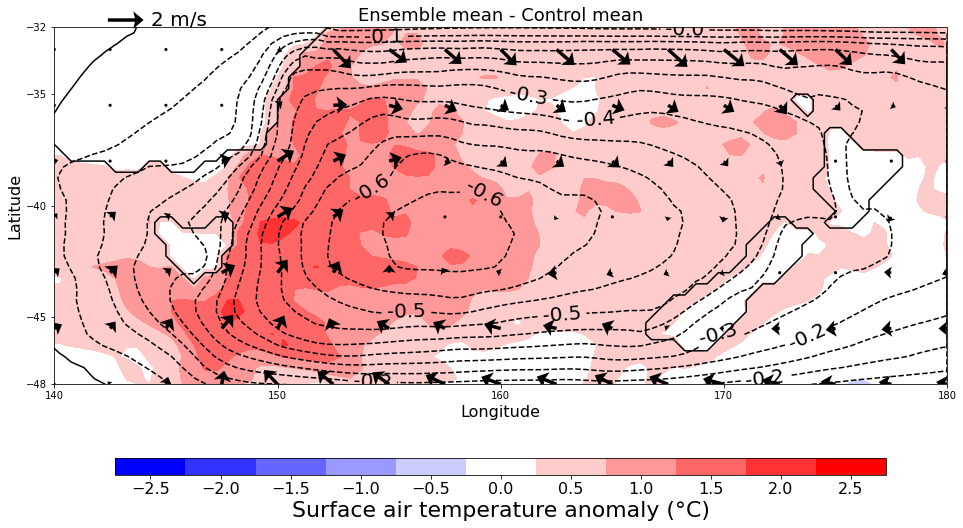

In [99]:
## new diff plot (monthly groupby)


fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([142, 180, -48, -32],crs=ccrs.PlateCarree())    

ax.set_xticks([140, 150, 160, 170, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-48, -45, -40, -35, -32], crs=ccrs.PlateCarree())

im=year_phases_xr.mean(dim='phase').mean(dim='time').plot.contourf(
            levels=np.arange(-2.75, 3.0, 0.5),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr', 11), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(-2.5,3.0,0.5),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Surface air temperature anomaly (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)


ploteo2=mslp_year_phases_xr.mean(dim='phase').mean(dim='time').plot.contour(
            colors='k',
            levels=30
        )

ax.clabel(ploteo2, inline=True, fontsize=20, fmt='%1.1f')

# scale = number of data units per arrow length 
q = ax.quiver(x[::5], y[::5], uas_year_phases_xr.mean(dim='phase').mean(dim='time')[::5, ::5], 
              vas_year_phases_xr.mean(dim='phase').mean(dim='time')[::5, ::5], 
              scale=10,
              units='height', headwidth=5, headlength=3, headaxislength=2.5)

plt.quiverkey(q, 0.1, 1.02, 1, '2 m/s', labelpos='E', fontproperties={'size':20})

mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Ensemble mean - Control mean', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_map_ensemble_control_mslp_winds_sat.png')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


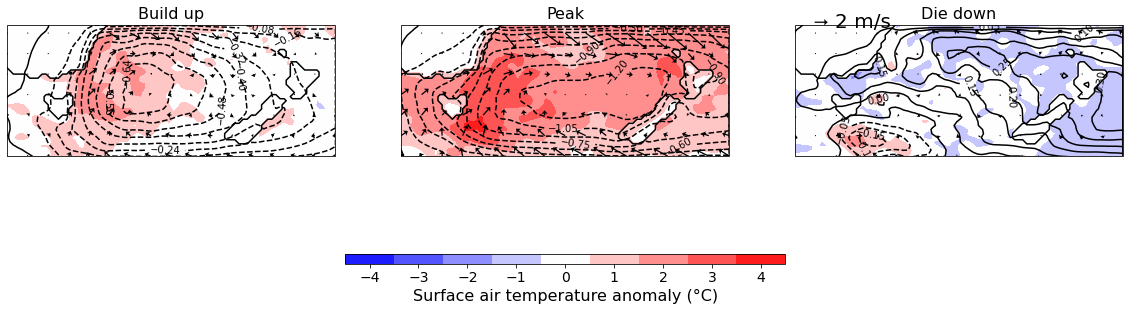

In [98]:
## new diff plot (phases)

def multiple_plots():
    nrow = 1
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(20,12), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = year_phases_xr.mean(dim='time')
    data2 = mslp_year_phases_xr.mean(dim='time')
    data3 = uas_year_phases_xr.mean(dim='time')
    data4 = vas_year_phases_xr.mean(dim='time')
    
    phases = ['Build up', 'Peak', 'Die down']
    contour = None
    mask_mean = mask.mean(dim='time')
    
    for col in range(ncol):
        cur_data = data[col]
        contour = ax[col].contourf(
            cur_data.longitude,
            cur_data.latitude,
            cur_data.values,
            levels=np.arange(-4.5, 5.0, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('bwr'), 
        )
        ax[col].contour(
            mask_mean.longitude, 
            mask_mean.latitude,
            mask_mean.values,
            levels=[0.5], 
            cmap='gray')
        
        cur_data2 = data2[col]
        CS = ax[col].contour(
            cur_data2.longitude,
            cur_data2.latitude,
            cur_data2.values,
            levels=10,
            colors='k'
        )

        q = ax[col].quiver(
            x[::5], y[::5],
            data3[col][::5, ::5],
            data4[col][::5, ::5],
            scale=10,
            units='height', headwidth=5, headlength=3, headaxislength=2.5
        )
        
        
        ax[col].set_extent([140, 180, -48, -32],crs=ccrs.PlateCarree()) 
        ax[col].set_title(phases[col], fontsize=16)
        ax[col].clabel(CS, CS.levels, inline=True, fontsize=10)
    cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), orientation="horizontal",ticks=np.arange(-4,5.0,1),fraction=0.015,aspect=45)
    cbar.set_label(label=u'Surface air temperature anomaly (\u00B0C)', fontsize=16)  
    cbar.ax.tick_params(labelsize=14)
    plt.quiverkey(q, 0.1, 1.02, 1, '2 m/s', labelpos='E', fontproperties={'size':20})
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_mslp_phases_land.png')

multiple_plots()

## Stratiform rainfall

In [61]:
ds_1980 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1980/um_pverb_*.nc')
ds_1999 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-1999/um_pverb_*.nc')
ds_2019 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-uby108-2019/um_pverb_*.nc')

In [64]:
con_1982 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1982-01-01', '1982-12-31')).mean(dim='time')
con_1983 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1983-01-01', '1983-12-31')).mean(dim='time')
con_1984 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1984-01-01', '1984-12-31')).mean(dim='time')
con_1985 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1985-01-01', '1985-12-31')).mean(dim='time')
con_1986 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1986-01-01', '1986-12-31')).mean(dim='time')
con_1987 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1987-01-01', '1987-12-31')).mean(dim='time')
con_1988 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1988-01-01', '1988-12-31')).mean(dim='time')
con_1989 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1989-01-01', '1989-12-31')).mean(dim='time')
con_1990 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1990-01-01', '1990-12-31')).mean(dim='time')
con_1991 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1991-01-01', '1991-12-31')).mean(dim='time')
con_1992 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1992-01-01', '1992-12-31')).mean(dim='time')
con_1993 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1993-01-01', '1993-12-31')).mean(dim='time')
con_1994 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1994-01-01', '1994-12-31')).mean(dim='time')
con_1996 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1996-01-01', '1996-12-31')).mean(dim='time')
con_1997 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1997-01-01', '1997-12-31')).mean(dim='time')
con_1998 = ds_1980.stratiform_rainfall_amount.sel(time=slice('1998-01-01', '1998-12-31')).mean(dim='time')
con_2000 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2000-01-01', '2000-12-31')).mean(dim='time')
con_2001 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2001-01-01', '2001-12-31')).mean(dim='time')
con_2002 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2002-01-01', '2002-12-31')).mean(dim='time')
con_2003 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2003-01-01', '2003-12-31')).mean(dim='time')
con_2004 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2004-01-01', '2004-12-31')).mean(dim='time')
con_2005 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2005-01-01', '2005-12-31')).mean(dim='time')
con_2006 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2006-01-01', '2006-12-31')).mean(dim='time')
con_2007 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2007-01-01', '2007-12-31')).mean(dim='time')
con_2008 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2008-01-01', '2008-12-31')).mean(dim='time')
con_2009 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2009-01-01', '2009-12-31')).mean(dim='time')
con_2010 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2010-01-01', '2010-12-31')).mean(dim='time')
con_2011 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2011-01-01', '2011-12-31')).mean(dim='time')
con_2012 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2012-01-01', '2012-12-31')).mean(dim='time')
con_2013 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2013-01-01', '2013-12-31')).mean(dim='time')
con_2014 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2014-01-01', '2014-12-31')).mean(dim='time')
con_2015 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2015-01-01', '2015-12-31')).mean(dim='time')
con_2016 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2016-01-01', '2016-12-31')).mean(dim='time')
con_2017 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2017-01-01', '2017-12-31')).mean(dim='time')
con_2018 = ds_1999.stratiform_rainfall_amount.sel(time=slice('2018-01-01', '2018-12-31')).mean(dim='time')
con_2019 = ds_2019.stratiform_rainfall_amount.sel(time=slice('2019-01-01', '2019-12-31')).mean(dim='time')

In [65]:
ds_1981 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1981.nc')
rf_1981 = ds_1981.stratiform_rainfall_amount

ds_1982= xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1982.nc')
rf_1982 = ds_1982.stratiform_rainfall_amount

ds_1983 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1983.nc')
rf_1983 = ds_1983.stratiform_rainfall_amount

ds_1984 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1984.nc')
rf_1984 = ds_1984.stratiform_rainfall_amount

ds_1985 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1985.nc')
rf_1985 = ds_1985.stratiform_rainfall_amount

ds_1986 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1986.nc')
rf_1986 = ds_1986.stratiform_rainfall_amount

ds_1987 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1987.nc')
rf_1987 = ds_1987.stratiform_rainfall_amount

ds_1988 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1988.nc')
rf_1988 = ds_1988.stratiform_rainfall_amount

ds_1989 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1989.nc')
rf_1989 = ds_1989.stratiform_rainfall_amount

ds_1990 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1990.nc')
rf_1990 = ds_1990.stratiform_rainfall_amount

ds_1991 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1991.nc')
rf_1991 = ds_1991.stratiform_rainfall_amount

ds_1992 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1992.nc')
rf_1992 = ds_1992.stratiform_rainfall_amount

ds_1993 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1993.nc')
rf_1993 = ds_1993.stratiform_rainfall_amount

ds_1994 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1994.nc')
rf_1994 = ds_1994.stratiform_rainfall_amount

ds_1996 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1996.nc')
rf_1996 = ds_1996.stratiform_rainfall_amount

ds_1997 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1997.nc')
rf_1997 = ds_1997.stratiform_rainfall_amount

ds_1998 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_1998.nc')
rf_1998 = ds_1998.stratiform_rainfall_amount

ds_2000 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2000.nc')
rf_2000 = ds_2000.stratiform_rainfall_amount

ds_2001 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2001.nc')
rf_2001 = ds_2001.stratiform_rainfall_amount

ds_2002 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2002.nc')
rf_2002 = ds_2002.stratiform_rainfall_amount

ds_2003 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2003.nc')
rf_2003 = ds_2003.stratiform_rainfall_amount

ds_2004 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2004.nc')
rf_2004 = ds_2004.stratiform_rainfall_amount

ds_2005 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2005.nc')
rf_2005 = ds_2005.stratiform_rainfall_amount

ds_2006 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2006.nc')
rf_2006 = ds_2006.stratiform_rainfall_amount

ds_2007 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2007.nc')
rf_2007 = ds_2007.stratiform_rainfall_amount

ds_2008 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2008.nc')
rf_2008 = ds_2008.stratiform_rainfall_amount

ds_2009 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2009.nc')
rf_2009 = ds_2009.stratiform_rainfall_amount

ds_2010 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2010.nc')
rf_2010 = ds_2010.stratiform_rainfall_amount

ds_2011 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2011.nc')
rf_2011 = ds_2011.stratiform_rainfall_amount

ds_2012 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2012.nc')
rf_2012 = ds_2012.stratiform_rainfall_amount

ds_2013 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2013.nc')
rf_2013 = ds_2013.stratiform_rainfall_amount

ds_2014 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2014.nc')
rf_2014 = ds_2014.stratiform_rainfall_amount

ds_2015 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2015.nc')
rf_2015 = ds_2015.stratiform_rainfall_amount

ds_2016 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2016.nc')
rf_2016 = ds_2016.stratiform_rainfall_amount

ds_2017 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2017.nc')
rf_2017 = ds_2017.stratiform_rainfall_amount

ds_2018 = xr.open_dataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/um_pverb_2018.nc')
rf_2018 = ds_2018.stratiform_rainfall_amount

In [66]:
mean_rf_1981 = rf_1981.mean(dim='time')

mean_rf_1982 = rf_1982.mean(dim='time')
mean_rf_1983 = rf_1983.mean(dim='time')
mean_rf_1984 = rf_1984.mean(dim='time')
mean_rf_1985 = rf_1985.mean(dim='time')
mean_rf_1986 = rf_1986.mean(dim='time')
mean_rf_1987 = rf_1987.mean(dim='time')
mean_rf_1988 = rf_1988.mean(dim='time')
mean_rf_1989 = rf_1989.mean(dim='time')
mean_rf_1990 = rf_1990.mean(dim='time')

mean_rf_1991 = rf_1991.mean(dim='time')
mean_rf_1992 = rf_1992.mean(dim='time')
mean_rf_1993 = rf_1993.mean(dim='time')
mean_rf_1994 = rf_1994.mean(dim='time')
mean_rf_1996 = rf_1996.mean(dim='time')
mean_rf_1997 = rf_1997.mean(dim='time')
mean_rf_1998 = rf_1998.mean(dim='time')
mean_rf_2000 = rf_2000.mean(dim='time')
mean_rf_2001 = rf_2001.mean(dim='time')
mean_rf_2002 = rf_2002.mean(dim='time')
mean_rf_2003 = rf_2003.mean(dim='time')

mean_rf_2004 = rf_2004.mean(dim='time')
mean_rf_2005 = rf_2005.mean(dim='time')
mean_rf_2006 = rf_2006.mean(dim='time')
mean_rf_2007 = rf_2007.mean(dim='time')
mean_rf_2008 = rf_2008.mean(dim='time')
mean_rf_2009 = rf_2009.mean(dim='time')
mean_rf_2010 = rf_2010.mean(dim='time')
mean_rf_2011 = rf_2011.mean(dim='time')
mean_rf_2012 = rf_2012.mean(dim='time')
mean_rf_2013 = rf_2013.mean(dim='time')
mean_rf_2014 = rf_2014.mean(dim='time')
mean_rf_2015 = rf_2015.mean(dim='time')
mean_rf_2016 = rf_2016.mean(dim='time')
mean_rf_2017 = rf_2017.mean(dim='time')

mean_rf_2018 = rf_2018.mean(dim='time')

In [67]:
diff_1982 = (mean_rf_1982 - con_1982)
diff_1983 = (mean_rf_1983 - con_1983)
diff_1984 = (mean_rf_1984 - con_1984)
diff_1985 = (mean_rf_1985 - con_1985)
diff_1986 = (mean_rf_1986 - con_1986)
diff_1987 = (mean_rf_1987 - con_1987)
diff_1988 = (mean_rf_1988 - con_1988)
diff_1989 = (mean_rf_1989 - con_1989)
diff_1990 = (mean_rf_1990 - con_1990)
diff_1991 = (mean_rf_1991 - con_1991)
diff_1992 = (mean_rf_1992 - con_1992)
diff_1993 = (mean_rf_1993 - con_1993)
diff_1994 = (mean_rf_1994 - con_1994)
diff_1996 = (mean_rf_1996 - con_1996)
diff_1997 = (mean_rf_1997 - con_1997)
diff_1998 = (mean_rf_1998 - con_1998)
diff_2000 = (mean_rf_2000 - con_2000)
diff_2001 = (mean_rf_2001 - con_2001)
diff_2002 = (mean_rf_2002 - con_2002)
diff_2003 = (mean_rf_2003 - con_2003)
diff_2004 = (mean_rf_2004 - con_2004)
diff_2005 = (mean_rf_2005 - con_2005)
diff_2006 = (mean_rf_2006 - con_2006)
diff_2007 = (mean_rf_2007 - con_2007)
diff_2008 = (mean_rf_2008 - con_2008)
diff_2009 = (mean_rf_2009 - con_2009)
diff_2010 = (mean_rf_2010 - con_2010)
diff_2011 = (mean_rf_2011 - con_2011)
diff_2012 = (mean_rf_2012 - con_2012)
diff_2013 = (mean_rf_2013 - con_2013)
diff_2014 = (mean_rf_2014 - con_2014)
diff_2015 = (mean_rf_2015 - con_2015)
diff_2016 = (mean_rf_2016 - con_2016)
diff_2017 = (mean_rf_2017 - con_2017)
diff_2018 = (mean_rf_2018 - con_2018)

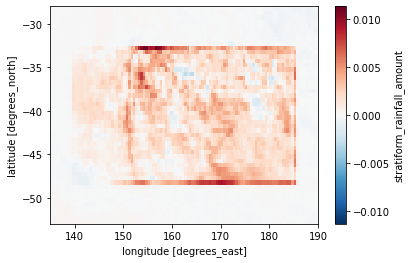

In [84]:
diff_1982.plot()

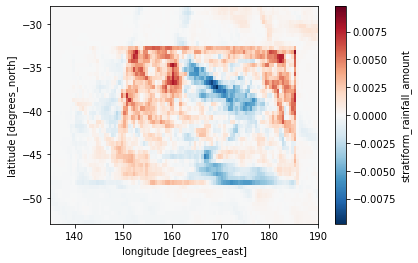

In [68]:
diff_2018.plot()

In [69]:
diff_rf_mean = xr.concat([diff_2018, diff_2017, diff_2016, diff_2015, diff_2014, diff_2013, diff_2012, diff_2011, diff_2010, 
                 diff_2009, diff_2008, diff_2007, diff_2006, diff_2005, diff_2004, diff_2003, diff_2002, diff_2001,
                 diff_2000, diff_1998, diff_1997, diff_1996, diff_1994, diff_1993, diff_1992, diff_1991, diff_1990,
                 diff_1989, diff_1988, diff_1987, diff_1986, diff_1985, diff_1984, diff_1983, diff_1982], dim='time').mean(dim='time')

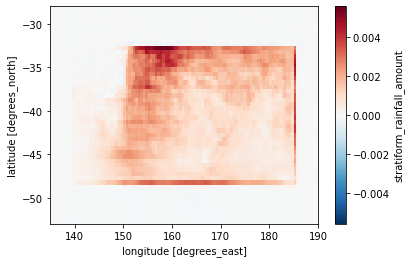

In [70]:
diff_rf_mean.plot()

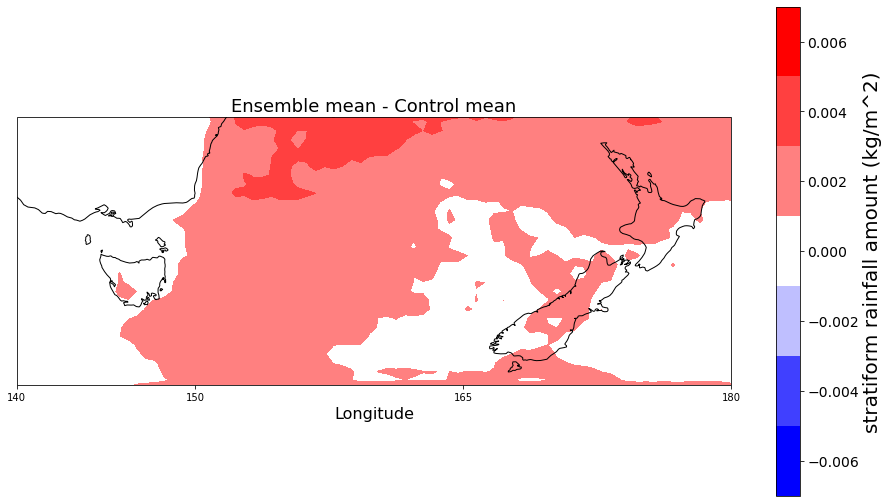

In [76]:
fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([140, 180, -48, -33],crs=ccrs.PlateCarree())    

ax.set_xticks([140, 150, 165, 180], crs=ccrs.PlateCarree())
#ax.set_yticks([-53, -50, -45, -40, -35, -30], crs=ccrs.PlateCarree())

ploteo=diff_rf_mean.plot.contourf(
            levels=np.arange(-0.007, 0.008, 0.002),
            cmap=plt.cm.get_cmap('bwr', 9), 
       )

ploteo.colorbar.set_ticks(np.arange(-0.006,0.008,0.002))

ploteo.colorbar.ax.set_ylabel('stratiform rainfall amount (kg/m^2)',fontsize=20)
ploteo.colorbar.ax.tick_params(labelsize=14)
ax.coastlines()


plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Ensemble mean - Control mean', fontsize=18)

plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_map_ensemble_control_hashing.png')

In [79]:
zero = xr.zeros_like(diff_rf_mean)

r = stats.ttest_1samp(diff_rf_mean, zero, axis=0, nan_policy='omit')

# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('latitude', 'longitude'), coords={
    'latitude': zero['latitude'],
    'longitude': zero['longitude']
})

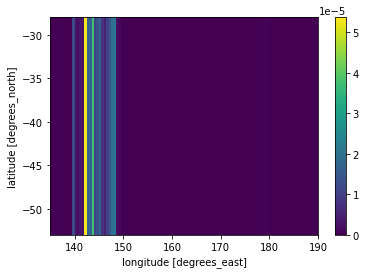

In [80]:
da.plot()

## New runs (soil moisture)

In [100]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1985/um_pverb_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1991/um_pverb_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1998/um_pverb_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2005/um_pverb_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2011/um_pverb_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2017/um_pverb_*.nc').sel(time=slice('2017-06', '2018-06'))

In [101]:
con_sm_1985 = ds1.mrsos.isel(depth=0)
con_sm_1991 = ds2.mrsos.isel(depth=0)
con_sm_1998 = ds3.mrsos.isel(depth=0)
con_sm_2005 = ds4.mrsos.isel(depth=0)
con_sm_2011 = ds5.mrsos.isel(depth=0)
con_sm_2017 = ds6.mrsos.isel(depth=0)

In [102]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverb_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1991/um_pverb_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1998/um_pverb_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2005/um_pverb_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2011/um_pverb_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2017/um_pverb_*.nc').sel(time=slice('2017-06', '2018-06'))

In [103]:
alt_sm_1985 = ds1.mrsos.isel(depth=0)
alt_sm_1991 = ds2.mrsos.isel(depth=0)
alt_sm_1998 = ds3.mrsos.isel(depth=0)
alt_sm_2005 = ds4.mrsos.isel(depth=0)
alt_sm_2011 = ds5.mrsos.isel(depth=0)
alt_sm_2017 = ds6.mrsos.isel(depth=0)

In [104]:
diff_sm_1985 = alt_sm_1985.resample(time='1M').mean() - con_sm_1985.resample(time='1M').mean()
diff_sm_1991 = alt_sm_1991.resample(time='1M').mean() - con_sm_1991.resample(time='1M').mean()
diff_sm_1998 = alt_sm_1998.resample(time='1M').mean() - con_sm_1998.resample(time='1M').mean()
diff_sm_2005 = alt_sm_2005.resample(time='1M').mean() - con_sm_2005.resample(time='1M').mean()
diff_sm_2011 = alt_sm_2011.resample(time='1M').mean() - con_sm_2011.resample(time='1M').mean()
diff_sm_2017 = alt_sm_2017.resample(time='1M').mean() - con_sm_2017.resample(time='1M').mean()

In [105]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

sm_year_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_sm_year = globals().get("diff_sm_{}".format(year))
    if diff_sm_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_sm_year.sel(time=buildup_slice).mean(dim="time")
    peak = diff_sm_year.sel(time=peak_slice).mean(dim="time")
    diedown = diff_sm_year.sel(time=diedown_slice).mean(dim="time")
    
    diff_sm_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    sm_year_phases.append(diff_sm_year_phase)
    
sm_year_phases_xr = xr.concat(sm_year_phases, dim="time")

In [106]:
r_b = stats.ttest_1samp(sm_year_phases_xr.isel(phase=0), 0, axis=0, nan_policy='omit')

# Convert the p-values into a dataarray:
da_b = xr.DataArray(r_b[1], dims=('latitude', 'longitude'), coords={
    'latitude': sm_year_phases_xr['latitude'],
    'longitude': sm_year_phases_xr['longitude']
})

r_p = stats.ttest_1samp(sm_year_phases_xr.isel(phase=1), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_p = xr.DataArray(r_p[1], dims=('latitude', 'longitude'), coords={
    'latitude': sm_year_phases_xr['latitude'],
    'longitude': sm_year_phases_xr['longitude']
})

r_d = stats.ttest_1samp(sm_year_phases_xr.isel(phase=2), 0, axis=0, nan_policy='omit')


# Convert the p-values into a dataarray:
da_d = xr.DataArray(r_d[1], dims=('latitude', 'longitude'), coords={
    'latitude': sm_year_phases_xr['latitude'],
    'longitude': sm_year_phases_xr['longitude']
})

sig_da = xr.concat([da_b, da_p, da_d], dim='phase')
sig_da

<xarray.DataArray (phase: 3, latitude: 50, longitude: 110)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
Dimensions without coordinates: phase

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **

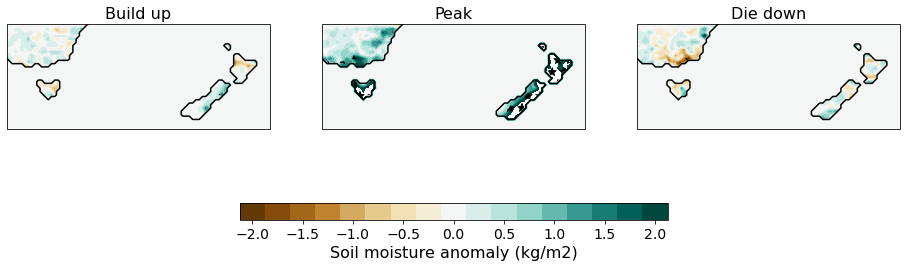

In [117]:
## new diff plot (phases)

def multiple_plots():
    nrow = 1
    ncol = 3
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9), 
            subplot_kw={'projection': ccrs.PlateCarree()}) # Specifies the projection for the plots    
    
    data = sm_year_phases_xr.mean(dim='time')

    phases = ['Build up', 'Peak', 'Die down']
    contour = None
    mask_mean = mask.mean(dim='time')
    
    for col in range(ncol):
        cur_data = data[col]
        contour = ax[col].contourf(
            cur_data.longitude,
            cur_data.latitude,
            cur_data.values,
            levels=np.arange(-2.125, 2.25, 0.25),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('BrBG'), 
        )
        
        ax[col].contour(
            mask_mean.longitude, 
            mask_mean.latitude,
            mask_mean.values,
            levels=[0.5], 
            cmap='gray')
        
        phase_mask_mean = sig_da[col].where(mask).mean(dim='time')
        ax[col].contourf(
            phase_mask_mean.longitude,
            phase_mask_mean.latitude,
            phase_mask_mean.values,
            levels=[0.00, 0.05, 1.00],
            hatches=['*', None],
            colors='none',
            add_colorbar=False,
        )

        ax[col].set_extent([140, 180, -48, -32],crs=ccrs.PlateCarree()) 
        ax[col].set_title(phases[col], fontsize=16)

    cbar = fig.colorbar(contour, ax=ax.ravel().tolist(), orientation="horizontal",ticks=np.arange(-2,2.25,0.5),fraction=0.035,aspect=25)
    cbar.set_label("Soil moisture anomaly (kg/m2)", fontsize=16)  
    cbar.ax.tick_params(labelsize=14)

    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_sm_phases_land.png')
    #0.035

multiple_plots()

## New runs (pressure levels)

In [81]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1985/um_pverc_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1991/um_pverc_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1998/um_pverc_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2005/um_pverc_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2011/um_pverc_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2017/um_pverc_*.nc').sel(time=slice('2017-06', '2018-06'))

In [82]:
con_x_1985 = ds1.x_wind
con_x_1991 = ds2.x_wind
con_x_1998 = ds3.x_wind
con_x_2005 = ds4.x_wind
con_x_2011 = ds5.x_wind
con_x_2017 = ds6.x_wind

In [83]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverc_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1991/um_pverc_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1998/um_pverc_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2005/um_pverc_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2011/um_pverc_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2017/um_pverc_*.nc').sel(time=slice('2017-06', '2018-06'))


In [84]:
alt_x_1985 = ds1.x_wind
alt_x_1991 = ds2.x_wind
alt_x_1998 = ds3.x_wind
alt_x_2005 = ds4.x_wind
alt_x_2011 = ds5.x_wind
alt_x_2017 = ds6.x_wind

In [85]:
diff_x_1985 = alt_x_1985.resample(time='1M').mean() - con_x_1985.resample(time='1M').mean()
diff_x_1991 = alt_x_1991.resample(time='1M').mean() - con_x_1991.resample(time='1M').mean()
diff_x_1998 = alt_x_1998.resample(time='1M').mean() - con_x_1998.resample(time='1M').mean()
diff_x_2005 = alt_x_2005.resample(time='1M').mean() - con_x_2005.resample(time='1M').mean()
diff_x_2011 = alt_x_2011.resample(time='1M').mean() - con_x_2011.resample(time='1M').mean()
diff_x_2017 = alt_x_2017.resample(time='1M').mean() - con_x_2017.resample(time='1M').mean()

In [88]:
phase_ranges = {
    "buildup": {
        "start": "06",
        "end": "10",
    },
    "peak": {
        "start": "11",
        "end": "02",
    },
    "diedown": {
        "start": "03",
        "end": "06",
    },
}

year_phases = []
start_year = 1981
end_year = 2018
for year in range(start_year, end_year+1):
    diff_year = globals().get("diff_x_{}".format(year))
    if diff_year is None:
        continue
        
    next_year = year + 1
    buildup_slice = slice("{}-{}".format(year, phase_ranges["buildup"]["start"]),
                          "{}-{}".format(year, phase_ranges["buildup"]["end"]))
    peak_slice = slice("{}-{}".format(year, phase_ranges["peak"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["peak"]["end"]))
    diedown_slice = slice("{}-{}".format(next_year, phase_ranges["diedown"]["start"]),
                          "{}-{}".format(next_year, phase_ranges["diedown"]["end"]))
    
    buildup = diff_year.sel(time=buildup_slice).mean(dim="time")
    peak = diff_year.sel(time=peak_slice).mean(dim="time")
    diedown = diff_year.sel(time=diedown_slice).mean(dim="time")
    
    diff_year_phase = xr.concat([buildup, peak, diedown], dim="phase")
    year_phases.append(diff_year_phase)
    
verticalu_year_phases_xr = xr.concat(year_phases, dim="time")

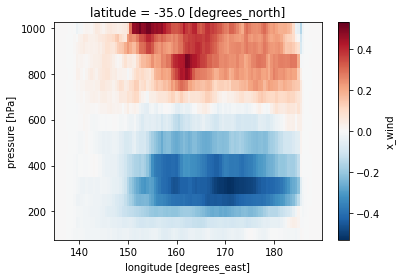

In [90]:
verticalu_year_phases_xr.sel(latitude=-35).isel(phase=0).mean(dim='time').plot()

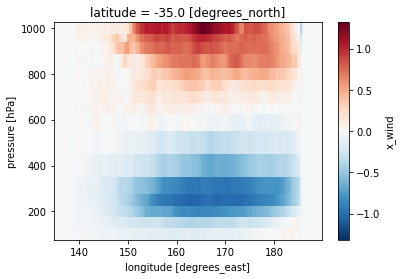

In [91]:
verticalu_year_phases_xr.sel(latitude=-35).isel(phase=1).mean(dim='time').plot()

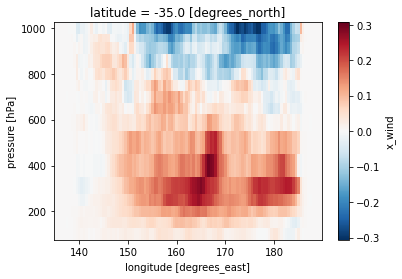

In [92]:
verticalu_year_phases_xr.sel(latitude=-35).isel(phase=2).mean(dim='time').plot()

/local/e14/cp3790/tmp/ipykernel_3932656/1618479805.py:4: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  contour = ax.contourf(index_x_xr.longitude, index_x_xr.pressure, index_x_xr.sel(latitude=-35).mean(dim='time'),


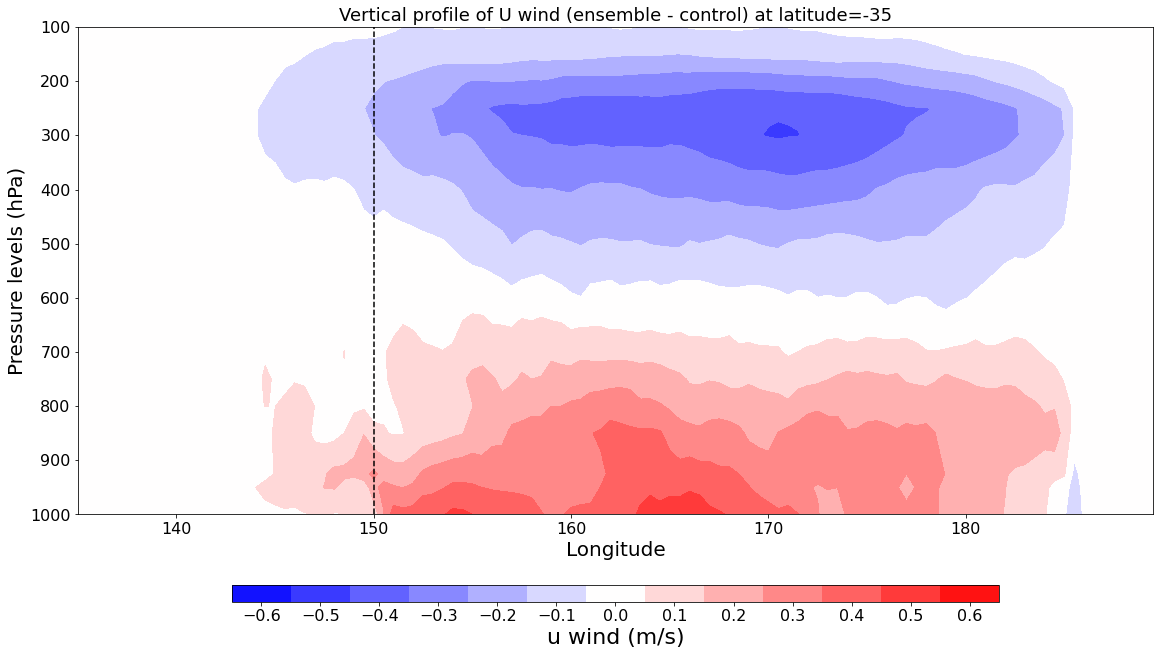

In [88]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(index_x_xr.longitude, index_x_xr.pressure, index_x_xr.sel(latitude=-35).mean(dim='time'), 
                      cmap='bwr',
                      levels=np.arange(-0.65, 0.7, 0.1),
                      add_colorbar=False,
)
plt.gca().invert_yaxis()

ax.set_title("Vertical profile of U wind (ensemble - control) at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Pressure levels (hPa)", fontsize=20)

plt.axvline(x=150, linestyle='--', color='black')

#cbar = fig.colorbar(contour)
#cbar.ax.set_ylabel("u wind (m/s)", fontsize=16)

cb = plt.colorbar(contour, orientation="horizontal",ticks=np.arange(-0.6,0.7,0.1),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'u wind (m/s)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_uwind_mean_-35.png')

/local/e14/cp3790/tmp/ipykernel_3932656/789901324.py:21: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax[row, col].contourf(


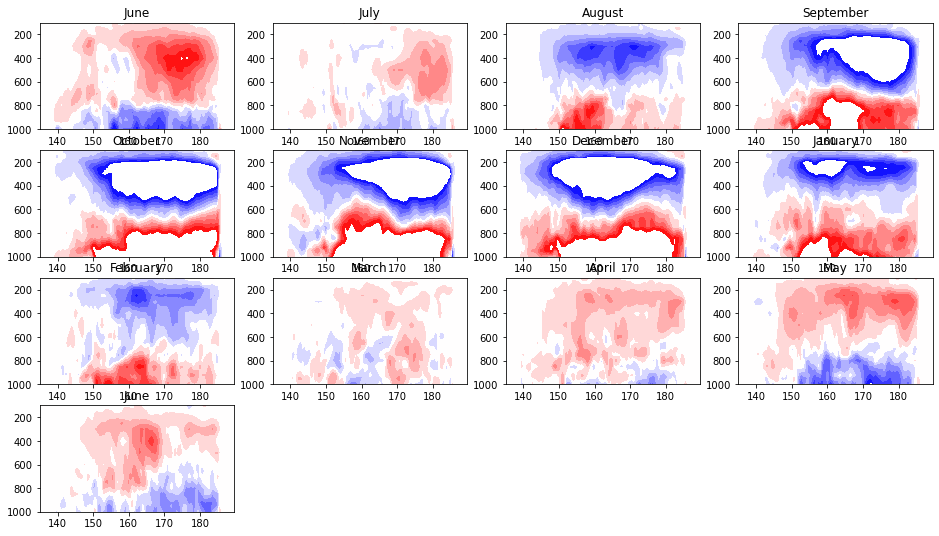

In [77]:
## monthly panels

def multiple_plots():
    nrow = 4
    ncol = 4
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9))  
    
    data = index_x_xr.sel(latitude=-35)

    months = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 
              'March', 'April', 'May', 'June']

#plt.gca().invert_yaxis()

    data_idx = 0
    stop_plotting = False
    for row in range(nrow):
        for col in range(ncol):
            cur_data = data[data_idx]
            ax[row, col].contourf(
                cur_data.longitude,
                cur_data.pressure,
                cur_data.values,
                levels=np.arange(-0.65, 0.7, 0.1),
                add_colorbar=False,
                cmap=plt.cm.get_cmap('bwr'), 
            )
         
            #ax[row, col].coastlines()
            #ax[row, col].set_extent([135, 180, -53, -32],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(months[data_idx])
            ax[row, col].invert_yaxis()
            
            data_idx += 1
            if data_idx > 12:
                stop_plotting = True
                break
        if stop_plotting:
            break

            
    # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise           
    ax_flat = ax.flatten(order='C')
    
                
    # Delete any unused axes from the figure, so that they don't show
    # blank x- and y-axis lines
    for _, axis in enumerate(ax_flat[13:]):
        fig.delaxes(axis) 
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_uwind_monthly_panels_13mths.png')
    

multiple_plots()

In [110]:
con_y_1985 = ds1.y_wind
con_y_1991 = ds2.y_wind
con_y_1998 = ds3.y_wind
con_y_2005 = ds4.y_wind
con_y_2011 = ds5.y_wind
con_y_2017 = ds6.y_wind

In [112]:
alt_y_1985 = ds1.y_wind
alt_y_1991 = ds2.y_wind
alt_y_1998 = ds3.y_wind
alt_y_2005 = ds4.y_wind
alt_y_2011 = ds5.y_wind
alt_y_2017 = ds6.y_wind

In [115]:
diff_y_1985 = alt_y_1985.resample(time='1M').mean() - con_y_1985.resample(time='1M').mean()
diff_y_1991 = alt_y_1991.resample(time='1M').mean() - con_y_1991.resample(time='1M').mean()
diff_y_1998 = alt_y_1998.resample(time='1M').mean() - con_y_1998.resample(time='1M').mean()
diff_y_2005 = alt_y_2005.resample(time='1M').mean() - con_y_2005.resample(time='1M').mean()
diff_y_2011 = alt_y_2011.resample(time='1M').mean() - con_y_2011.resample(time='1M').mean()
diff_y_2017 = alt_y_2017.resample(time='1M').mean() - con_y_2017.resample(time='1M').mean()

In [117]:
diff_years = [diff_y_2017, diff_y_2011, diff_y_2005, diff_y_1998, diff_y_1991, diff_y_1985][::-1]

index_means = []
for m in range(0, 13):
    index_list = []
    for diff_year in diff_years:
        index_list.append(diff_year.isel(time=m))
    index_means.append(xr.concat(index_list, dim="time").mean(dim="time"))
index_y_xr = xr.concat(index_means, dim="time") 
index_y_xr

<xarray.DataArray 'y_wind' (time: 13, pressure: 16, latitude: 51, longitude: 110)>
dask.array<concatenate, shape=(13, 16, 51, 110), dtype=float32, chunksize=(1, 16, 51, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.0 135.5 136.0 136.5 ... 188.5 189.0 189.5
  * latitude   (latitude) float32 -53.0 -52.5 -52.0 -51.5 ... -29.0 -28.5 -28.0
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03
Dimensions without coordinates: time

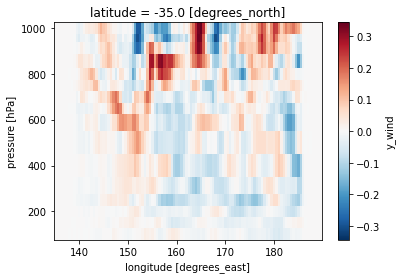

In [118]:
index_y_xr.sel(latitude=-35).isel(time=10).plot()

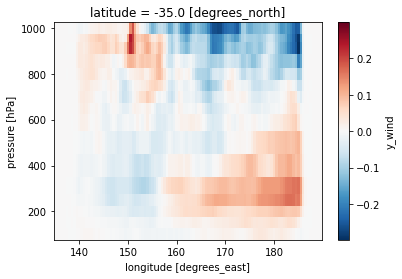

In [119]:
index_y_xr.sel(latitude=-35).mean(dim='time').plot()

/local/e14/cp3790/tmp/ipykernel_3932656/4282766517.py:4: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  contour = ax.contourf(index_y_xr.longitude, index_y_xr.pressure, index_y_xr.sel(latitude=-35).mean(dim='time'),


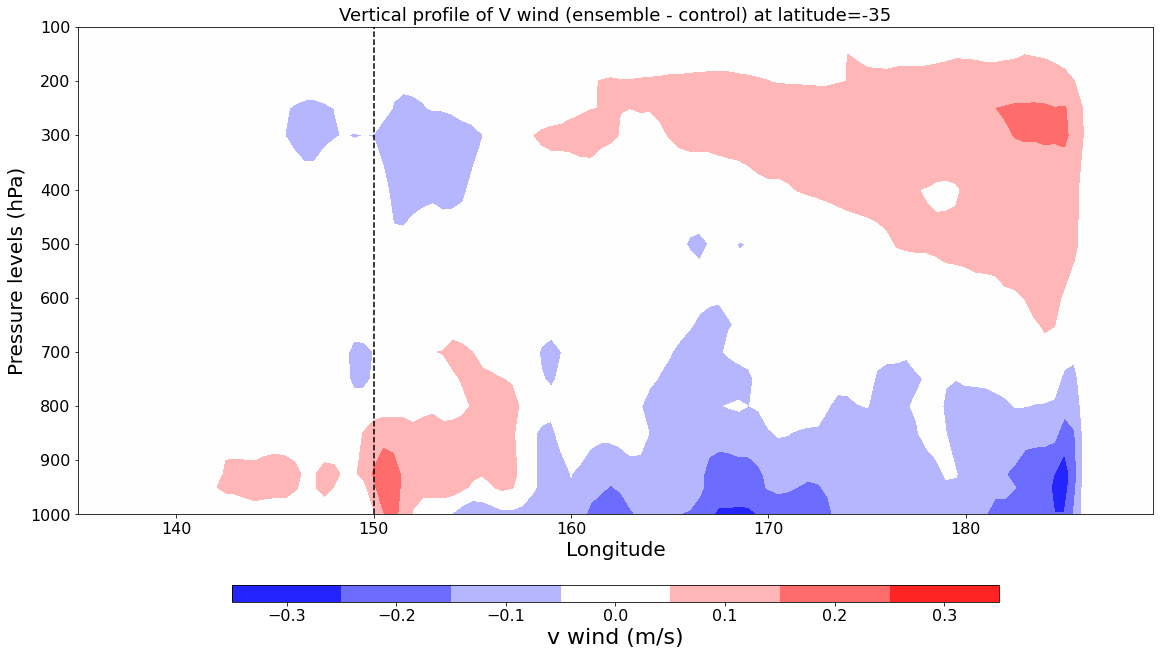

In [123]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(index_y_xr.longitude, index_y_xr.pressure, index_y_xr.sel(latitude=-35).mean(dim='time'), 
                      cmap='bwr',
                      levels=np.arange(-0.35, 0.4, 0.1),
                      add_colorbar=False,
)
plt.gca().invert_yaxis()

ax.set_title("Vertical profile of V wind (ensemble - control) at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Pressure levels (hPa)", fontsize=20)

plt.axvline(x=150, linestyle='--', color='black')

#cbar = fig.colorbar(contour)
#cbar.ax.set_ylabel("u wind (m/s)", fontsize=16)

cb = plt.colorbar(contour, orientation="horizontal",ticks=np.arange(-0.3,0.4,0.1),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'v wind (m/s)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_vwind_mean_-35.png')

/local/e14/cp3790/tmp/ipykernel_3932656/33809369.py:21: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax[row, col].contourf(


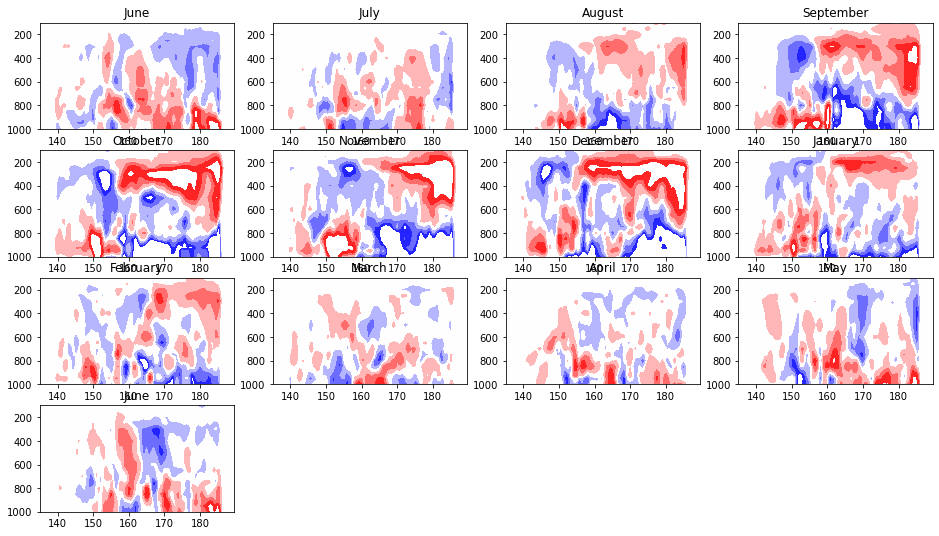

In [122]:
## monthly panels

def multiple_plots():
    nrow = 4
    ncol = 4
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9))  
    
    data = index_y_xr.sel(latitude=-35)

    months = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 
              'March', 'April', 'May', 'June']

#plt.gca().invert_yaxis()

    data_idx = 0
    stop_plotting = False
    for row in range(nrow):
        for col in range(ncol):
            cur_data = data[data_idx]
            ax[row, col].contourf(
                cur_data.longitude,
                cur_data.pressure,
                cur_data.values,
                levels=np.arange(-0.35, 0.4, 0.1),
                add_colorbar=False,
                cmap=plt.cm.get_cmap('bwr'), 
            )
         
            #ax[row, col].coastlines()
            #ax[row, col].set_extent([135, 180, -53, -32],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(months[data_idx])
            ax[row, col].invert_yaxis()
            
            data_idx += 1
            if data_idx > 12:
                stop_plotting = True
                break
        if stop_plotting:
            break

            
    # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise           
    ax_flat = ax.flatten(order='C')
    
                
    # Delete any unused axes from the figure, so that they don't show
    # blank x- and y-axis lines
    for _, axis in enumerate(ax_flat[13:]):
        fig.delaxes(axis) 
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_vwind_monthly_panels_13mths.png')
    

multiple_plots()

## New runs (temperature @ pressure levels)

In [24]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1985/um_pverd_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1991/um_pverd_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1998/um_pverd_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2005/um_pverd_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2011/um_pverd_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-2017/um_pverd_*.nc').sel(time=slice('2017-06', '2018-06'))

In [25]:
con_sm_1985 = ds1.air_temperature
con_sm_1991 = ds2.air_temperature
con_sm_1998 = ds3.air_temperature
con_sm_2005 = ds4.air_temperature
con_sm_2011 = ds5.air_temperature
con_sm_2017 = ds6.air_temperature

In [26]:
ds1 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverd_*.nc').sel(time=slice('1985-06', '1986-06'))
ds2 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1991/um_pverd_*.nc').sel(time=slice('1991-06', '1992-06'))
ds3 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1998/um_pverd_*.nc').sel(time=slice('1998-06', '1999-06'))
ds4 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2005/um_pverd_*.nc').sel(time=slice('2005-06', '2006-06'))
ds5 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2011/um_pverd_*.nc').sel(time=slice('2011-06', '2012-06'))
ds6 = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-2017/um_pverd_*.nc').sel(time=slice('2017-06', '2018-06'))

In [27]:
alt_sm_1985 = ds1.air_temperature
alt_sm_1991 = ds2.air_temperature
alt_sm_1998 = ds3.air_temperature
alt_sm_2005 = ds4.air_temperature
alt_sm_2011 = ds5.air_temperature
alt_sm_2017 = ds6.air_temperature

In [36]:
alt_sm_1985.resample(time='4M').mean()

<xarray.DataArray 'air_temperature' (time: 4, pressure: 16, latitude: 50, longitude: 110)>
dask.array<stack, shape=(4, 16, 50, 110), dtype=float32, chunksize=(1, 16, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1985-06-30 1985-10-31 1986-02-28 1986-06-30
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03

In [28]:
diff_sm_1985 = alt_sm_1985.resample(time='1M').mean() - con_sm_1985.resample(time='1M').mean()
diff_sm_1991 = alt_sm_1991.resample(time='1M').mean() - con_sm_1991.resample(time='1M').mean()
diff_sm_1998 = alt_sm_1998.resample(time='1M').mean() - con_sm_1998.resample(time='1M').mean()
diff_sm_2005 = alt_sm_2005.resample(time='1M').mean() - con_sm_2005.resample(time='1M').mean()
diff_sm_2011 = alt_sm_2011.resample(time='1M').mean() - con_sm_2011.resample(time='1M').mean()
diff_sm_2017 = alt_sm_2017.resample(time='1M').mean() - con_sm_2017.resample(time='1M').mean()

In [29]:
diff_years = [diff_sm_2017, diff_sm_2011, diff_sm_2005, diff_sm_1998, diff_sm_1991, diff_sm_1985][::-1]

index_means = []
for m in range(0, 13):
    index_list = []
    for diff_year in diff_years:
        index_list.append(diff_year.isel(time=m))
    index_means.append(xr.concat(index_list, dim="time").mean(dim="time"))
index_temp_xr = xr.concat(index_means, dim="time") 
index_temp_xr

<xarray.DataArray 'air_temperature' (time: 13, pressure: 16, latitude: 50, longitude: 110)>
dask.array<concatenate, shape=(13, 16, 50, 110), dtype=float32, chunksize=(1, 16, 50, 110), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 135.2 135.8 136.2 136.8 ... 188.8 189.2 189.8
  * latitude   (latitude) float32 -52.75 -52.25 -51.75 ... -29.25 -28.75 -28.25
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03
Dimensions without coordinates: time

In [30]:
index_temp_xr.time

<xarray.DataArray 'time' (time: 13)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Dimensions without coordinates: time

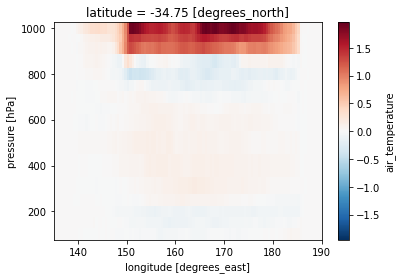

In [146]:
index_temp_xr.sel(latitude=-35, method='nearest').isel(time=7).plot()

/local/e14/cp3790/tmp/ipykernel_3932656/3306098178.py:4: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'cbar_kwargs'
  contour = ax.contourf(index_temp_xr.longitude, index_temp_xr.pressure, index_temp_xr.sel(latitude=-35, method='nearest').mean(dim='time'),


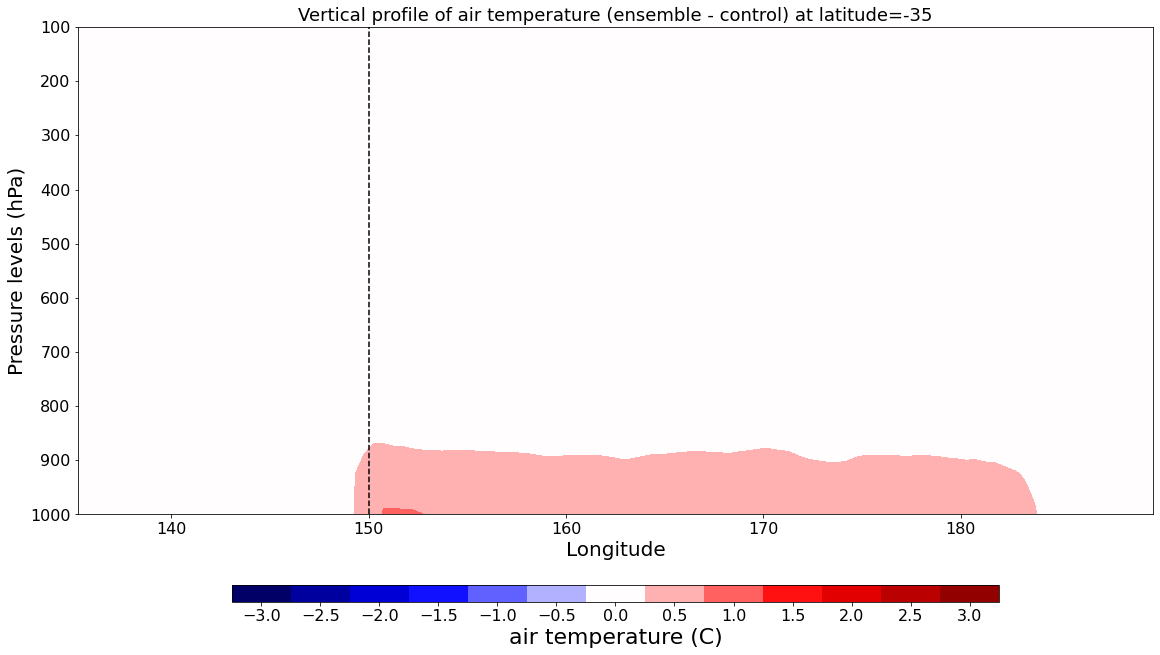

In [197]:
index_x_xr.latitude## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(index_temp_xr.longitude, index_temp_xr.pressure, index_temp_xr.sel(latitude=-35, method='nearest').mean(dim='time'), 
                      cmap='seismic',
                      levels=np.arange(-3.25, 3.5, 0.5),
                      add_colorbar=False,
                    cbar_kwargs={'extend':'both'})

plt.gca().invert_yaxis()

ax.set_title("Vertical profile of air temperature (ensemble - control) at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Pressure levels (hPa)", fontsize=20)

plt.axvline(x=150, linestyle='--', color='black')

#cbar = fig.colorbar(contour)
#cbar.ax.set_ylabel("u wind (m/s)", fontsize=16)

cb = plt.colorbar(contour, orientation="horizontal",
                  ticks=np.arange(-3,3.5,0.5),
                  fraction=0.035,aspect=45)

cb.set_label(label=u'air temperature (C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_temp_mean_-35.png')
plt.show()

/local/e14/cp3790/tmp/ipykernel_3932656/3258099620.py:21: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax[row, col].contourf(


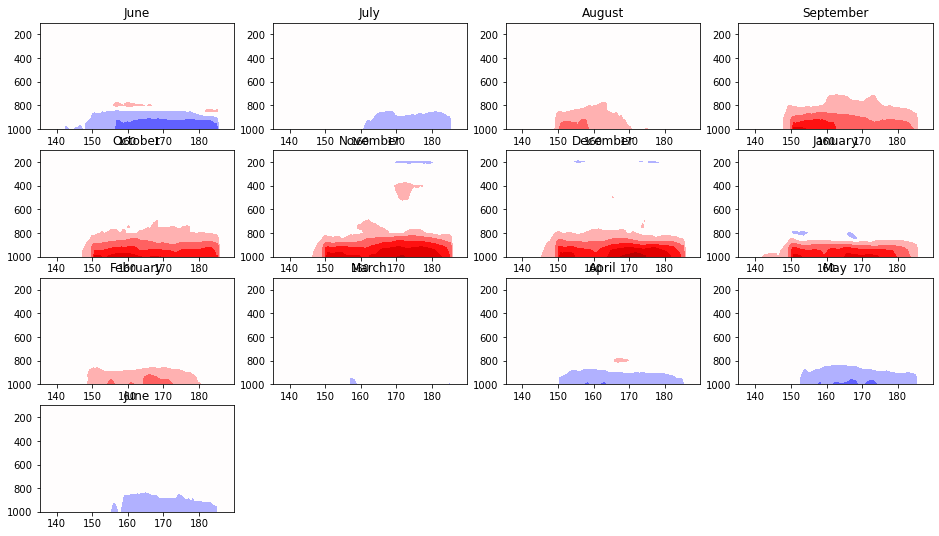

In [164]:
## monthly panels

def multiple_plots():
    nrow = 4
    ncol = 4
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(16,9))  
    
    data = index_temp_xr.sel(latitude=-35, method='nearest')

    months = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 
              'March', 'April', 'May', 'June']

#plt.gca().invert_yaxis()

    data_idx = 0
    stop_plotting = False
    for row in range(nrow):
        for col in range(ncol):
            cur_data = data[data_idx]
            ax[row, col].contourf(
                cur_data.longitude,
                cur_data.pressure,
                cur_data.values,
                levels=np.arange(-3.25, 3.5, 0.5),
                add_colorbar=False,
                cmap=plt.cm.get_cmap('seismic'), 
            )
         
            #ax[row, col].coastlines()
            #ax[row, col].set_extent([135, 180, -53, -32],crs=ccrs.PlateCarree()) 
            ax[row, col].set_title(months[data_idx])
            ax[row, col].invert_yaxis()
            
            data_idx += 1
            if data_idx > 12:
                stop_plotting = True
                break
        if stop_plotting:
            break

            
    # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise           
    ax_flat = ax.flatten(order='C')
    
                
    # Delete any unused axes from the figure, so that they don't show
    # blank x- and y-axis lines
    for _, axis in enumerate(ax_flat[13:]):
        fig.delaxes(axis) 
    plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/diff_temp_monthly_panels_13mths.png')
    

multiple_plots()

## u, v on pressure levels

In [136]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1985/um_pverc_*.nc')
ds

<xarray.Dataset>
Dimensions:             (time: 457, bnds: 2, longitude: 110, latitude: 51, pressure: 16)
Coordinates:
  * time                (time) datetime64[ns] 1985-06-01T12:00:00 ... 1986-08...
  * longitude           (longitude) float32 135.0 135.5 136.0 ... 189.0 189.5
  * latitude            (latitude) float32 -53.0 -52.5 -52.0 ... -28.5 -28.0
  * pressure            (pressure) float64 100.0 150.0 200.0 ... 950.0 1e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    latitude_longitude  (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    x_wind              (time, pressure, latitude, longitude) float32 dask.array<chunksize=(30, 16, 51, 110), meta=np.ndarray>
    y_wind              (time, pressure, latitude, longitude) float32 dask.array<chunksize=(30, 16, 51, 110), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    source:       Data from Met Office Unified Model
    um_version:   11.7
    history:      Thu Feb 24 21:45:17 2022: cdo mergetime /g/data/e14/cp3790/...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [137]:
u_wind = ds.x_wind.sel(time=slice('1985-06', '1986-06'))
u_wind

<xarray.DataArray 'x_wind' (time: 395, pressure: 16, latitude: 51, longitude: 110)>
dask.array<getitem, shape=(395, 16, 51, 110), dtype=float32, chunksize=(31, 16, 51, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1985-06-01T12:00:00 ... 1986-06-30T12:00:00
  * longitude  (longitude) float32 135.0 135.5 136.0 136.5 ... 188.5 189.0 189.5
  * latitude   (latitude) float32 -53.0 -52.5 -52.0 -51.5 ... -29.0 -28.5 -28.0
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03
Attributes:
    standard_name:    x_wind
    units:            m s-1
    grid_mapping:     latitude_longitude
    um_stash_source:  m01s15i201
    cell_methods:     time: mean (interval: 1 hour)

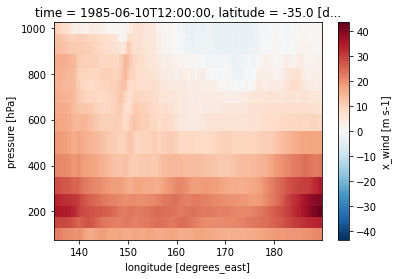

In [50]:
u_wind.sel(latitude=-35).isel(time=9).plot()

In [138]:
u_wind_mon = u_wind.resample(time='1M').mean()
u_wind_mon

<xarray.DataArray 'x_wind' (time: 13, pressure: 16, latitude: 51, longitude: 110)>
dask.array<stack, shape=(13, 16, 51, 110), dtype=float32, chunksize=(1, 16, 51, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1985-06-30 1985-07-31 ... 1986-06-30
  * longitude  (longitude) float32 135.0 135.5 136.0 136.5 ... 188.5 189.0 189.5
  * latitude   (latitude) float32 -53.0 -52.5 -52.0 -51.5 ... -29.0 -28.5 -28.0
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03

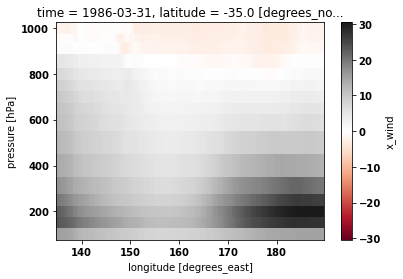

In [90]:
u_wind_mon.sel(latitude=-35).isel(time=9).plot(cmap='RdGy')

In [66]:
u_wind_mon.sel(latitude=-35).isel(time=9)

<xarray.DataArray 'x_wind' (pressure: 16, longitude: 110)>
dask.array<getitem, shape=(16, 110), dtype=float32, chunksize=(16, 110), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 1986-03-31
  * longitude  (longitude) float32 135.0 135.5 136.0 136.5 ... 188.5 189.0 189.5
    latitude   float32 -35.0
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03

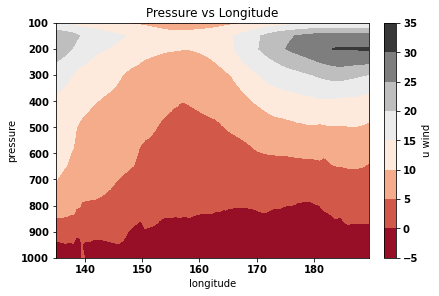

In [89]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True)#111, figsize=(16,9))
#u_wind_mon.sel(latitude=-35).isel(time=9).plot()

contour = ax.contourf(u_wind_mon.longitude, u_wind_mon.pressure, u_wind_mon.sel(latitude=-35).isel(time=9), cmap='RdGy')
plt.gca().invert_yaxis()

ax.set_title("Pressure vs Longitude")
ax.set_xlabel("longitude")
ax.set_ylabel("pressure")

cbar = fig.colorbar(contour)
cbar.ax.set_ylabel("u wind")

plt.show()

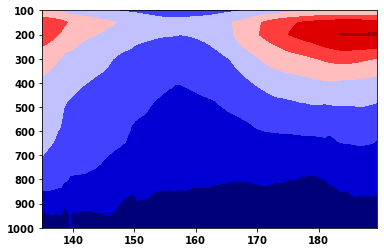

In [116]:
def plot_contrast():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    plt.rcParams["font.weight"] = "bold"
    
    # fig = plt.figure(figsize=(24.0,6.0))
    #fig, ax = plt.subplots(111, figsize=(16,9)) 
        
    # Plot the data
    cm = plt.contourf(u_wind_mon.longitude,u_wind_mon.pressure,u_wind_mon.sel(latitude=-35).isel(time=9), cmap='seismic')
    
    plt.gca().invert_yaxis()
    
    # Label the Y-axis and add a title
    ax.set_ylabel('Pressure level (hPa)', fontweight = 'bold',fontsize=14)
    ax.set_title('Pressure levels plot', fontweight='bold',loc='left')
    
    # Amend x-axis
    ax.set_xticks(u_wind_mon.longitude)
    ax.set_xticklabels(np.round(u_wind_mon.longitude,5),rotation=90,fontsize=18)

    # Amend y-axis
    ax.set_ylim(100,1000)
    
    # All the colorbar on the separate subplot
    #plt.colorbar(cm, cax)
    
    plt.show()   
    
plot_contrast()

In [121]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverc_*.nc')
u_wind_alt = ds.x_wind.sel(time=slice('1985-06', '1986-06'))
u_wind_alt_mon = u_wind.resample(time='1M').mean()

In [139]:
u_wind_diff = u_wind_alt_mon - u_wind_mon

In [140]:
u_wind_diff

<xarray.DataArray 'x_wind' (time: 13, pressure: 16, latitude: 51, longitude: 110)>
dask.array<sub, shape=(13, 16, 51, 110), dtype=float32, chunksize=(1, 16, 51, 110), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1985-06-30 1985-07-31 ... 1986-06-30
  * longitude  (longitude) float32 135.0 135.5 136.0 136.5 ... 188.5 189.0 189.5
  * latitude   (latitude) float32 -53.0 -52.5 -52.0 -51.5 ... -29.0 -28.5 -28.0
  * pressure   (pressure) float64 100.0 150.0 200.0 250.0 ... 925.0 950.0 1e+03

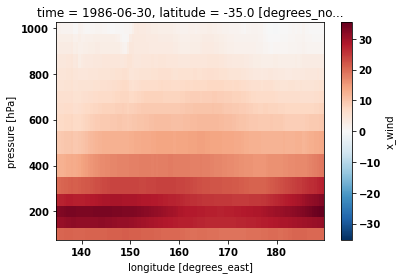

In [128]:
u_wind_alt_mon.sel(latitude=-35).isel(time=12).plot()

In [147]:
u_wind_diff.values

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

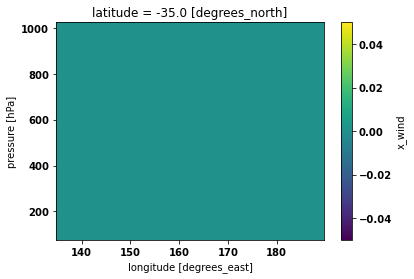

In [234]:
u_wind_diff.sel(latitude=-35).mean(dim='time').plot()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)#111, figsize=(16,9))
#u_wind_mon.sel(latitude=-35).isel(time=9).plot()

contour = ax.contourf(u_wind_mon.longitude, u_wind_mon.pressure, u_wind_mon.sel(latitude=-35).isel(time=9), cmap='RdGy')
plt.gca().invert_yaxis()

In [148]:
u_wind_alt_mon['time'] = pd.to_datetime(u_wind_alt_mon['time'])
u_wind_alt_mon['Mon_Year'] = u_wind_alt_mon['time'].dt.strftime('%b-%Y')

In [159]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverc_*.nc')
v_wind_alt = ds.y_wind.sel(time=slice('1985-06', '1986-06'))
v_wind_alt_mon = v_wind_alt.resample(time='1M').mean()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [161]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/alt-runs/alt-result-1985/um_pverc_*.nc')
u_wind_alt = ds.x_wind.sel(time=slice('1985-06', '1986-06'))
u_wind_alt_mon = u_wind_alt.resample(time='1M').mean()

In [163]:
ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/ModelRun/control-new/result-1985/um_pverc_*.nc')
v_wind = ds.y_wind.sel(time=slice('1985-06', '1986-06'))
v_wind_mon = v_wind_alt.resample(time='1M').mean()

In [164]:
diff = v_wind_alt_mon - v_wind_mon

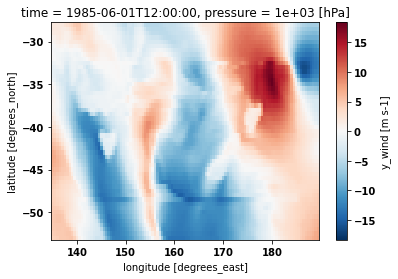

In [176]:
v_wind.sel(pressure=1000).isel(time=0).plot()

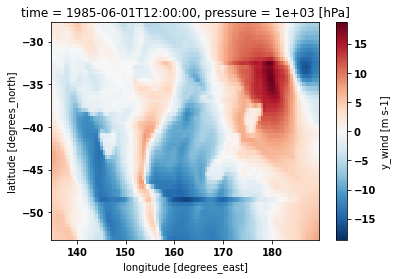

In [179]:
v_wind_alt.sel(pressure=1000).isel(time=0).plot()

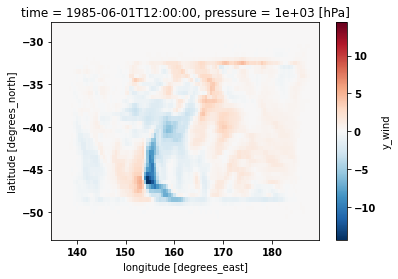

In [180]:
(v_wind_alt.sel(pressure=1000).isel(time=0) - v_wind.sel(pressure=1000).isel(time=0)).plot()

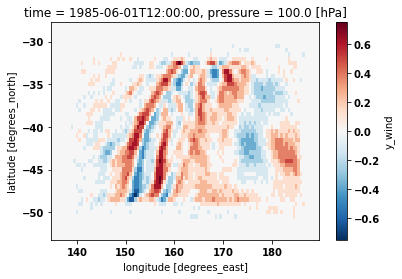

In [225]:
(v_wind_alt.sel(pressure=100).isel(time=0) - v_wind.sel(pressure=100).isel(time=0)).plot()

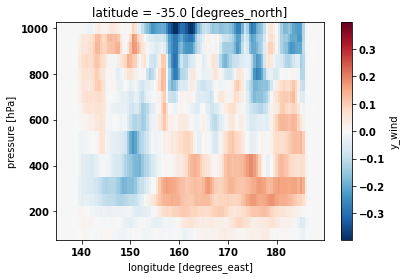

In [232]:
(v_wind_alt.sel(latitude=-35).mean(dim='time') - v_wind.sel(latitude=-35).mean(dim='time')).plot()

In [239]:
diff_35 = u_wind_alt.sel(latitude=-35).mean(dim='time') - u_wind.sel(latitude=-35).mean(dim='time')

In [241]:
diff_35v = v_wind_alt.sel(latitude=-35).mean(dim='time') - v_wind.sel(latitude=-35).mean(dim='time')

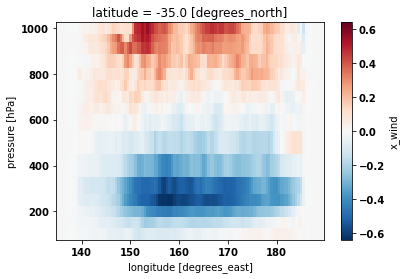

In [233]:
(u_wind_alt.sel(latitude=-35).mean(dim='time') - u_wind.sel(latitude=-35).mean(dim='time')).plot()

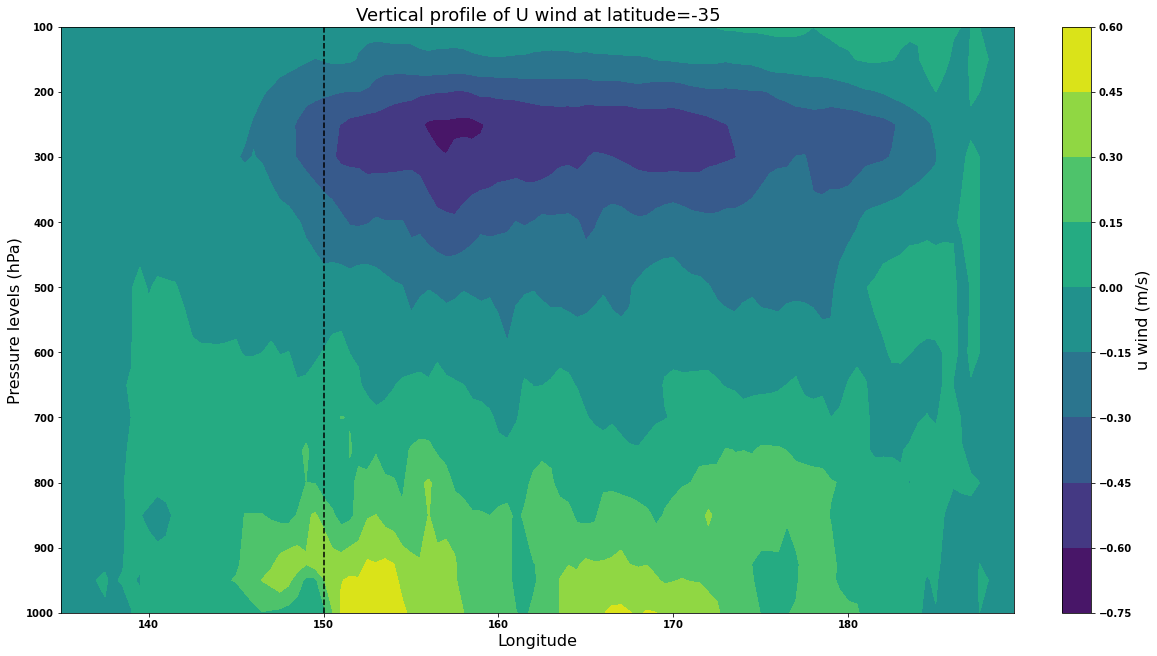

In [246]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(diff_35.longitude, diff_35.pressure, diff_35, 
                      cmap='viridis',
)
plt.gca().invert_yaxis()

ax.set_title("Vertical profile of U wind at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Pressure levels (hPa)", fontsize=16)

plt.axvline(x=150, linestyle='--', color='black')

cbar = fig.colorbar(contour)
cbar.ax.set_ylabel("u wind (m/s)", fontsize=16)

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/alt_uwind_mean_-35.png')

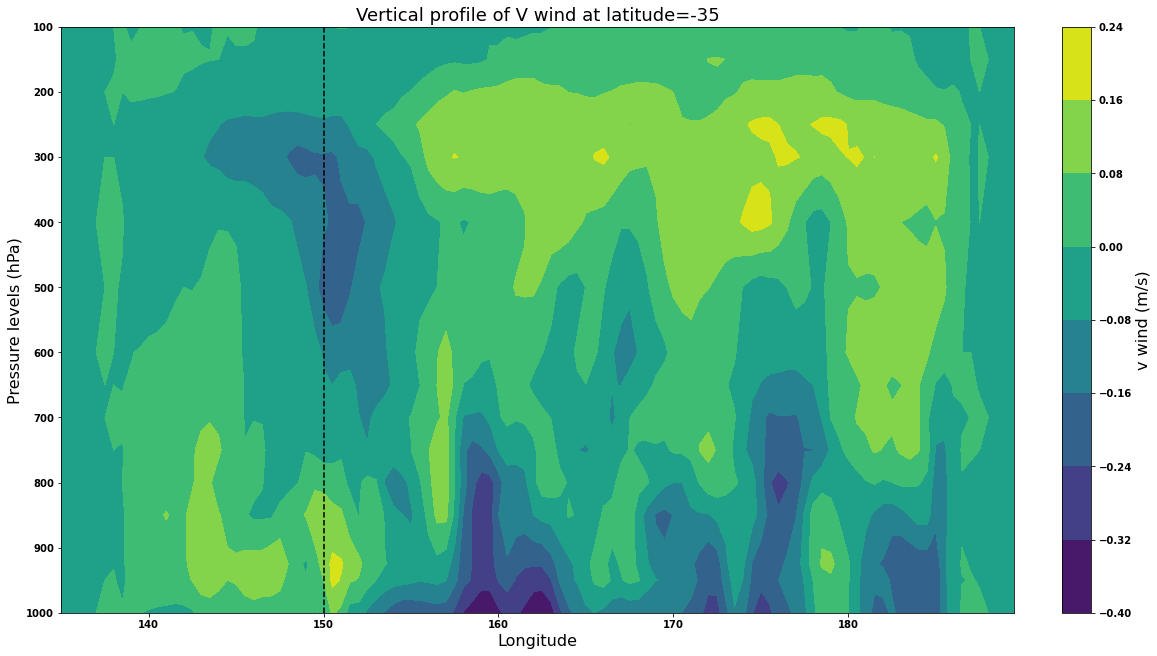

In [247]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(diff_35v.longitude, diff_35v.pressure, diff_35v, 
                      cmap='viridis',
)
plt.gca().invert_yaxis()

ax.set_title("Vertical profile of V wind at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Pressure levels (hPa)", fontsize=16)
plt.axvline(x=150, linestyle='--', color='black')

cbar = fig.colorbar(contour)
cbar.ax.set_ylabel("v wind (m/s)", fontsize=16)

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/alt_vwind_mean_-35.png')

In [ ]:
## new diff plot (monthly groupby)
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

contour = ax.contourf(diff_35v.longitude, diff_35v.pressure, diff_35v, 
                      cmap='viridis',
)
plt.gca().invert_yaxis()

ax.set_title("Vertical profile of V wind at latitude=-35", fontsize=18)
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Pressure levels (hPa)", fontsize=16)
plt.axvline(x=150, linestyle='--', color='black')

cbar = fig.colorbar(contour)
cbar.ax.set_ylabel("v wind (m/s)", fontsize=16)

plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/alt_vwind_mean_-35.png')

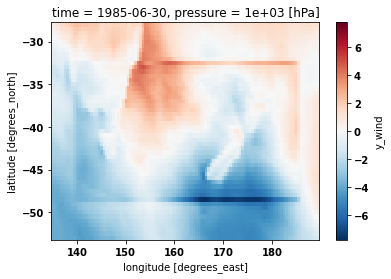

In [175]:
v_wind_mon.sel(pressure=1000).isel(time=0).plot()

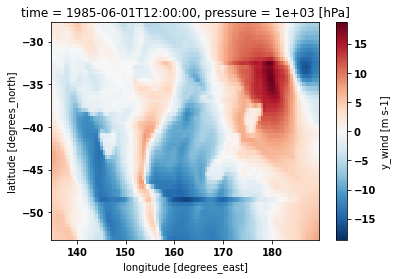

In [178]:
v_wind_alt.sel(pressure=1000).isel(time=0).plot()

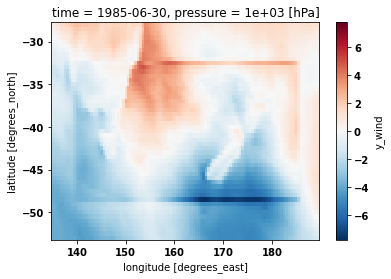

In [174]:
v_wind_alt_mon.sel(pressure=1000).isel(time=0).plot()

## Absolute temperature

In [206]:
at = xr.open_mfdataset(['/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/era5_dailytmax_2015.nc', 
                        '/g/data/e14/cp3790/Charuni/NCI/ERA5-TEMP/era5_dailytmax_2016.nc']).sel(time=slice('2015-06', '2016-06'))

In [212]:
sat_abs = (at['tmax']-273.15).sel(latitude=slice(-30, -53), longitude=slice(135, 180)).mean(dim='time')

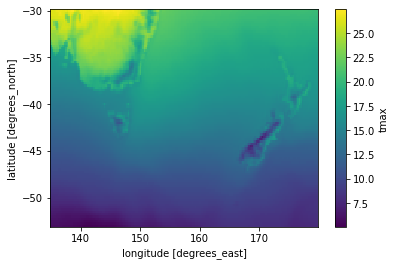

In [213]:
sat_abs.plot()

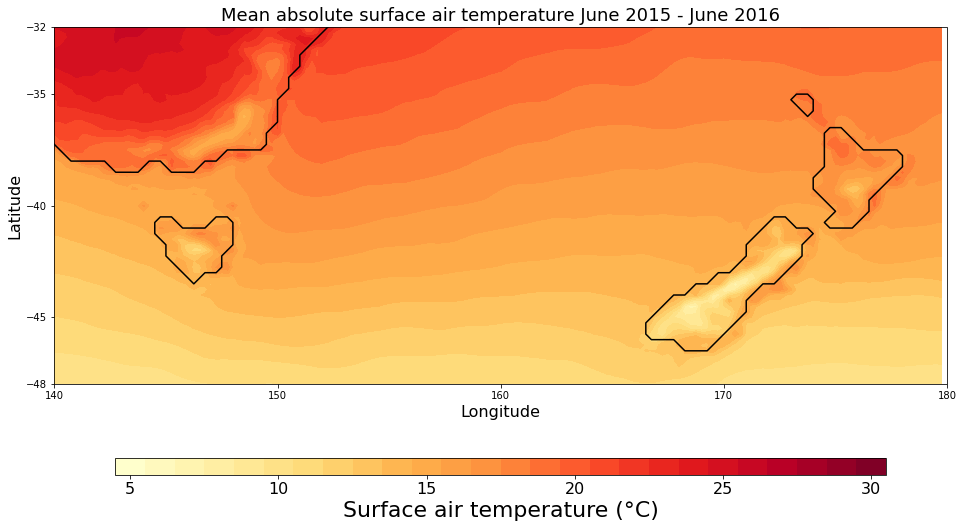

In [219]:
fig, ax = plt.subplots(111, figsize=(16,9))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([142, 180, -48, -32],crs=ccrs.PlateCarree())    

ax.set_xticks([140, 150, 160, 170, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-48, -45, -40, -35, -32], crs=ccrs.PlateCarree())

im=sat_abs.plot.contourf(
            levels=np.arange(4.5, 31, 1),
            add_colorbar=False,
            cmap=plt.cm.get_cmap('YlOrRd'), 
       )

cb = plt.colorbar(im, orientation="horizontal",ticks=np.arange(5,35,5),fraction=0.035,aspect=45) #,format='%.2f')
cb.set_label(label=u'Surface air temperature (\u00B0C)', size=22, weight='normal')
cb.ax.tick_params(labelsize=16)


mask.mean(dim='time').plot.contour(levels=[0.5], cmap='k')

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Mean absolute surface air temperature June 2015 - June 2016', fontsize=18)

#plt.show()
plt.savefig('/g/data/e14/cp3790/Charuni/ModelExperiment/abs_temp.png')